<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [6]:
# Authentication credentials and keys
# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [7]:
# Feature Data for FA Cup games with last 2 seasons held back for final testing of best models

fa_cup_raw_features = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features WHERE season_year NOT IN ('21/22', '22/23')
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe().drop(columns=['season_year'])
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


arena_stadium_capacity  home_team_league_level  home_win  \
0                     41837                       1         1   
1                     41837                       1         1   
2                     41837                       1         1   
3                     74879                       1         1   
4                     74879                       1         0   
..                      ...                     ...       ...   
300                    <NA>                       6         0   
301                    <NA>                       6         0   
302                    9527                       4         1   
303                    6064                       6         0   
304                    4100                       6         1   

     home_team_round_3_position  home_team_massey  home_team_colley  \
0                             1                 1                 1   
1                             1                 1                 1   
2                             1                 1                 1   
3                             1                 1                 1   
4                             2                 3                 7   
..                          ...               ...               ...   
300                          64                58                64   
301                          64                58                64   
302                          64                58                64   
303                          64                58                64   
304                          64                58                64   

     home_team_keener  home_team_trueskill  home_team_borda_count  \
0                  12                    1                      1   
1                  12                    1                      1   
2                  12                    1                      1   
3                  12                    1                      1   
4                   4                    6                      5   
..                ...                  ...                    ...   
300                53                   63                     64   
301                53                   63                     64   
302                53                   63                     64   
303                53                   63                     64   
304                53                   63                     64   

     home_team_local_kemeny_optimisation  ...  match_weather_data_hours_dew  \
0                                      1  ...                           NaN   
1                                      1  ...                         34.70   
2                                      1  ...                         47.00   
3                                      1  ...                         71.20   
4                                      5  ...                           NaN   
..                                   ...  ...                           ...   
300                                   64  ...                           NaN   
301                                   64  ...                           NaN   
302                                   64  ...                         37.15   
303                                   64  ...                         41.45   
304                                   64  ...                         32.75   

     match_weather_data_hours_precip  match_weather_data_hours_snow  \
0                                NaN                            NaN   
1                              0.000                            0.0   
2                              0.000                            0.0   
3                              0.000                            NaN   
4                                NaN                            NaN   
..                               ...                            ...   
300                              NaN                            NaN   
301                      

Empty DataFrame
Columns: [metric_id, metric]
Index: []

In [8]:
# Function to calculate home advantage
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [9]:
# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}


In [10]:
# Function to run model classifiers
def classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47):

  # Empty df for consolidating results
  all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
  fold_results = []

  # Define the ranking systems
  ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

  # Get all columns except the target and ranking columns
  target_variable = 'target_variable'
  base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

  # Identify numeric and categorical columns
  numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

  # Define preprocessing steps

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  ranking_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler())
  ])

  # Define cross-validation strategy
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Loop through each ranking system
  for ranking in ranking_systems:
      model_name_ranking = f"{model_name} {ranking}"
      print(model_name_ranking)

      if ranking == 'no_ranking':
          # Use all base features without ranking
          X = fa_cup_raw_features_df[base_features]
      else:
          # Include ranking features
          current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
          X = fa_cup_raw_features_df[current_features]

      y = fa_cup_raw_features_df['target_variable']

      # Initialize lists to store results for each fold of the model
      fold_accuracies = []
      fold_recalls = []
      confusion_matrices = []
      classification_reports = []
      all_y_true = []
      all_y_pred = []
      all_y_pred_proba = []  # Store probabilities for ROC

      # Perform cross-validation
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
      for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
          X_train, X_val = X.iloc[train_index], X.iloc[val_index]
          y_train, y_val = y.iloc[train_index], y.iloc[val_index]

           # Add home advantage if specified
          if home_advt == 'yes':
              X_train, home_advantage_column = add_home_advantage(X_train)
              X_val, _ = add_home_advantage(X_val)
              numeric_features = [home_advantage_column] + numeric_features

          # Update preprocessor
          if ranking == 'no_ranking':
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features)
                  ], verbose_feature_names_out=False)

          else:
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features),
                      ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                  ], verbose_feature_names_out=False)


          if weighted == 'yes':
             # Calculate weights using only training data
              weights = calculate_weights(y_train)
              print(f"Weights being used: {weights}")

          # Create pipeline
          pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
            ])

          # Create GridSearchCV object
          grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

          # Fit GridSearchCV
          grid_search.fit(X_train, y_train)

          # Get best model
          best_model = grid_search.best_estimator_

          # Print the best recall from GridSearchCV
          print(f"Best parameters: {grid_search.best_params_}")
          print(f"Best Estimator's Recall (from GridSearchCV): {grid_search.best_score_:.3f}")

          # Make predictions
          y_pred = best_model.predict(X_val)
          y_pred_proba = best_model.predict_proba(X_val)[:, 1] # Probabilities for the positive class and ROC curve/AUC Score

          # Calculate accuracy
          accuracy = accuracy_score(y_val, y_pred)
          fold_accuracies.append(accuracy)

          # Calculate recall
          recall = recall_score(y_val, y_pred)
          fold_recalls.append(recall)

          # Store fold results
          fold_results.append({
              'Model Name Ranking': model_name_ranking,
              'Fold': fold,
              'Best Parameters (GridSearchCV)': grid_search.best_params_,
              'Best Recall (GridSearchCV)': grid_search.best_score_,
              'Validation Accuracy': accuracy,
              'Validation Recall': recall
          })

          # Confusion matrix
          cm = confusion_matrix(y_val, y_pred)
          confusion_matrices.append(cm)

          # Generate classification report
          cr = classification_report(y_val, y_pred, output_dict=True)
          classification_reports.append(cr)

          # Store true and predicted values for later analysis
          all_y_true.extend(y_val)
          all_y_pred.extend(y_pred)
          all_y_pred_proba.extend(y_pred_proba)

          print(f"Fold {fold} Accuracy: {accuracy:.3f}")
          print(f"Fold {fold} Recall: {recall:.3f}")

      # Calculate average accuracy
      avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
      print(f"Average Accuracy: {avg_accuracy:.3f}")

      # Calculate average recall
      avg_recall = sum(fold_recalls) / len(fold_recalls)
      print(f"Average Recall: {avg_recall:.3f}")

      # Create and display results using existing function
      results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies, fold_recalls,  all_y_pred_proba, model_name_ranking)
      results_df = results_df.reset_index()
      results_df['metric_id'] = results_df.index + 1
      results_df = results_df[['metric_id', 'metric', model_name_ranking]]

      all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

      fold_results_df = pd.DataFrame(fold_results)

  return all_results_df, fold_results_df

Standard LogisticRegression no_ranking
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.705
Fold 1 Recall: 0.188
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.250
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 3 Accuracy: 0.639
Fold 3 Recall: 0.188
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Accuracy: 0.689
Fold 4 Recall: 0.118
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.383


metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Standard LogisticRegression no_ranking  \
0                                   0.679   
1                                   0.034   
2                                   0.184   
3                                   0.042   
4                                   0.679   
5                                 192.000   
6                                  31.000   
7                                  67.000   
8                                  15.000   
9                                   0.741   
10                                  0.861   
11                                  0.797   
12                                  0.326   
13                                  0.183   
14                                  0.234   
15                                  0.534   
16                                  0.522   
17                                  0.516   
18                                  0.630   
19                                  0.679   
20                                  0.646   
21                                  0.529   

   Standard LogisticRegression round_3_position  \
0                                         0.705   
1                                         0.036   
2                                         0.268   
3                                         0.030   
4                                         0.705   
5                                       193.000   
6                                        30.000   
7                                        60.000   
8                                        22.000   
9                                         0.763   
10                                        0.865   
11                                        0.811   
12                                        0.423   
13                                        0.268   
14                                        0.328   
15                                        0.593   
16                                        0.567   
17                                        0.570   
18                                        0.671   
19                                        0.705   
20                                        0.681   
21                                        0.574   

   Standard LogisticRegression massey Standard LogisticRegression colley  \
0                               0.692                              0.685   
1                               0.026                              0.039   
2                               0.221                              0.207   
3                               0.053   

Model Name Ranking  Fold  \
0              Standard LogisticRegression no_ranking     1   
1              Standard LogisticRegression no_ranking     2   
2              Standard LogisticRegression no_ranking     3   
3              Standard LogisticRegression no_ranking     4   
4              Standard LogisticRegression no_ranking     5   
5        Standard LogisticRegression round_3_position     1   
6        Standard LogisticRegression round_3_position     2   
7        Standard LogisticRegression round_3_position     3   
8        Standard LogisticRegression round_3_position     4   
9        Standard LogisticRegression round_3_position     5   
10                 Standard LogisticRegression massey     1   
11                 Standard LogisticRegression massey     2   
12                 Standard LogisticRegression massey     3   
13                 Standard LogisticRegression massey     4   
14                 Standard LogisticRegression massey     5   
15                 Standard LogisticRegression colley     1   
16                 Standard LogisticRegression colley     2   
17                 Standard LogisticRegression colley     3   
18                 Standard LogisticRegression colley     4   
19                 Standard LogisticRegression colley     5   
20                 Standard LogisticRegression keener     1   
21                 Standard LogisticRegression keener     2   
22                 Standard LogisticRegression keener     3   
23                 Standard LogisticRegression keener     4   
24                 Standard LogisticRegression keener     5   
25              Standard LogisticRegression trueskill     1   
26              Standard LogisticRegression trueskill     2   
27              Standard LogisticRegression trueskill     3   
28              Standard LogisticRegression trueskill     4   
29              Standard LogisticRegression trueskill     5   
30            Standard LogisticRegression borda_count     1   
31            Standard LogisticRegression borda_count     2   
32            Standard LogisticRegression borda_count     3   
33            Standard LogisticRegression borda_count     4   
34            Standard LogisticRegression borda_count     5   
35  Standard LogisticRegression local_kemeny_optim...     1   
36  Standard LogisticRegression local_kemeny_optim...     2   
37  Standard LogisticRegression local_kemeny_optim...     3   
38  Standard LogisticRegression local_kemeny_optim...     4   
39  Standard LogisticRegression local_kemeny_optim...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 10.0, 'classifier__penalty':...   
1   {'classifier__C': 1000.0, 'classifier__penalty...   
2   {'classifier__C': 100.0, 'classifier__penalty'...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 1000.0, 'classifier__penalty...   
5   {'classifier__C': 1000.0, 'classifier__penalty...   
6   {'classifier__C': 10.0, 'classifier__penalty':...   
7   {'classifier__C': 100.0, 'classifier__penalty'...   
8   {'classifier__C': 10.0, 'classifier__penalty':...   
9   {'classifier__C': 1000.0, 'classifier__penalty...   
10  {'classifier__C': 10.0, 'classifier__penalty':...   
11  {'classifier__C': 10.0, 'classifier__penalty':...   
12  {'classifier__C': 100.0, 'classifier__penalty'...   
13  {'classifier__C': 10.0, 'classifier__penalty':...   
14  {'classifier__C': 1000.0, 'classifier__penalty...   
15  {'classifier__C': 10.0, 'classifier__penalty':...   
16  {'classifier__C': 10.0, 'classifier__penalty':...   
17  {'classifier__C': 10.0, 'classifier__penalty':...   
18  {'classifier__C': 10.0, 'classifier__penalty':...   
19  {'classifier__C': 100.0, 'classifier__penalty'...   
20  {'classifier__C': 1000.0, 'classifier__penalty...   
21  {'classifier__C': 10.0, 'classifier__penalty':...   
22  {'classifier__C': 100.0, 'classifier__penalty'...   
23  {'classifier__C': 10.0, 'classifier__penalty':...   
24  {'classifier__C': 1000

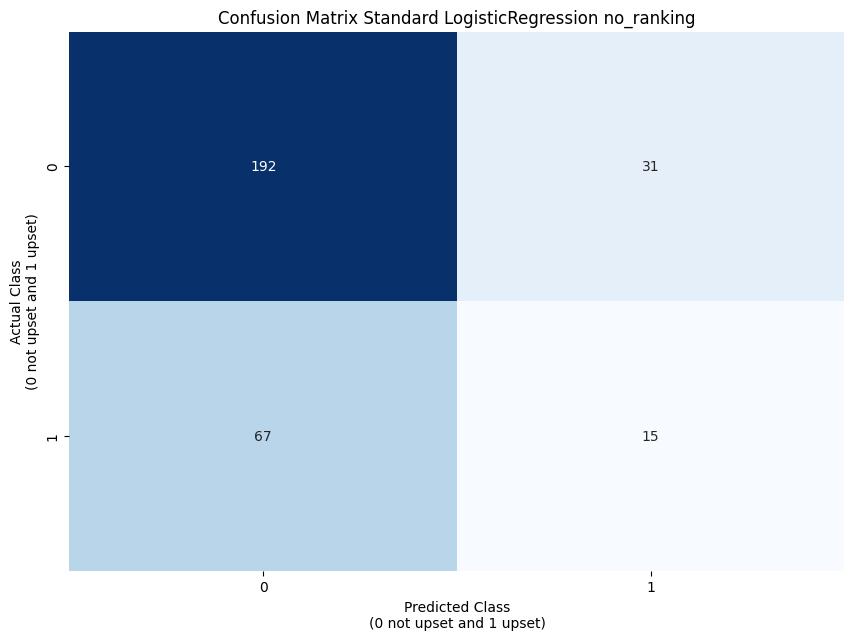

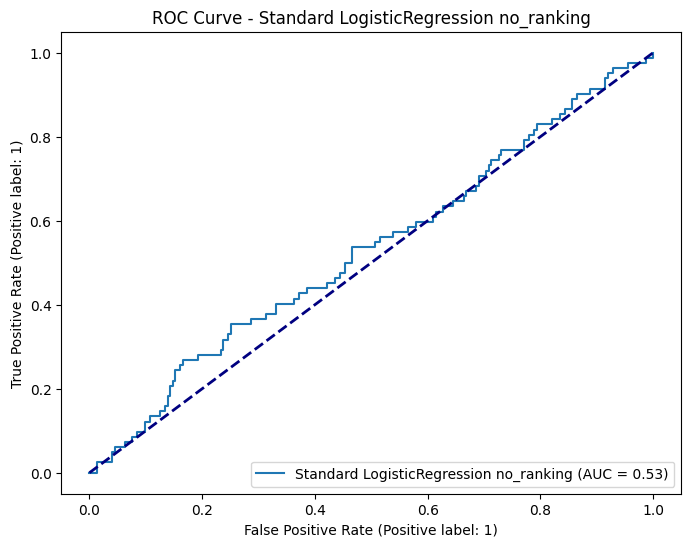

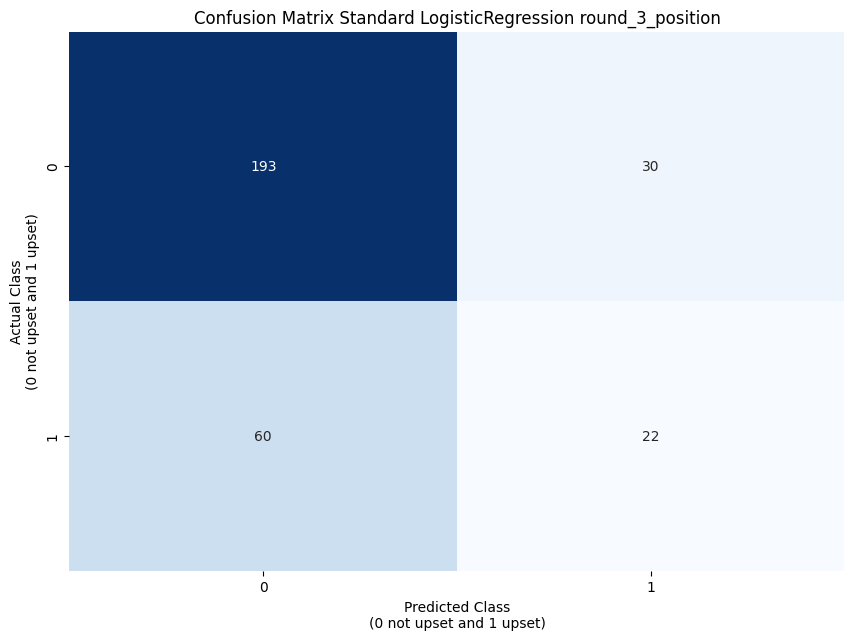

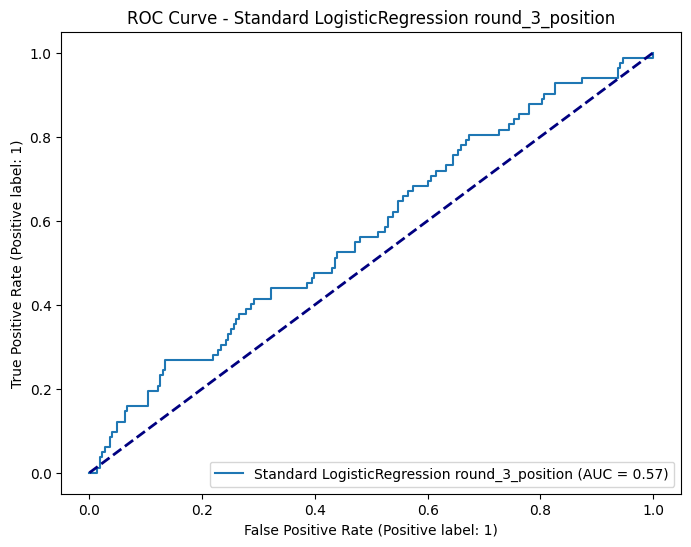

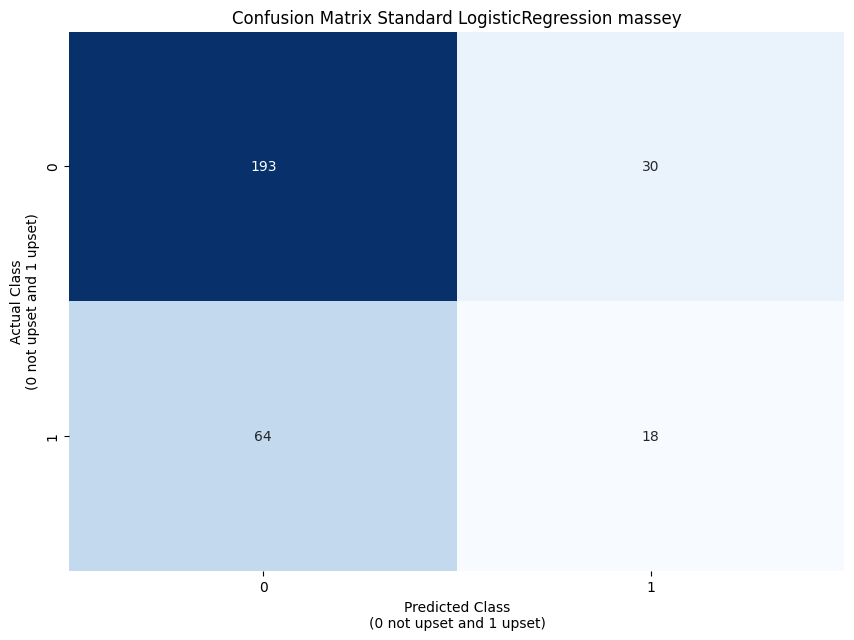

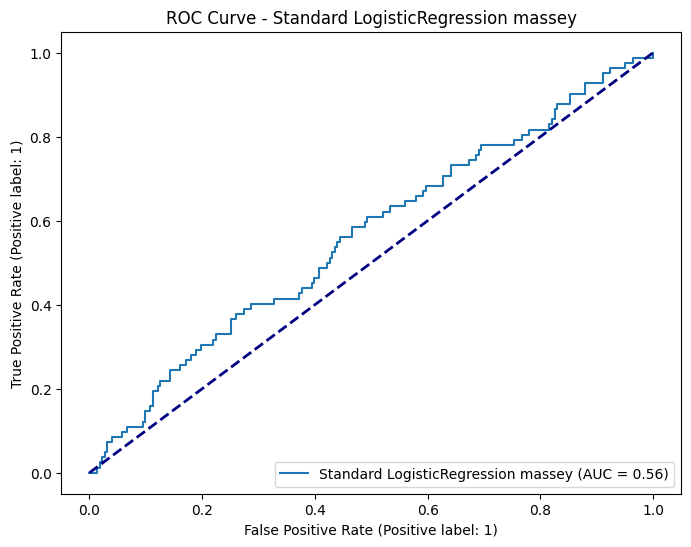

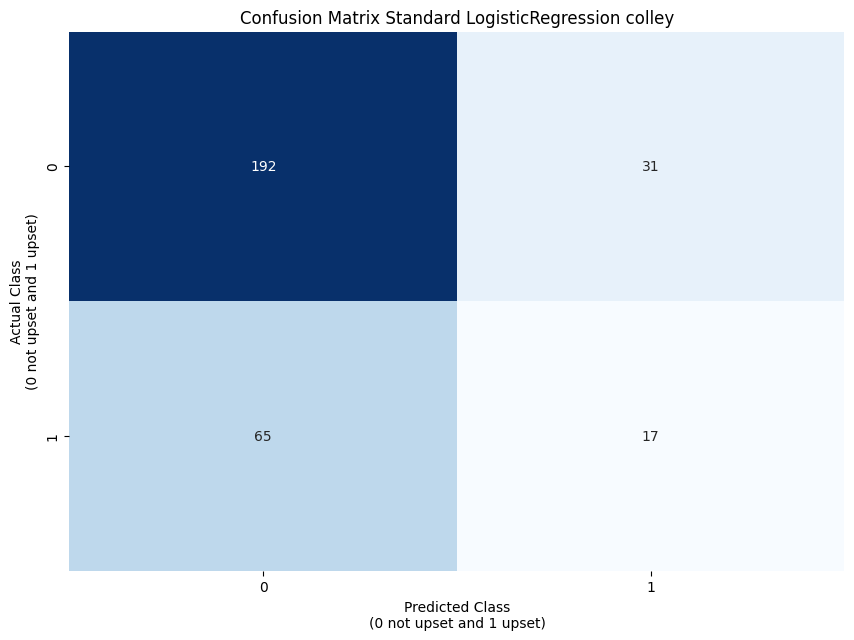

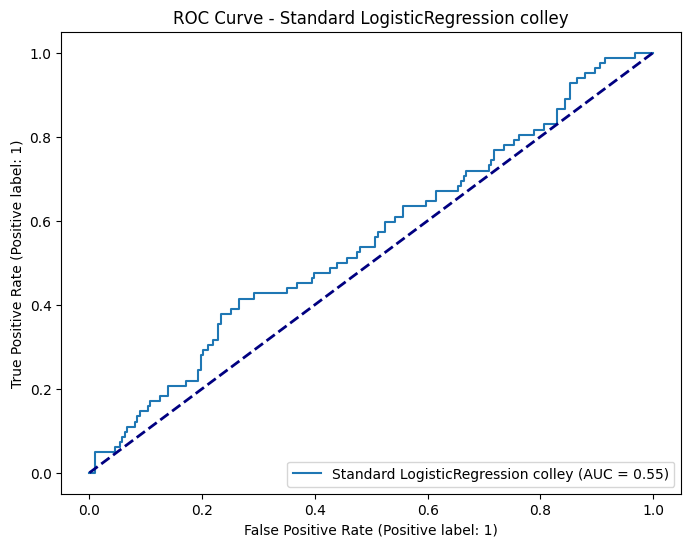

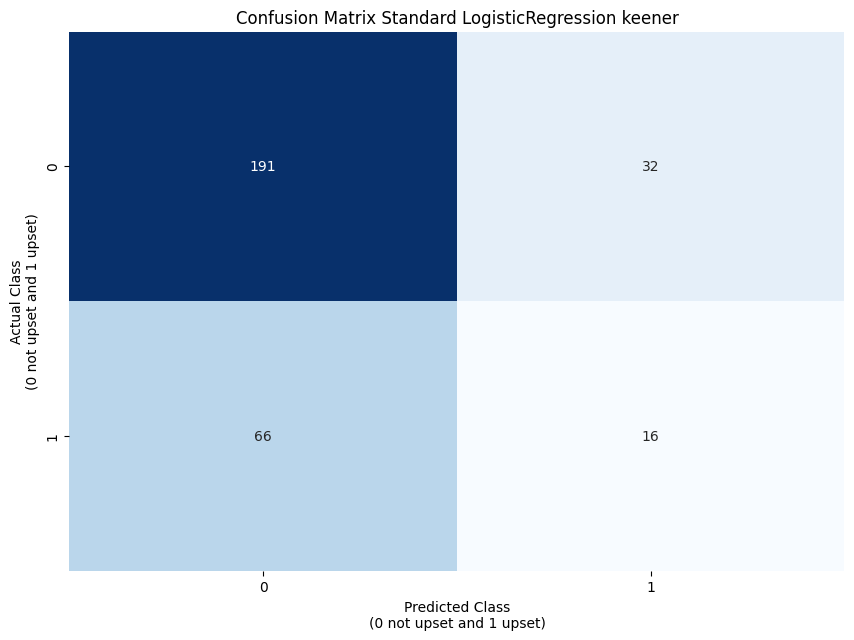

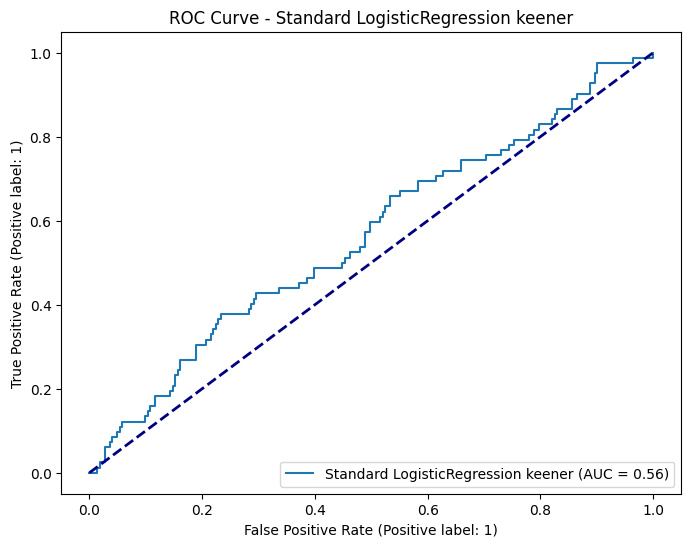

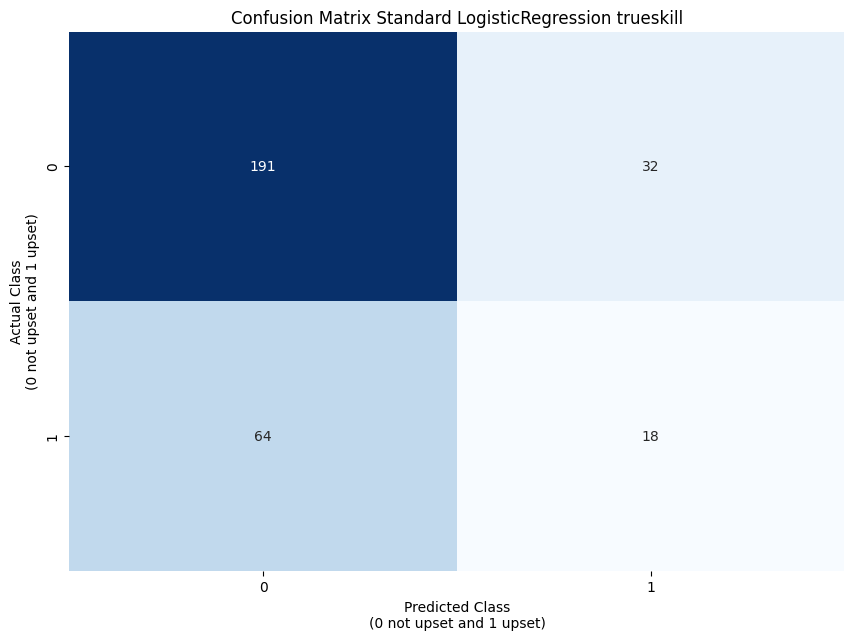

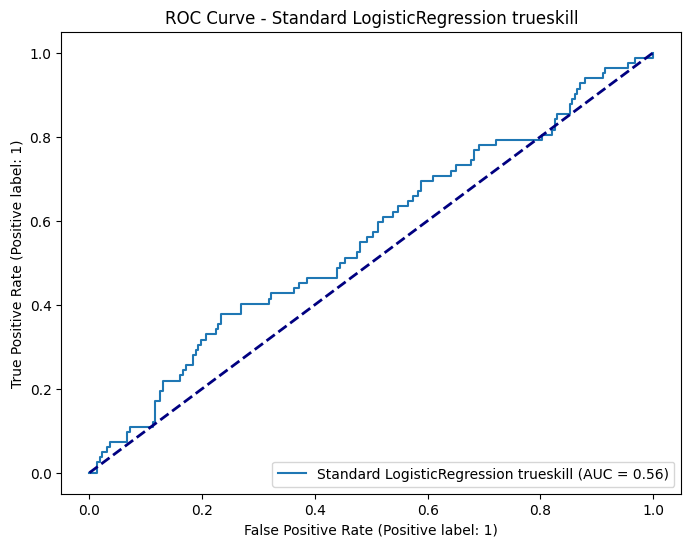

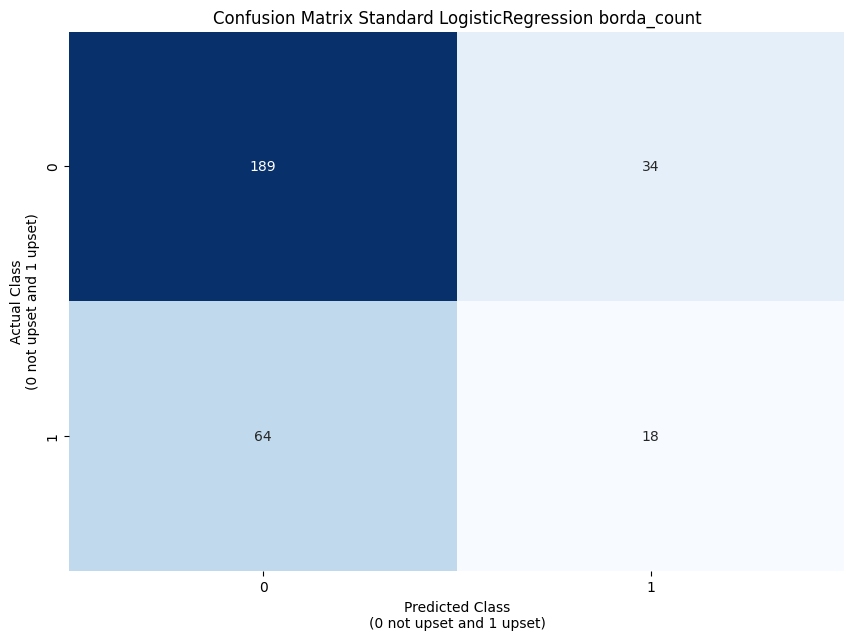

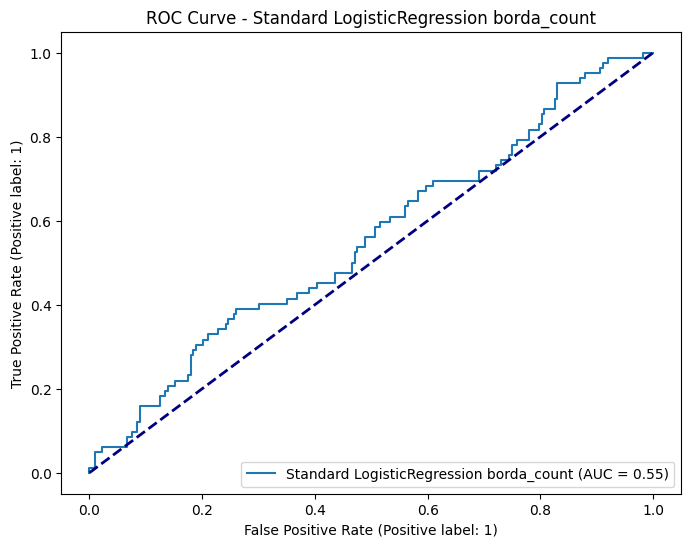

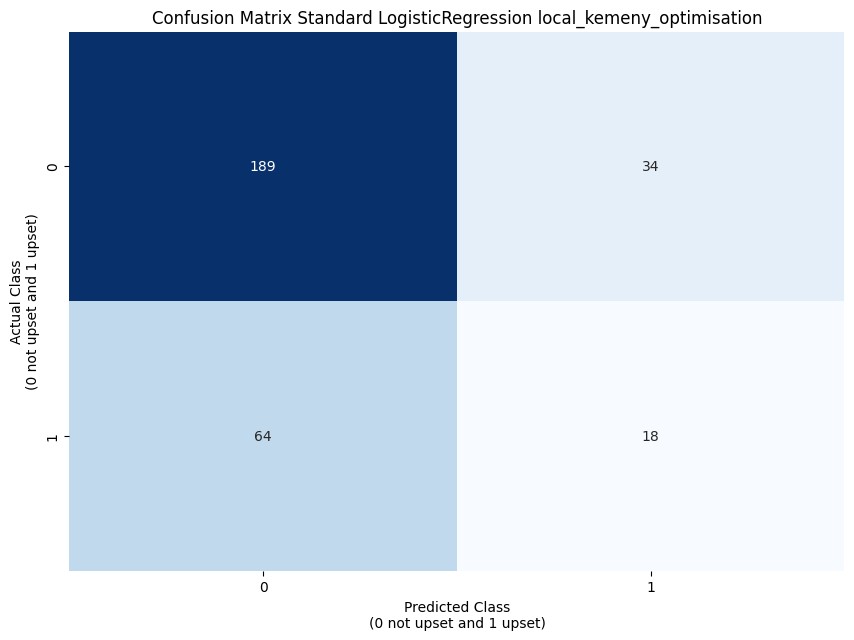

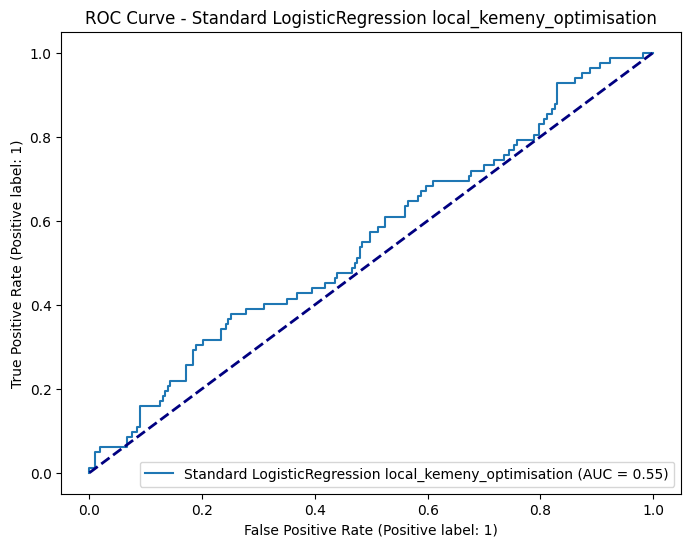

In [11]:
# Standard, no weights
model_name = "Standard LogisticRegression"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slr = all_results_df
display(all_results_df_slr)

fold_results_df_slr = fold_results_df
display(fold_results_df_slr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results.xlsx")
fold_results_df_slr.to_excel("fold_results_slr.xlsx")


Standard LogisticRegression with home advantage no_ranking
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.485
Fold 1 Accuracy: 0.689
Fold 1 Recall: 0.125
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.250
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 3 Accuracy: 0.656
Fold 3 Recall: 0.250
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.443
Fold 4 Accuracy: 0.705
Fold 4 Recall: 0.235
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from 

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Standard LogisticRegression with home advantage no_ranking  \
0                                               0.682           
1                                               0.030           
2                                               0.207           
3                                               0.049           
4                                               0.682           
5                                             191.000           
6                                              32.000           
7                                              65.000           
8                                              17.000           
9                                               0.746           
10                                              0.857           
11                                              0.797           
12                                              0.347           
13                                              0.207           
14                                              0.260           
15                                              0.547           
16                                              0.532           
17                                              0.529           
18                                              0.639           
19                                              0.682           
20                                              0.653           
21                                              0.515           

   Standard LogisticRegression with home advantage round_3_position  \
0                                               0.702                 
1                                               0.026                 
2                                               0.257                 
3                                               0.029                 
4                                               0.702                 
5                                             193.000                 
6                                              30.000                 
7                                              61.000                 
8                                              21.000                 
9                                               0.760                 
10                                              0.865                 
11                                              0.809                 
12                                              0.412                 
13                                              0.256           

Model Name Ranking  Fold  \
0   Standard LogisticRegression with home advantag...     1   
1   Standard LogisticRegression with home advantag...     2   
2   Standard LogisticRegression with home advantag...     3   
3   Standard LogisticRegression with home advantag...     4   
4   Standard LogisticRegression with home advantag...     5   
5   Standard LogisticRegression with home advantag...     1   
6   Standard LogisticRegression with home advantag...     2   
7   Standard LogisticRegression with home advantag...     3   
8   Standard LogisticRegression with home advantag...     4   
9   Standard LogisticRegression with home advantag...     5   
10  Standard LogisticRegression with home advantag...     1   
11  Standard LogisticRegression with home advantag...     2   
12  Standard LogisticRegression with home advantag...     3   
13  Standard LogisticRegression with home advantag...     4   
14  Standard LogisticRegression with home advantag...     5   
15  Standard LogisticRegression with home advantag...     1   
16  Standard LogisticRegression with home advantag...     2   
17  Standard LogisticRegression with home advantag...     3   
18  Standard LogisticRegression with home advantag...     4   
19  Standard LogisticRegression with home advantag...     5   
20  Standard LogisticRegression with home advantag...     1   
21  Standard LogisticRegression with home advantag...     2   
22  Standard LogisticRegression with home advantag...     3   
23  Standard LogisticRegression with home advantag...     4   
24  Standard LogisticRegression with home advantag...     5   
25  Standard LogisticRegression with home advantag...     1   
26  Standard LogisticRegression with home advantag...     2   
27  Standard LogisticRegression with home advantag...     3   
28  Standard LogisticRegression with home advantag...     4   
29  Standard LogisticRegression with home advantag...     5   
30  Standard LogisticRegression with home advantag...     1   
31  Standard LogisticRegression with home advantag...     2   
32  Standard LogisticRegression with home advantag...     3   
33  Standard LogisticRegression with home advantag...     4   
34  Standard LogisticRegression with home advantag...     5   
35  Standard LogisticRegression with home advantag...     1   
36  Standard LogisticRegression with home advantag...     2   
37  Standard LogisticRegression with home advantag...     3   
38  Standard LogisticRegression with home advantag...     4   
39  Standard LogisticRegression with home advantag...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 100.0, 'classifier__penalty'...   
1   {'classifier__C': 1000.0, 'classifier__penalty...   
2   {'classifier__C': 100.0, 'classifier__penalty'...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 1000.0, 'classifier__penalty...   
5   {'classifier__C': 100.0, 'classifier__penalty'...   
6   {'classifier__C': 1000.0, 'classifier__penalty...   
7   {'classifier__C': 100.0, 'classifier__penalty'...   
8   {'classifier__C': 10.0, 'classifier__penalty':...   
9   {'classifier__C': 1000.0, 'classifier__penalty...   
10  {'classifier__C': 100.0, 'classifier__penalty'...   
11  {'classifier__C': 10.0, 'classifier__penalty':...   
12  {'classifier__C': 100.0, 'classifier__penalty'...   
13  {'classifier__C': 10.0, 'classifier__penalty':...   
14  {'classifier__C': 1000.0, 'classifier__penalty...   
15  {'classifier__C': 100.0, 'classifier__penalty'...   
16  {'classifier__C': 100.0, 'classifier__penalty'...   
17  {'classifier__C': 10.0, 'classifier__penalty':...   
18  {'classifier__C': 10.0, 'classifier__penalty':...   
19  {'classifier__C': 1000.0, 'classifier__penalty...   
20  {'classifier__C': 100.0, 'classifier__penalty'...   
21  {'classifier__C': 1000.0, 'classifier__penalty...   
22  {'classifier__C': 100.0, 'classifier__penalty'...   
23  {'classifier__C': 10.0, 'classifier__penalty':...   
24  {'classifier__C': 1000

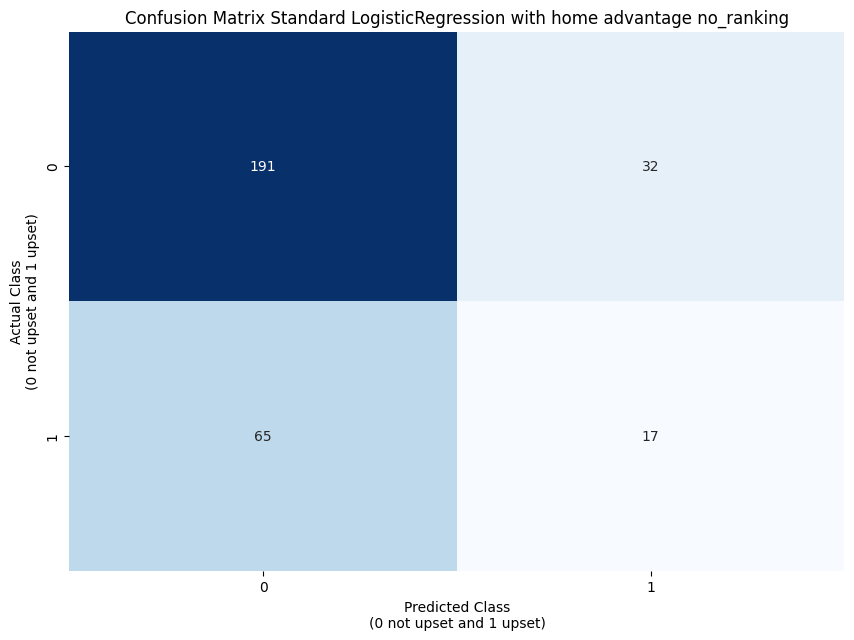

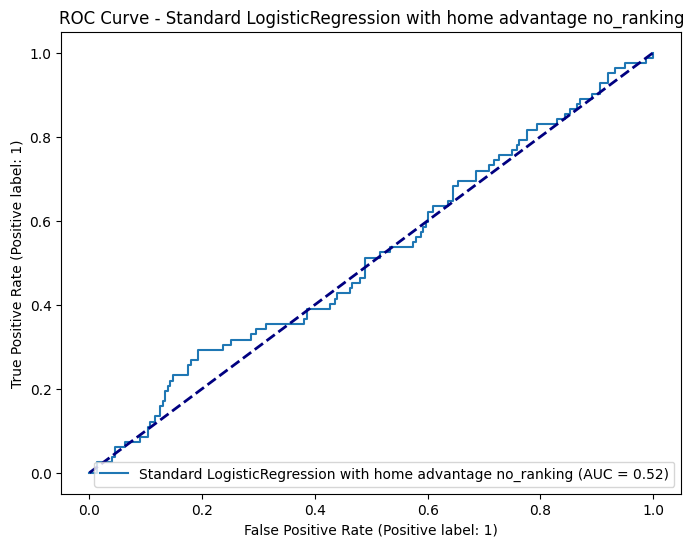

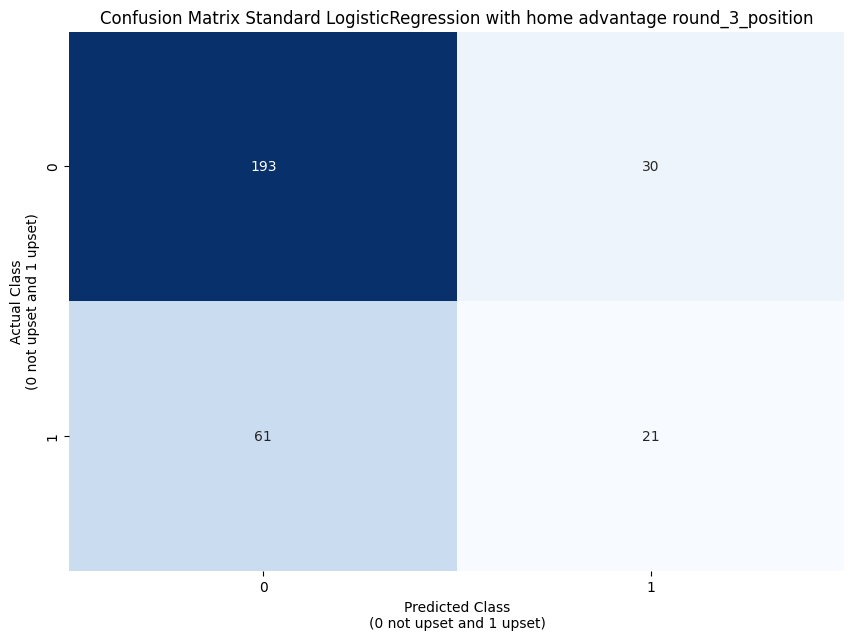

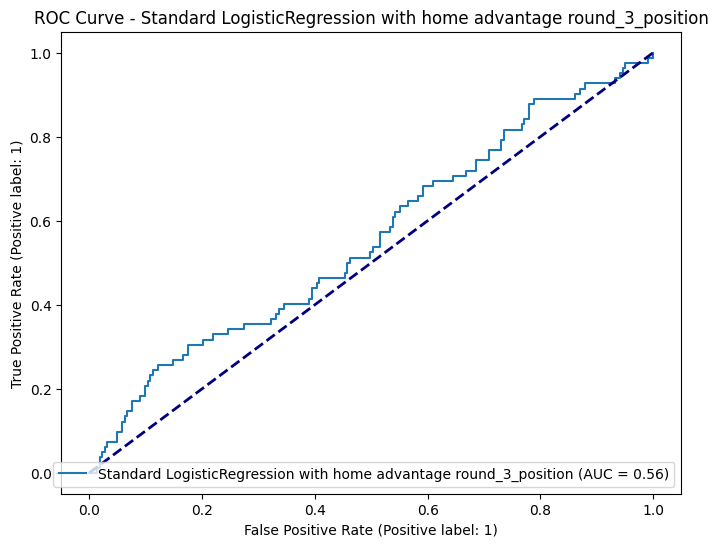

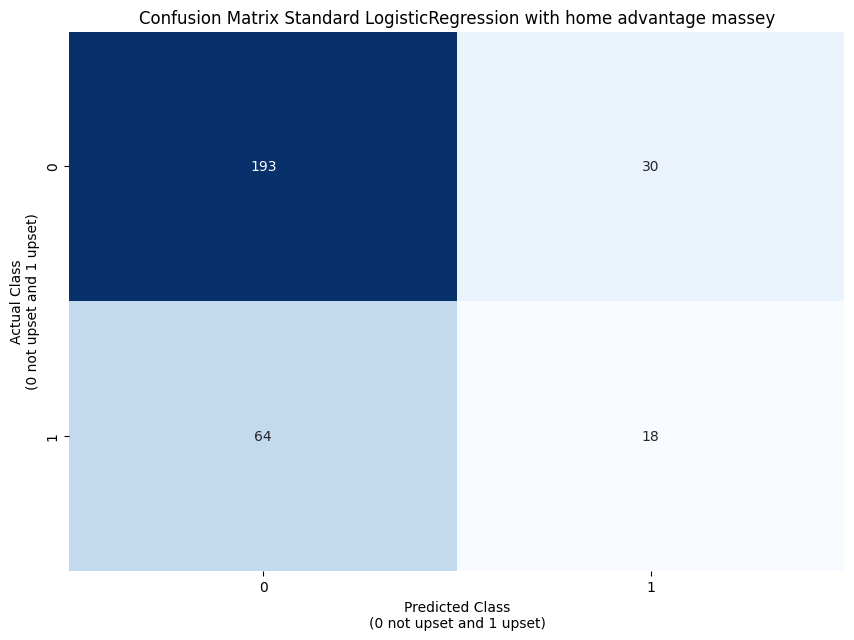

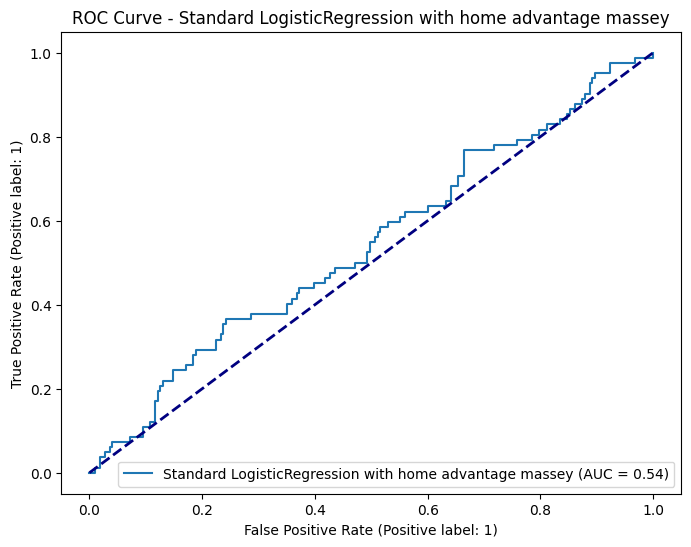

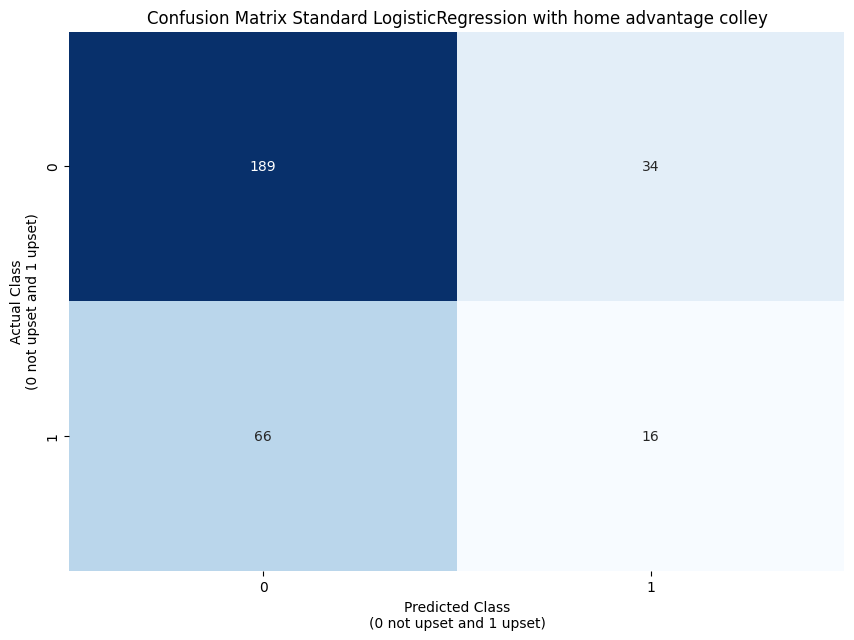

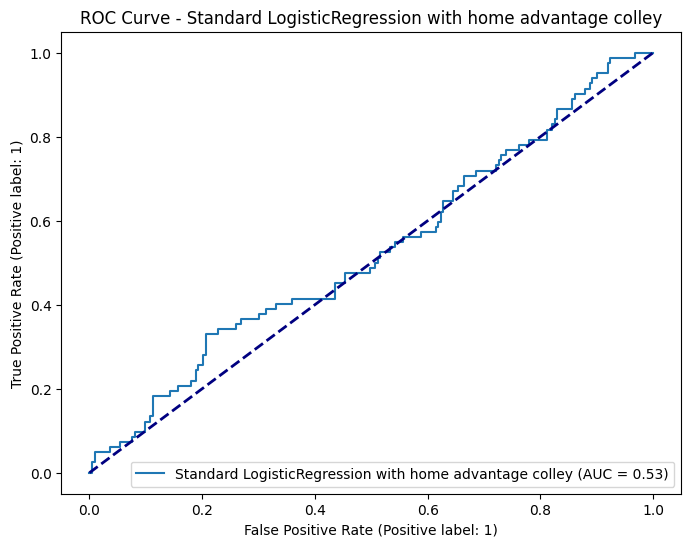

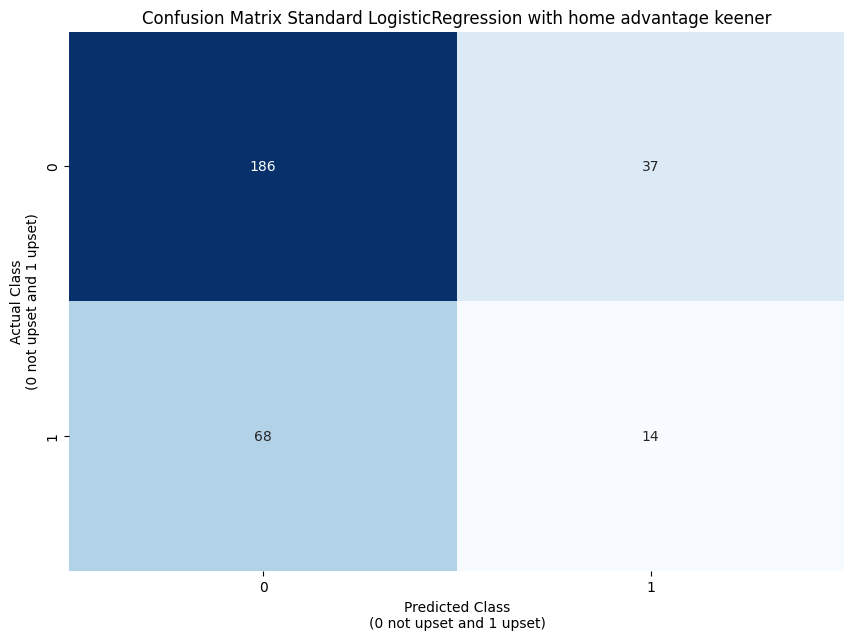

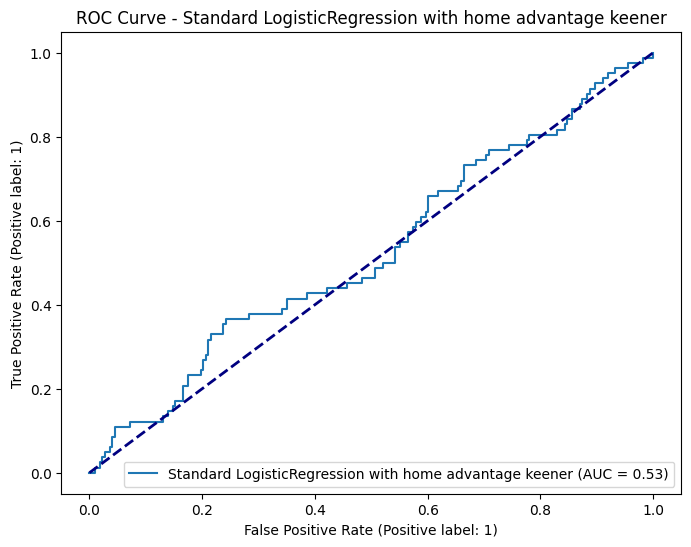

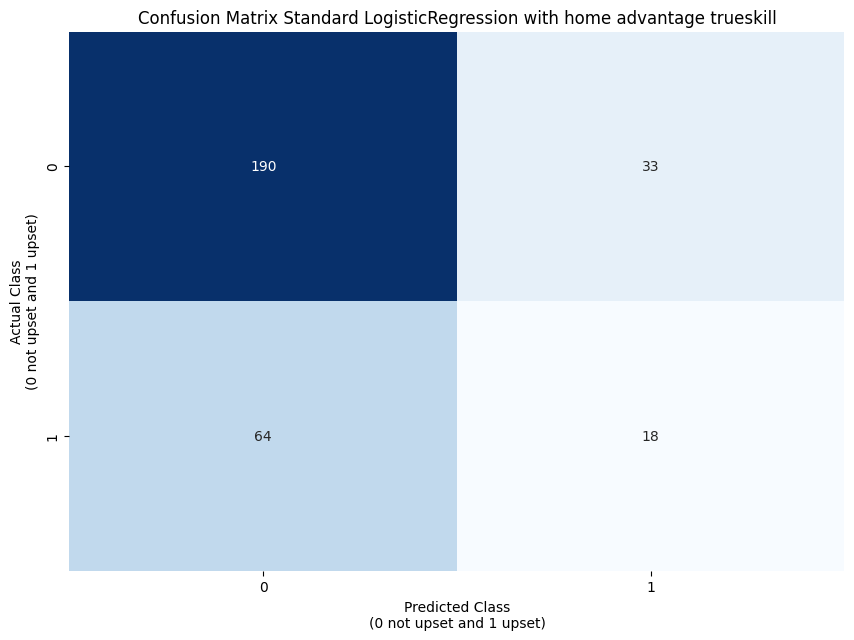

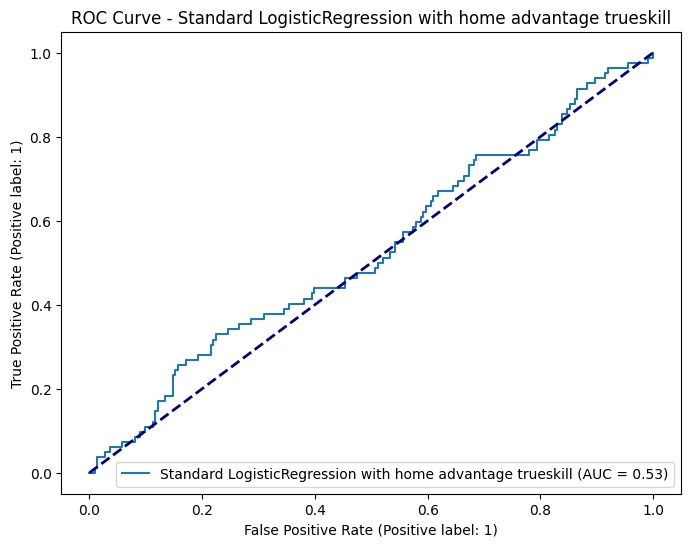

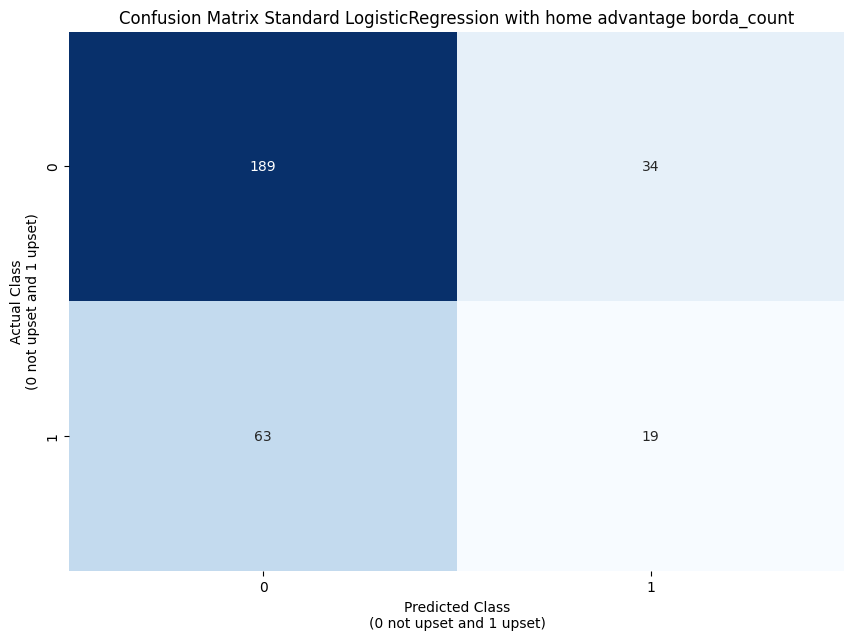

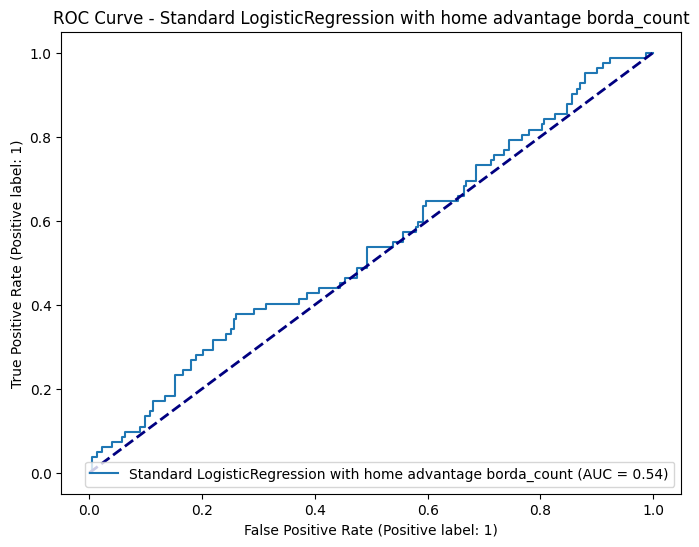

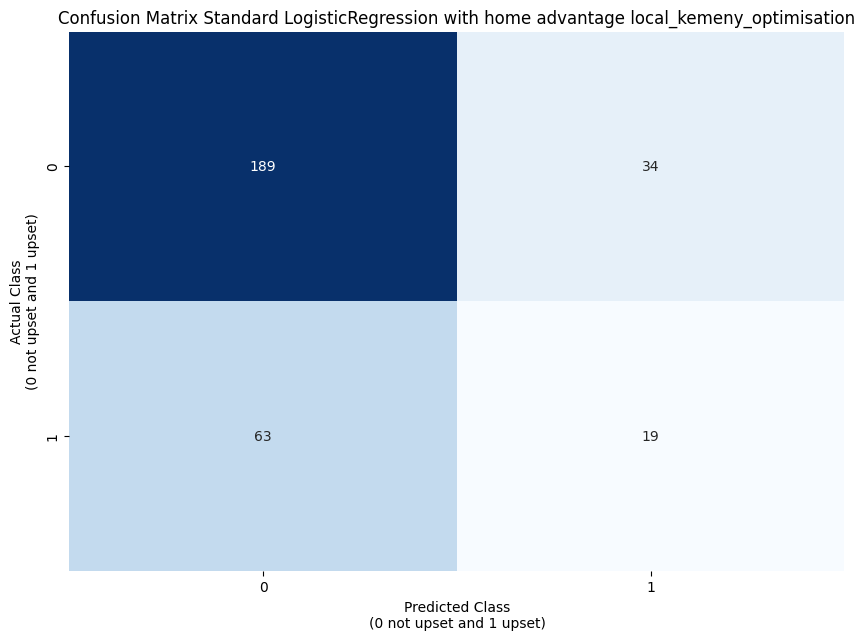

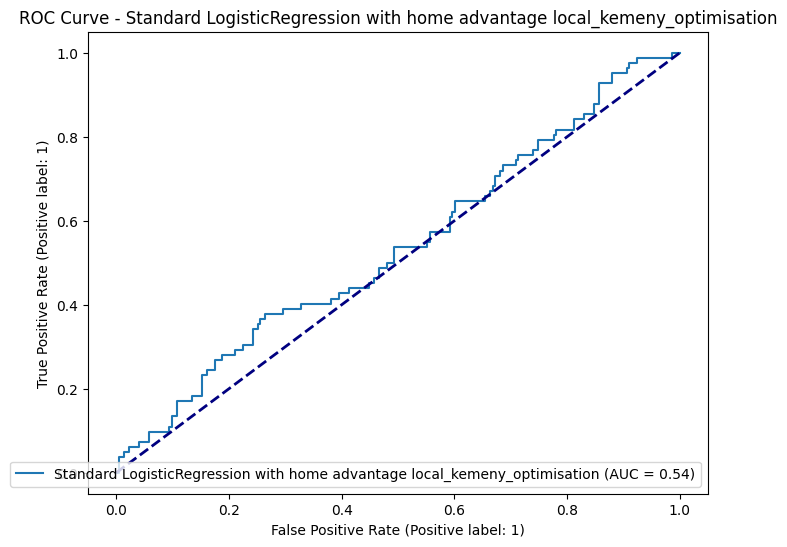

In [12]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slrh = all_results_df
display(all_results_df_slrh)

fold_results_df_slrh = fold_results_df
display(fold_results_df_slrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slrh.to_excel("all_slrh_results.xlsx")
fold_results_df_slrh.to_excel("fold_results_slrh.xlsx")

Weighted LogisticRegression no_ranking
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.721
Fold 1 Recall: 0.188
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.409
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.250
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 3 Accuracy: 0.607
Fold 3 Recall: 0.188
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.395
Fold 4 Accuracy: 0.672
Fold 4 Recall: 0.118
Weights

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Weighted LogisticRegression no_ranking  \
0                                   0.672   
1                                   0.045   
2                                   0.184   
3                                   0.042   
4                                   0.672   
5                                 190.000   
6                                  33.000   
7                                  67.000   
8                                  15.000   
9                                   0.739   
10                                  0.852   
11                                  0.792   
12                                  0.312   
13                                  0.183   
14                                  0.231   
15                                  0.526   
16                                  0.517   
17                                  0.511   
18                                  0.625   
19                                  0.672   
20                                  0.641   
21                                  0.536   

   Weighted LogisticRegression round_3_position  \
0                                         0.698   
1                                         0.037   
2                                         0.257   
3                                         0.029   
4                                         0.698   
5                                       192.000   
6                                        31.000   
7                                        61.000   
8                                        21.000   
9                                         0.759   
10                                        0.861   
11                                        0.807   
12                                        0.404   
13                                        0.256   
14                                        0.313   
15                                        0.581   
16                                        0.559   
17                                        0.560   
18                                        0.663   
19                                        0.698   
20                                        0.674   
21                                        0.576   

   Weighted LogisticRegression massey Weighted LogisticRegression colley  \
0                               0.689                              0.669   
1                               0.033                              0.062   
2                               0.208                              0.196   
3                               0.034   

Model Name Ranking  Fold  \
0              Weighted LogisticRegression no_ranking     1   
1              Weighted LogisticRegression no_ranking     2   
2              Weighted LogisticRegression no_ranking     3   
3              Weighted LogisticRegression no_ranking     4   
4              Weighted LogisticRegression no_ranking     5   
5        Weighted LogisticRegression round_3_position     1   
6        Weighted LogisticRegression round_3_position     2   
7        Weighted LogisticRegression round_3_position     3   
8        Weighted LogisticRegression round_3_position     4   
9        Weighted LogisticRegression round_3_position     5   
10                 Weighted LogisticRegression massey     1   
11                 Weighted LogisticRegression massey     2   
12                 Weighted LogisticRegression massey     3   
13                 Weighted LogisticRegression massey     4   
14                 Weighted LogisticRegression massey     5   
15                 Weighted LogisticRegression colley     1   
16                 Weighted LogisticRegression colley     2   
17                 Weighted LogisticRegression colley     3   
18                 Weighted LogisticRegression colley     4   
19                 Weighted LogisticRegression colley     5   
20                 Weighted LogisticRegression keener     1   
21                 Weighted LogisticRegression keener     2   
22                 Weighted LogisticRegression keener     3   
23                 Weighted LogisticRegression keener     4   
24                 Weighted LogisticRegression keener     5   
25              Weighted LogisticRegression trueskill     1   
26              Weighted LogisticRegression trueskill     2   
27              Weighted LogisticRegression trueskill     3   
28              Weighted LogisticRegression trueskill     4   
29              Weighted LogisticRegression trueskill     5   
30            Weighted LogisticRegression borda_count     1   
31            Weighted LogisticRegression borda_count     2   
32            Weighted LogisticRegression borda_count     3   
33            Weighted LogisticRegression borda_count     4   
34            Weighted LogisticRegression borda_count     5   
35  Weighted LogisticRegression local_kemeny_optim...     1   
36  Weighted LogisticRegression local_kemeny_optim...     2   
37  Weighted LogisticRegression local_kemeny_optim...     3   
38  Weighted LogisticRegression local_kemeny_optim...     4   
39  Weighted LogisticRegression local_kemeny_optim...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 1.0, 'classifier__penalty': ...   
1   {'classifier__C': 100.0, 'classifier__penalty'...   
2   {'classifier__C': 1.0, 'classifier__penalty': ...   
3   {'classifier__C': 0.09999999999999999, 'classi...   
4   {'classifier__C': 10.0, 'classifier__penalty':...   
5   {'classifier__C': 10.0, 'classifier__penalty':...   
6   {'classifier__C': 1.0, 'classifier__penalty': ...   
7   {'classifier__C': 1.0, 'classifier__penalty': ...   
8   {'classifier__C': 0.09999999999999999, 'classi...   
9   {'classifier__C': 10.0, 'classifier__penalty':...   
10  {'classifier__C': 10.0, 'classifier__penalty':...   
11  {'classifier__C': 10.0, 'classifier__penalty':...   
12  {'classifier__C': 1.0, 'classifier__penalty': ...   
13  {'classifier__C': 0.09999999999999999, 'classi...   
14  {'classifier__C': 10.0, 'classifier__penalty':...   
15  {'classifier__C': 1.0, 'classifier__penalty': ...   
16  {'classifier__C': 1.0, 'classifier__penalty': ...   
17  {'classifier__C': 1.0, 'classifier__penalty': ...   
18  {'classifier__C': 0.09999999999999999, 'classi...   
19  {'classifier__C': 1.0, 'classifier__penalty': ...   
20  {'classifier__C': 10.0, 'classifier__penalty':...   
21  {'classifier__C': 1.0, 'classifier__penalty': ...   
22  {'classifier__C': 1.0, 'classifier__penalty': ...   
23  {'classifier__C': 1.0, 'classifier__penalty': ...   
24  {'classifier__C': 10.0

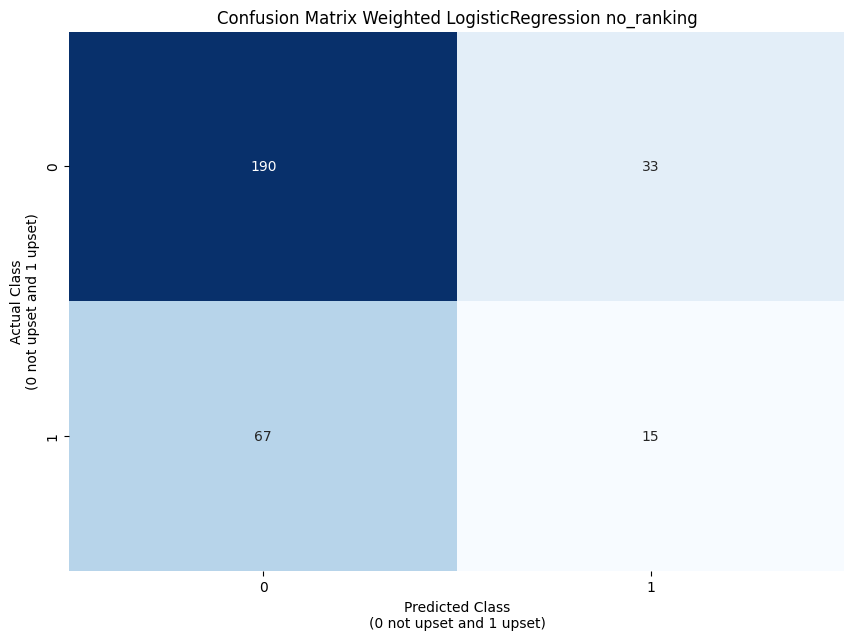

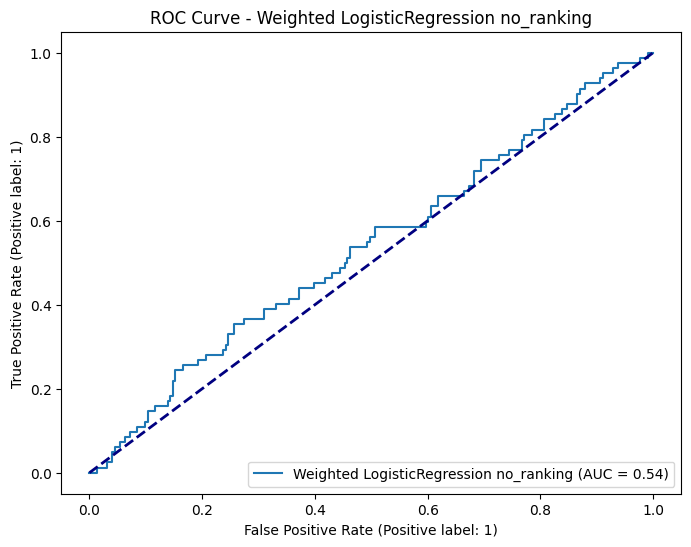

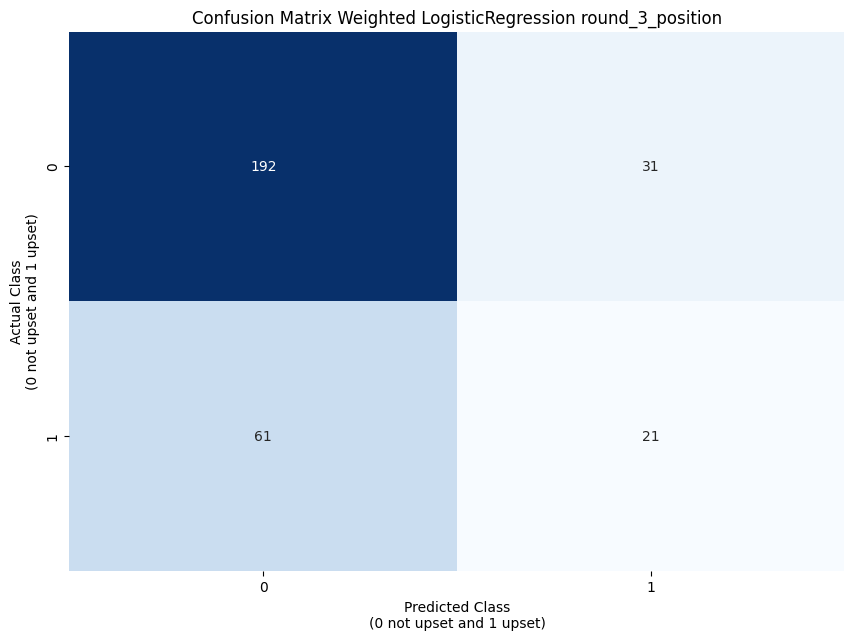

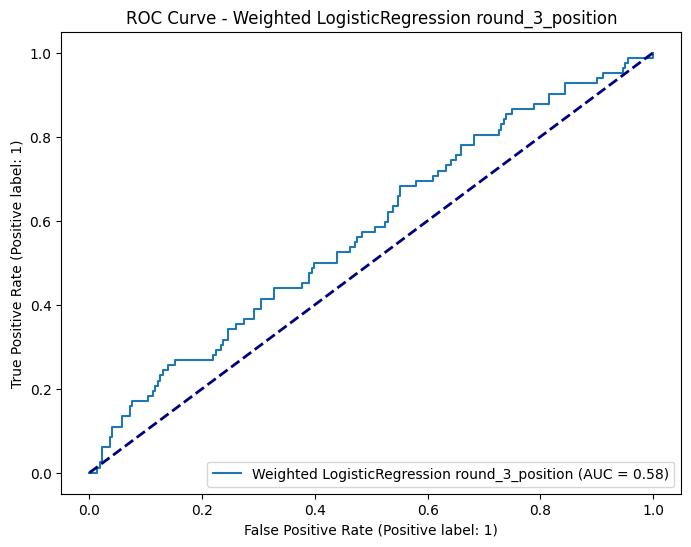

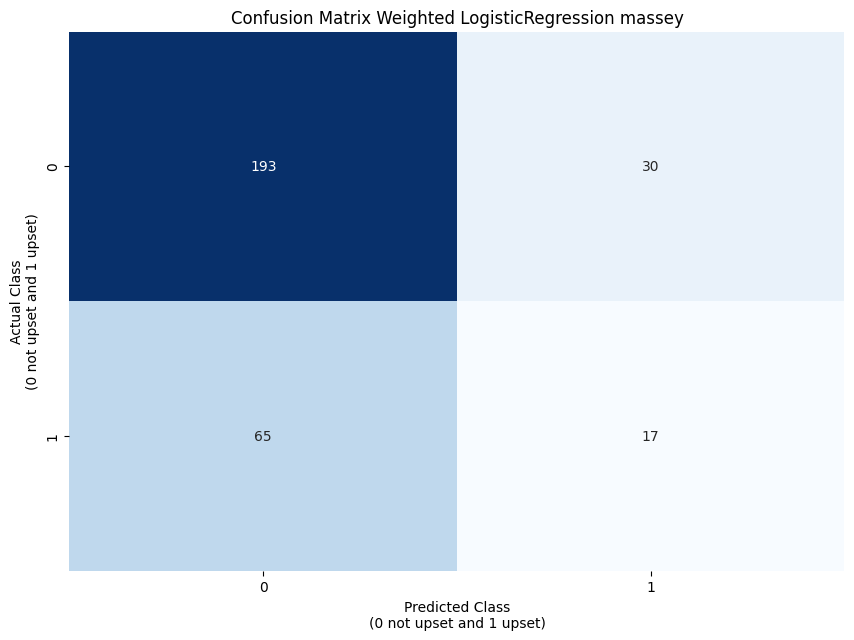

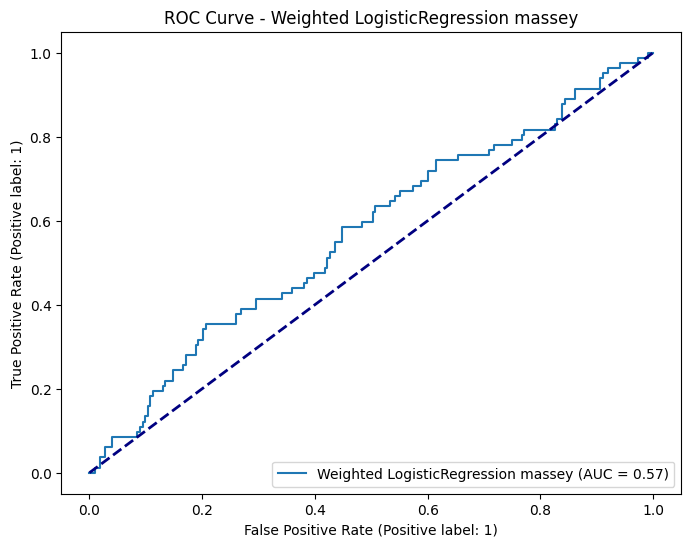

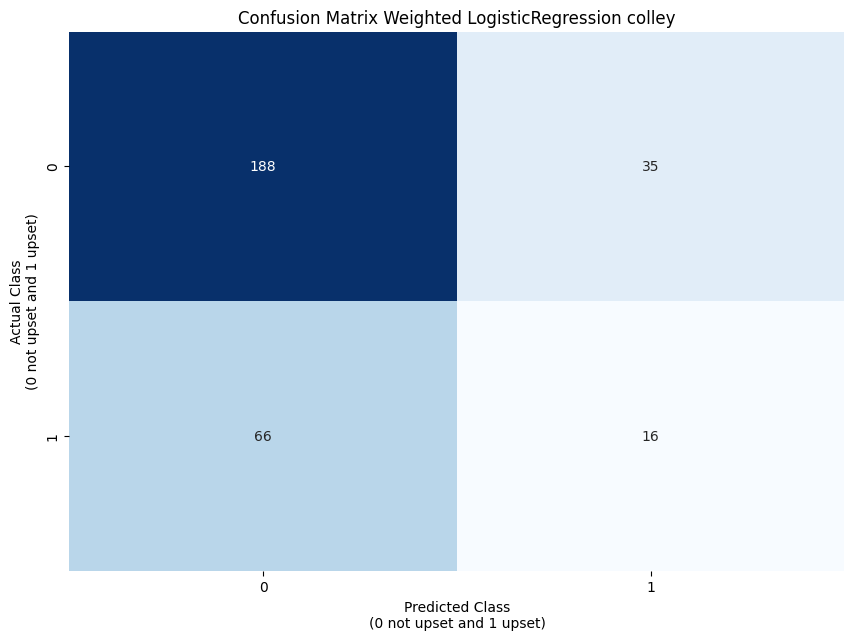

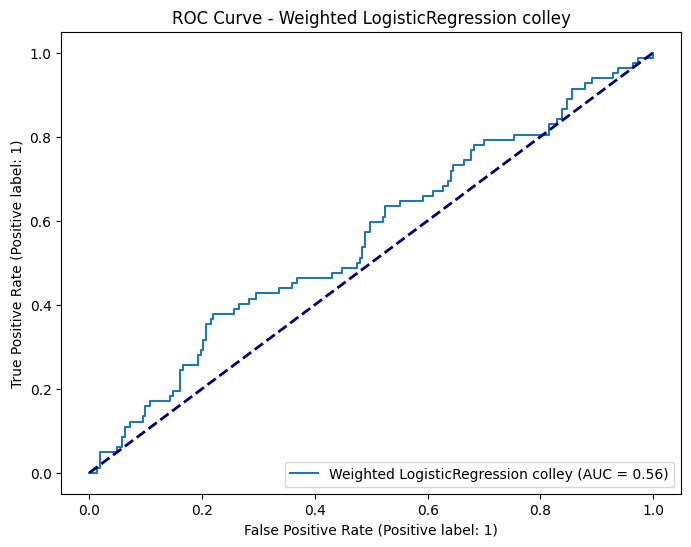

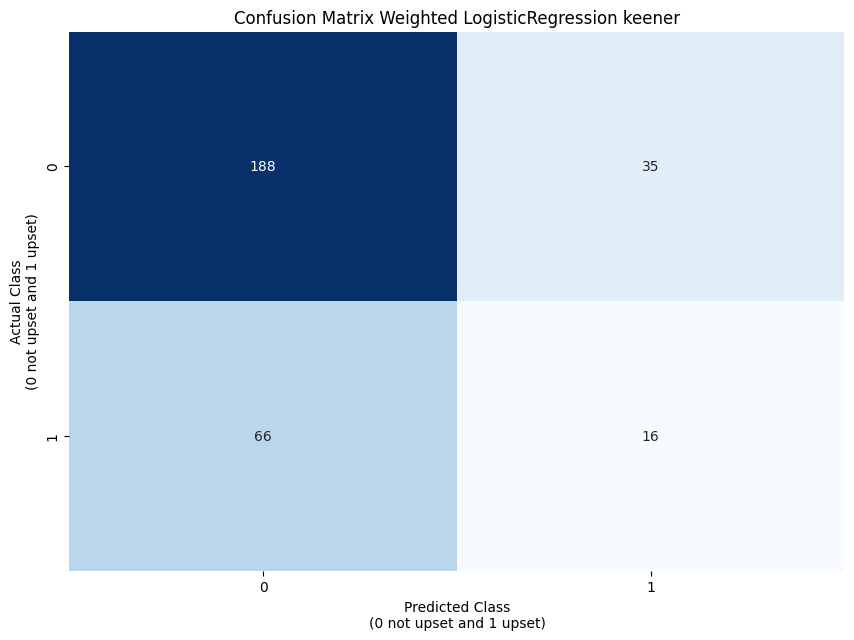

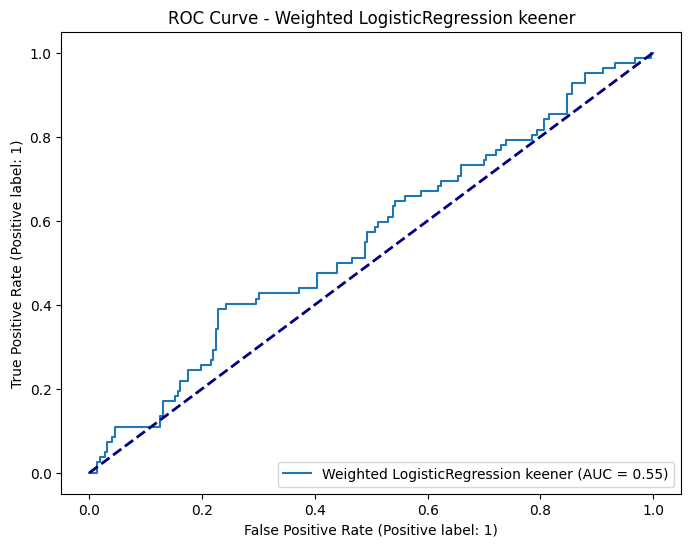

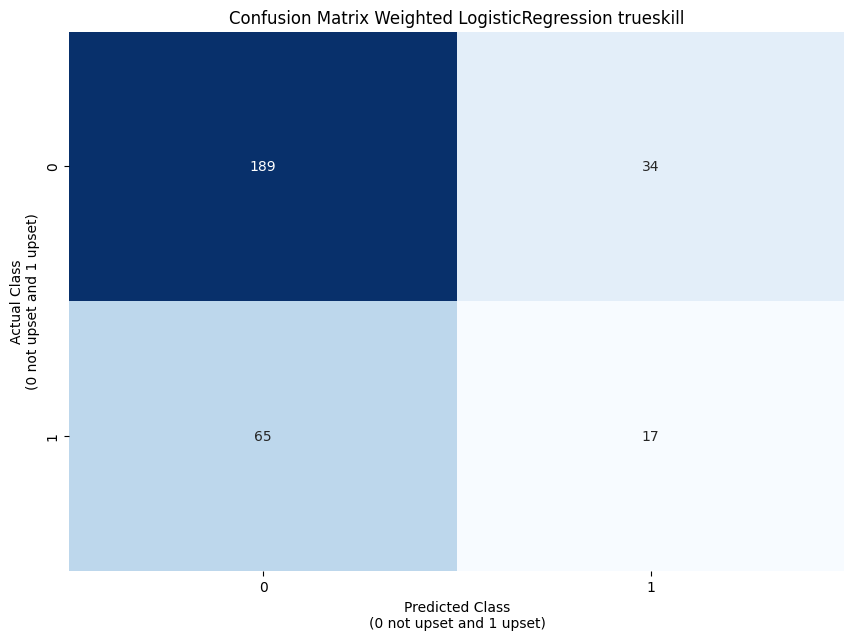

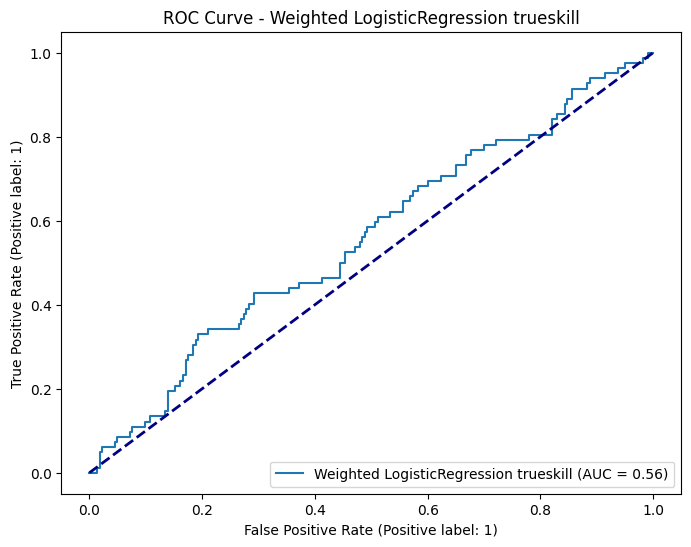

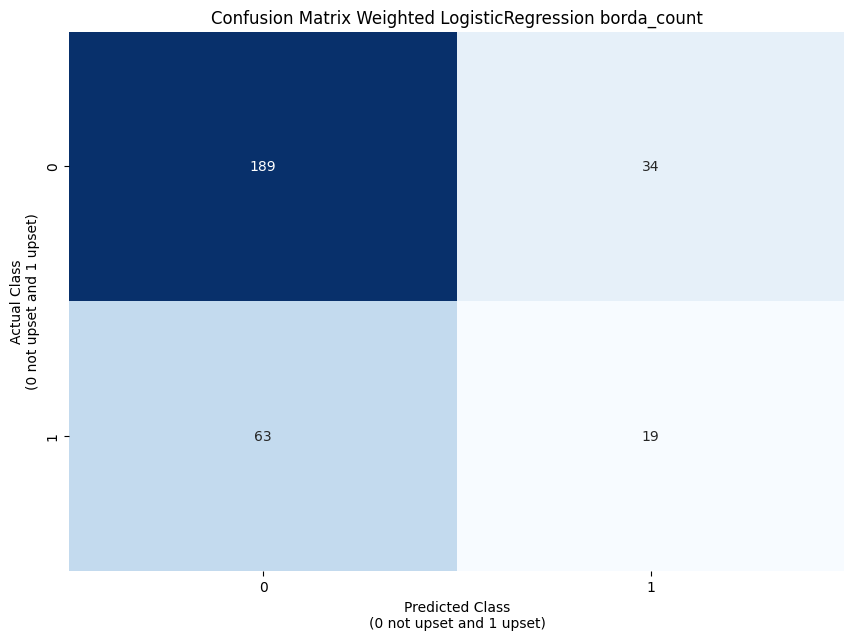

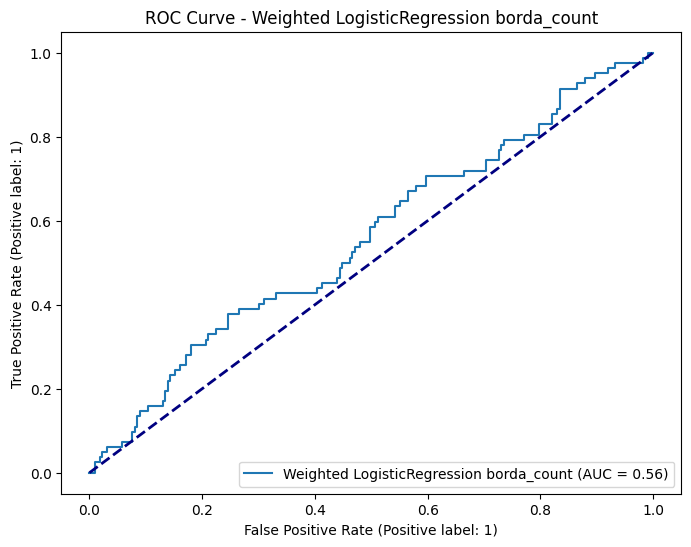

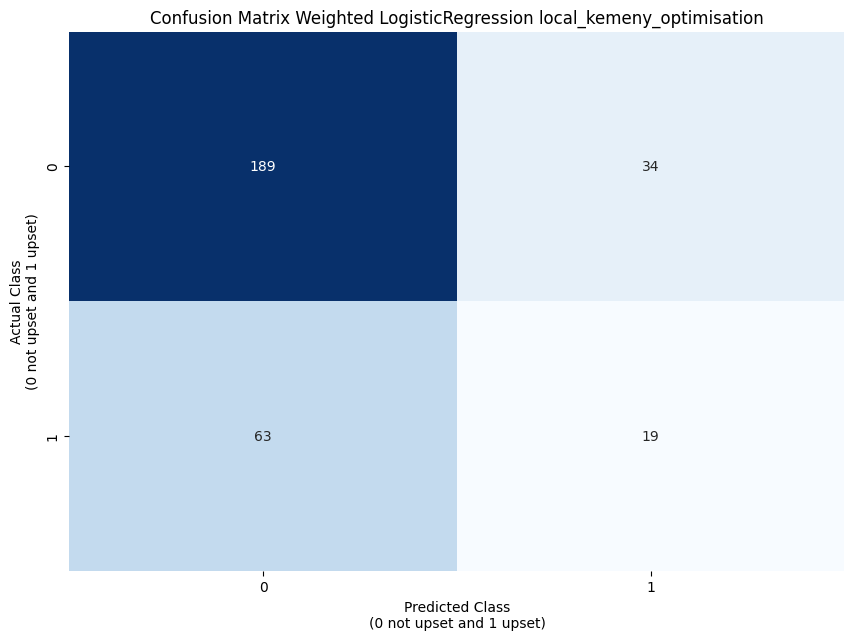

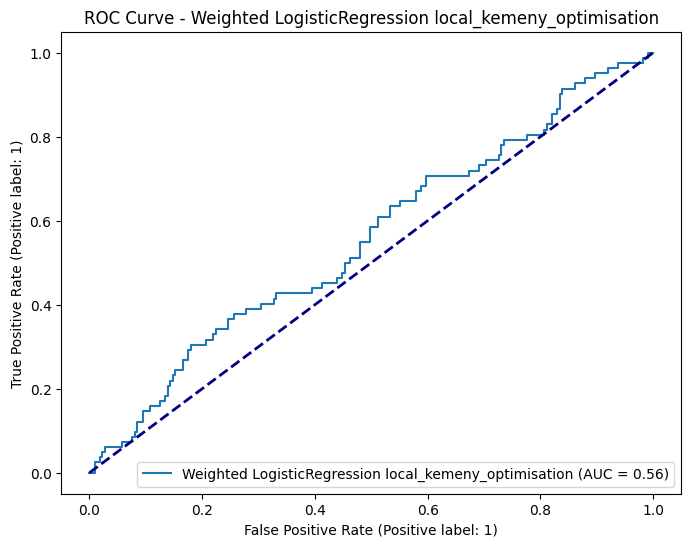

In [13]:
0# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
home_advt = 'no'
weighted = 'yes'
random_state = 47
weights = {0: 50, 1: 50} # intial value before recalauclating
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlr = all_results_df
display(all_results_df_wlr)

fold_results_df_wlr = fold_results_df
display(fold_results_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results.xlsx")
fold_results_df_wlr.to_excel("fold_results_wlr.xlsx")

Weighted LogisticRegression with home advantage no_ranking
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.485
Fold 1 Accuracy: 0.689
Fold 1 Recall: 0.125
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.455
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.250
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 3 Accuracy: 0.639
Fold 3 Recall: 0.250
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.443
Fold 4 Accuracy: 0.705
Fold 4 Rec

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Weighted LogisticRegression with home advantage no_ranking  \
0                                               0.675           
1                                               0.030           
2                                               0.196           
3                                               0.061           
4                                               0.675           
5                                             190.000           
6                                              33.000           
7                                              66.000           
8                                              16.000           
9                                               0.742           
10                                              0.852           
11                                              0.793           
12                                              0.327           
13                                              0.195           
14                                              0.244           
15                                              0.534           
16                                              0.524           
17                                              0.519           
18                                              0.630           
19                                              0.675           
20                                              0.646           
21                                              0.524           

   Weighted LogisticRegression with home advantage round_3_position  \
0                                               0.695                 
1                                               0.032                 
2                                               0.268                 
3                                               0.030                 
4                                               0.695                 
5                                             190.000                 
6                                              33.000                 
7                                              60.000                 
8                                              22.000                 
9                                               0.760                 
10                                              0.852                 
11                                              0.803                 
12                                              0.400                 
13                                              0.268           

Model Name Ranking  Fold  \
0   Weighted LogisticRegression with home advantag...     1   
1   Weighted LogisticRegression with home advantag...     2   
2   Weighted LogisticRegression with home advantag...     3   
3   Weighted LogisticRegression with home advantag...     4   
4   Weighted LogisticRegression with home advantag...     5   
5   Weighted LogisticRegression with home advantag...     1   
6   Weighted LogisticRegression with home advantag...     2   
7   Weighted LogisticRegression with home advantag...     3   
8   Weighted LogisticRegression with home advantag...     4   
9   Weighted LogisticRegression with home advantag...     5   
10  Weighted LogisticRegression with home advantag...     1   
11  Weighted LogisticRegression with home advantag...     2   
12  Weighted LogisticRegression with home advantag...     3   
13  Weighted LogisticRegression with home advantag...     4   
14  Weighted LogisticRegression with home advantag...     5   
15  Weighted LogisticRegression with home advantag...     1   
16  Weighted LogisticRegression with home advantag...     2   
17  Weighted LogisticRegression with home advantag...     3   
18  Weighted LogisticRegression with home advantag...     4   
19  Weighted LogisticRegression with home advantag...     5   
20  Weighted LogisticRegression with home advantag...     1   
21  Weighted LogisticRegression with home advantag...     2   
22  Weighted LogisticRegression with home advantag...     3   
23  Weighted LogisticRegression with home advantag...     4   
24  Weighted LogisticRegression with home advantag...     5   
25  Weighted LogisticRegression with home advantag...     1   
26  Weighted LogisticRegression with home advantag...     2   
27  Weighted LogisticRegression with home advantag...     3   
28  Weighted LogisticRegression with home advantag...     4   
29  Weighted LogisticRegression with home advantag...     5   
30  Weighted LogisticRegression with home advantag...     1   
31  Weighted LogisticRegression with home advantag...     2   
32  Weighted LogisticRegression with home advantag...     3   
33  Weighted LogisticRegression with home advantag...     4   
34  Weighted LogisticRegression with home advantag...     5   
35  Weighted LogisticRegression with home advantag...     1   
36  Weighted LogisticRegression with home advantag...     2   
37  Weighted LogisticRegression with home advantag...     3   
38  Weighted LogisticRegression with home advantag...     4   
39  Weighted LogisticRegression with home advantag...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 1.0, 'classifier__penalty': ...   
1   {'classifier__C': 1.0, 'classifier__penalty': ...   
2   {'classifier__C': 1.0, 'classifier__penalty': ...   
3   {'classifier__C': 0.09999999999999999, 'classi...   
4   {'classifier__C': 1.0, 'classifier__penalty': ...   
5   {'classifier__C': 10.0, 'classifier__penalty':...   
6   {'classifier__C': 1.0, 'classifier__penalty': ...   
7   {'classifier__C': 1.0, 'classifier__penalty': ...   
8   {'classifier__C': 0.09999999999999999, 'classi...   
9   {'classifier__C': 100.0, 'classifier__penalty'...   
10  {'classifier__C': 1.0, 'classifier__penalty': ...   
11  {'classifier__C': 100.0, 'classifier__penalty'...   
12  {'classifier__C': 1.0, 'classifier__penalty': ...   
13  {'classifier__C': 0.09999999999999999, 'classi...   
14  {'classifier__C': 10.0, 'classifier__penalty':...   
15  {'classifier__C': 1.0, 'classifier__penalty': ...   
16  {'classifier__C': 1.0, 'classifier__penalty': ...   
17  {'classifier__C': 1.0, 'classifier__penalty': ...   
18  {'classifier__C': 0.09999999999999999, 'classi...   
19  {'classifier__C': 10.0, 'classifier__penalty':...   
20  {'classifier__C': 1.0, 'classifier__penalty': ...   
21  {'classifier__C': 10.0, 'classifier__penalty':...   
22  {'classifier__C': 1.0, 'classifier__penalty': ...   
23  {'classifier__C': 0.09999999999999999, 'classi...   
24  {'classifier__C': 10.0

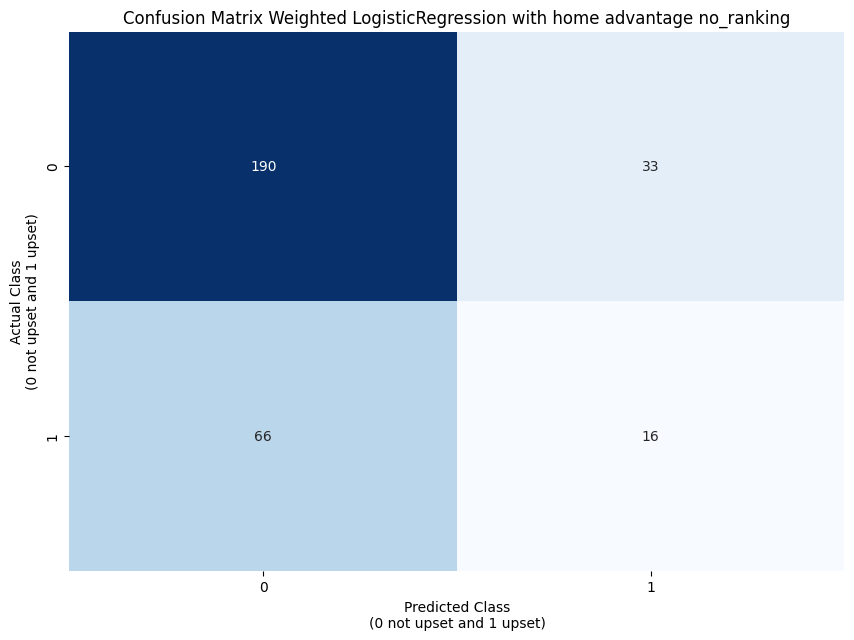

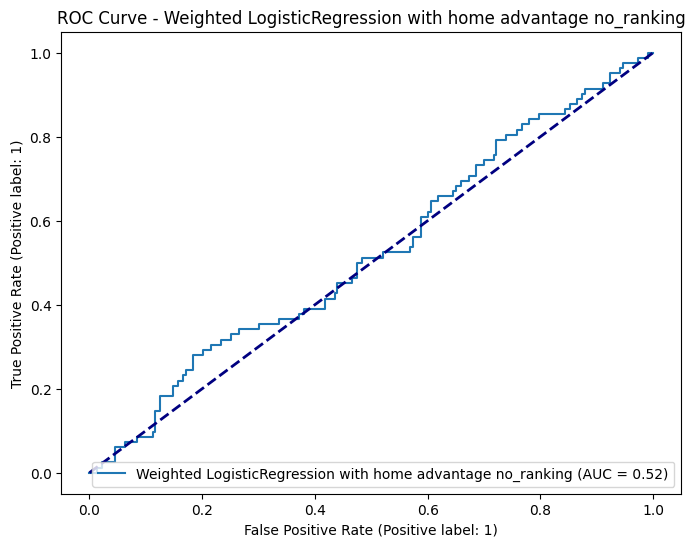

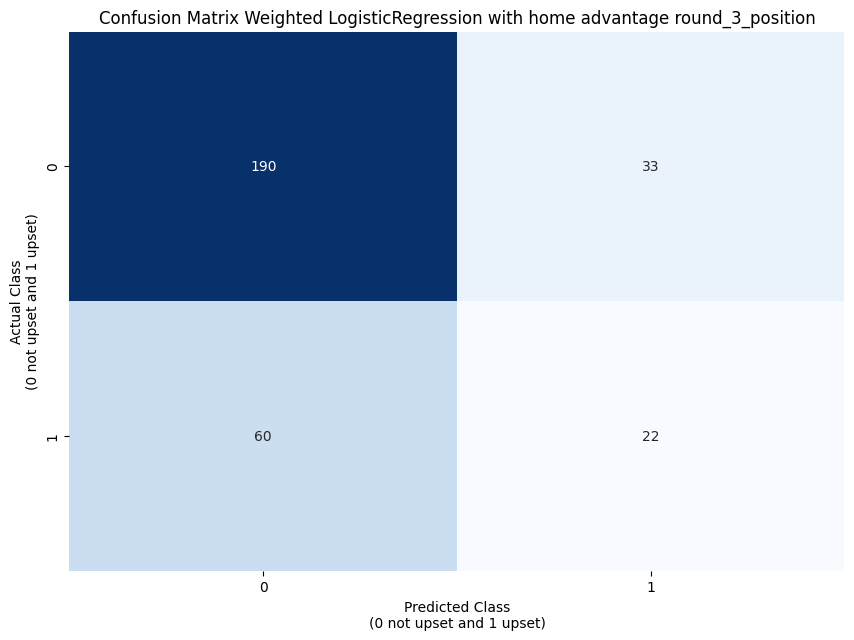

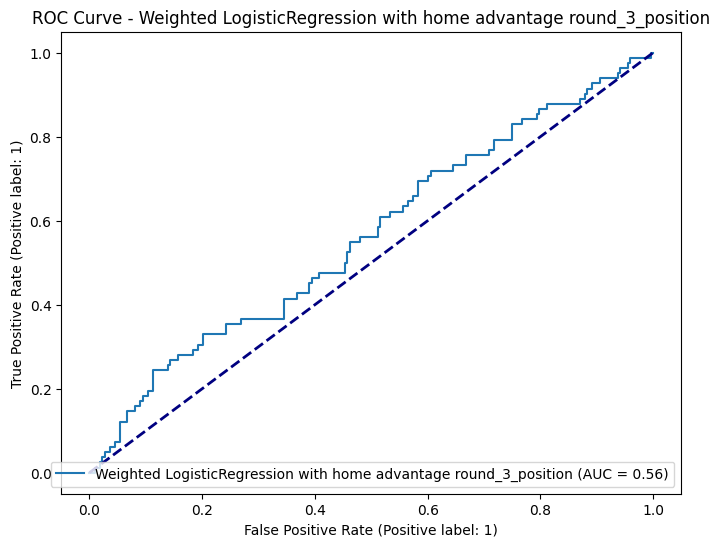

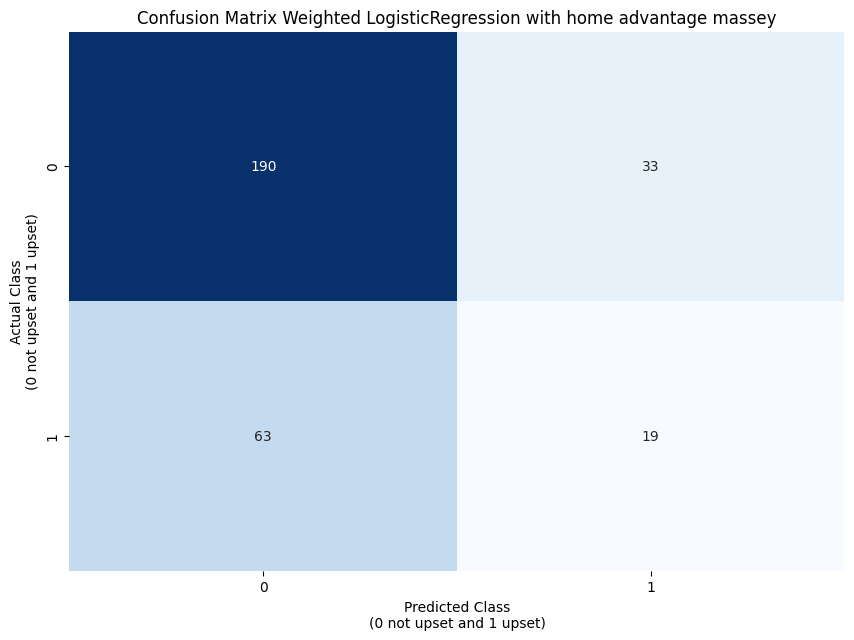

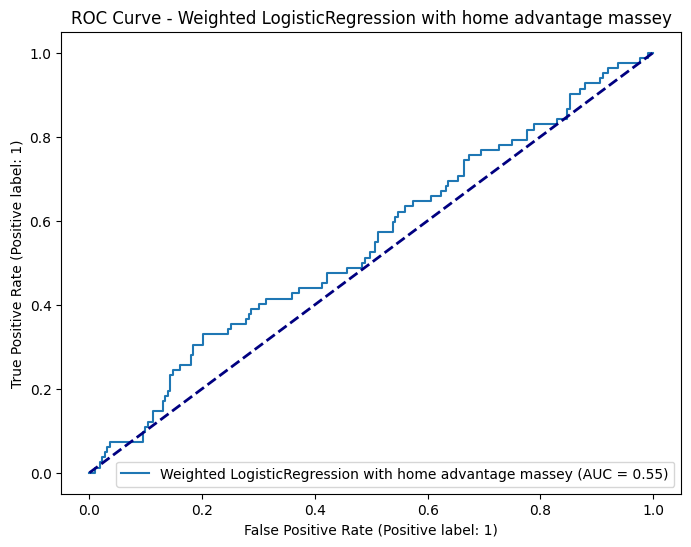

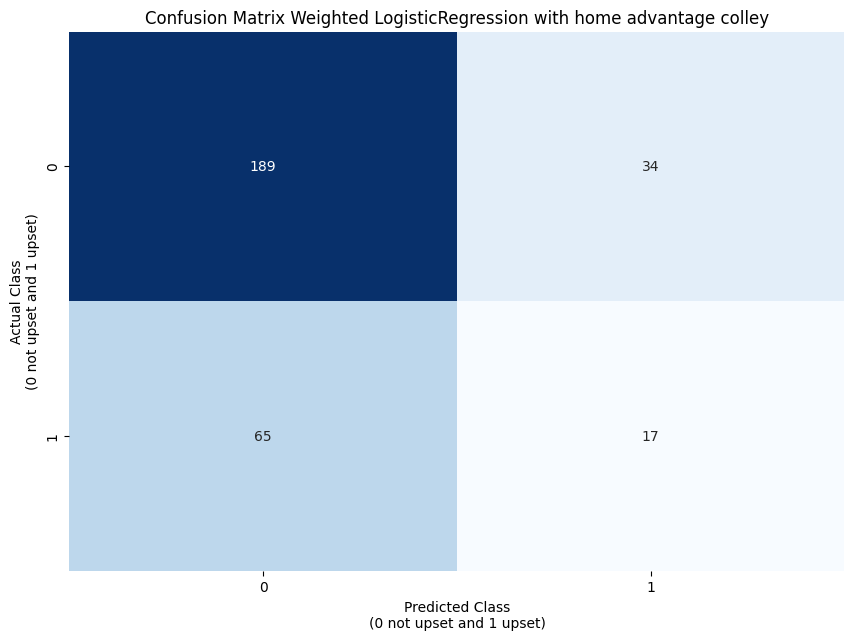

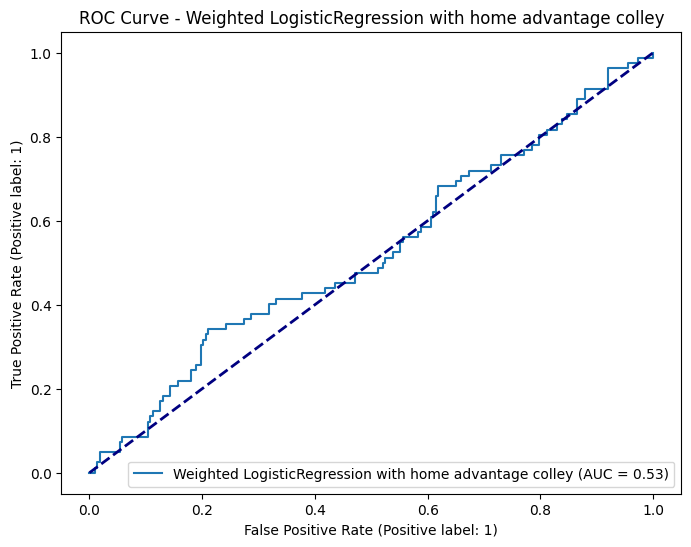

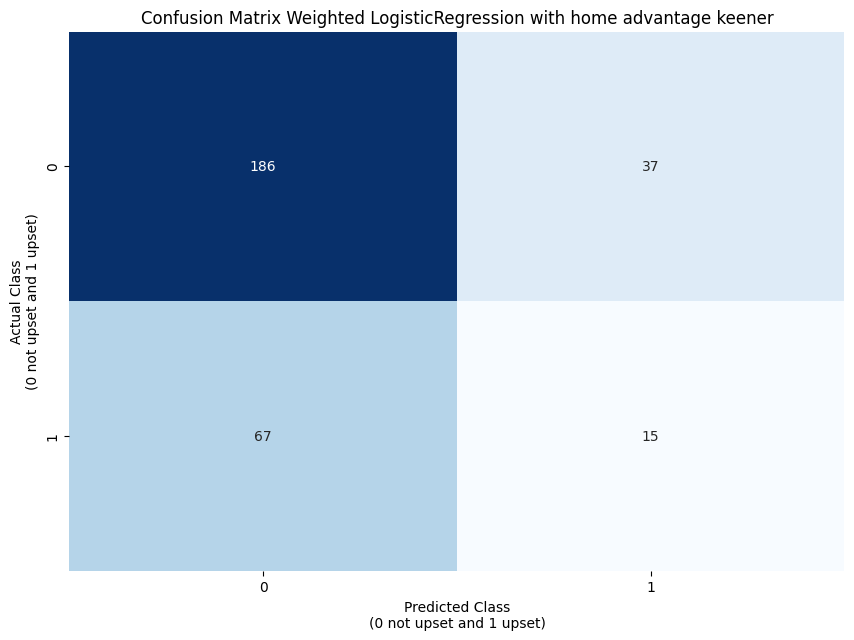

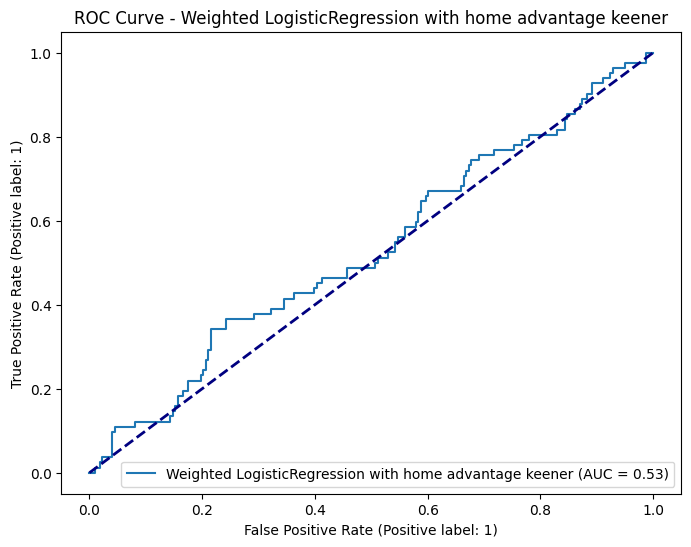

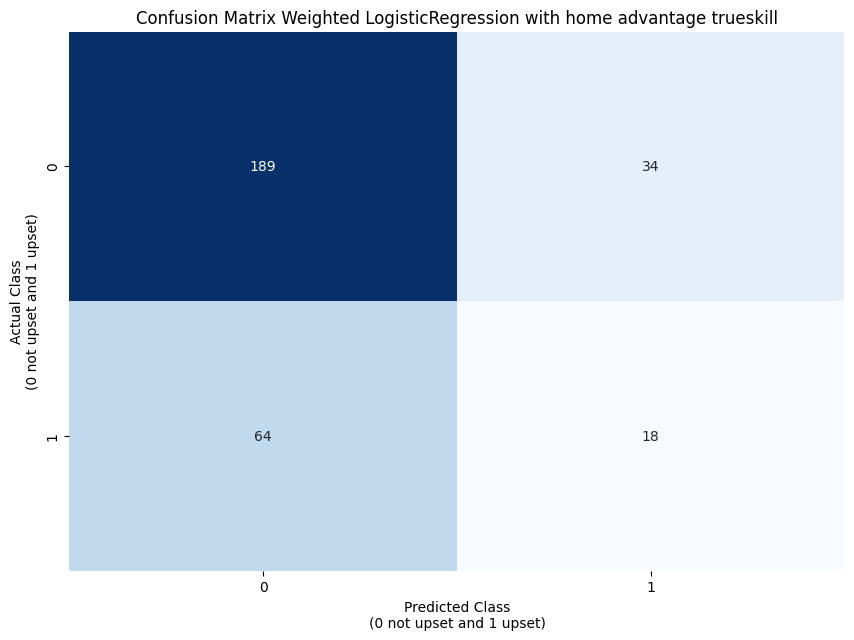

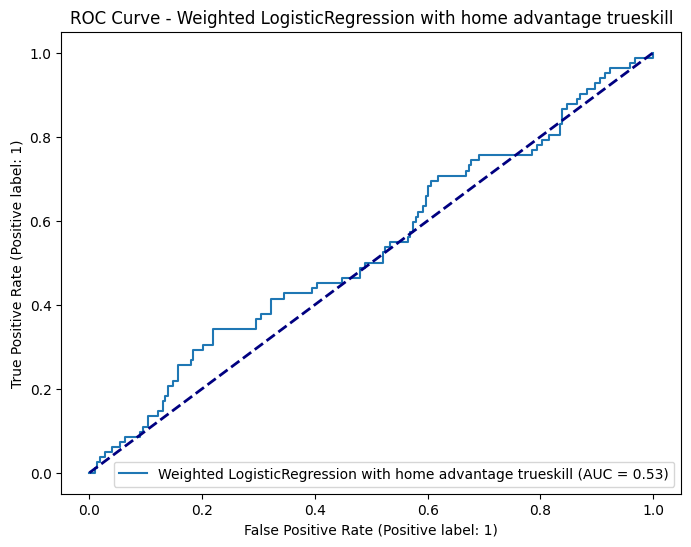

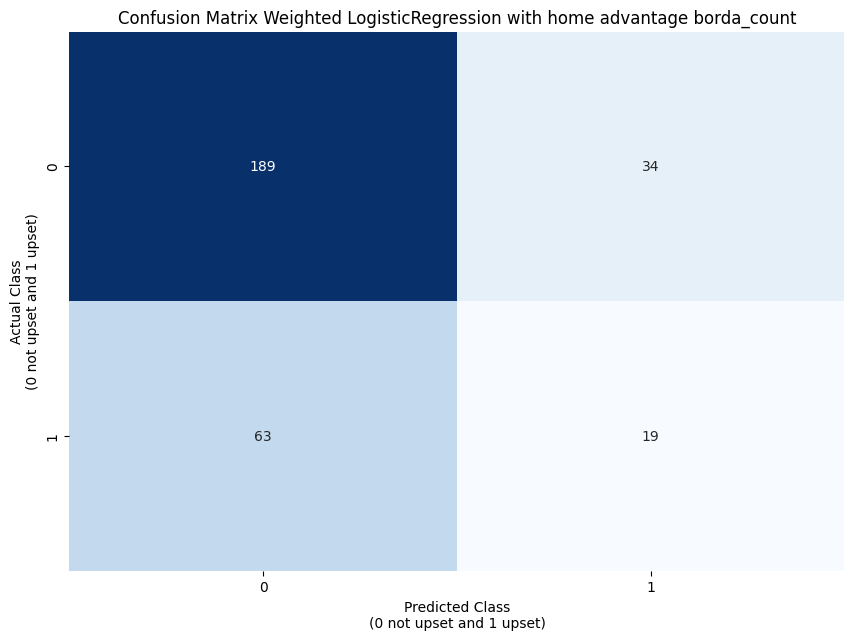

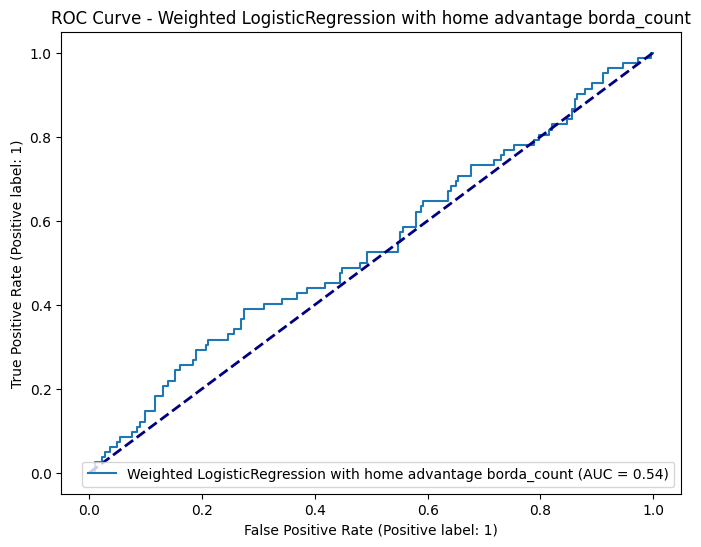

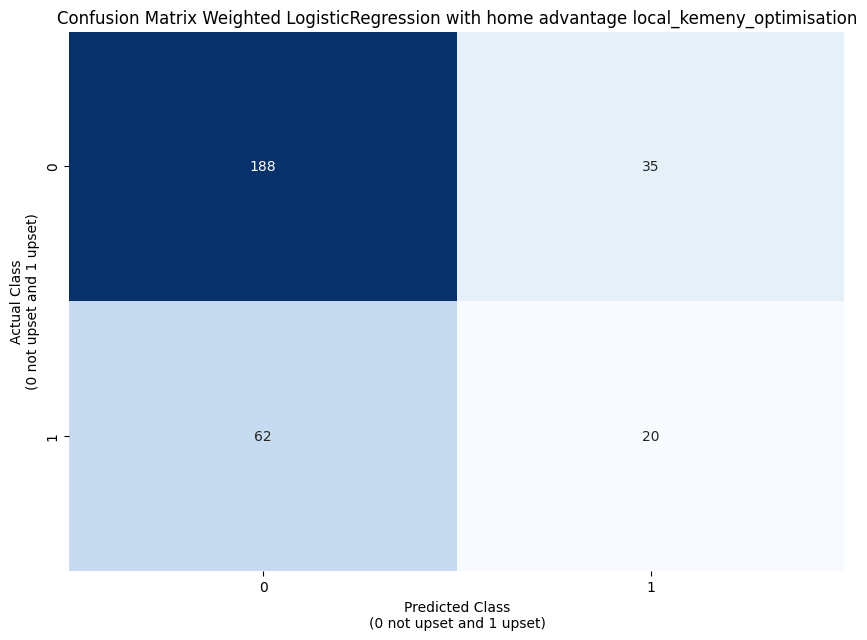

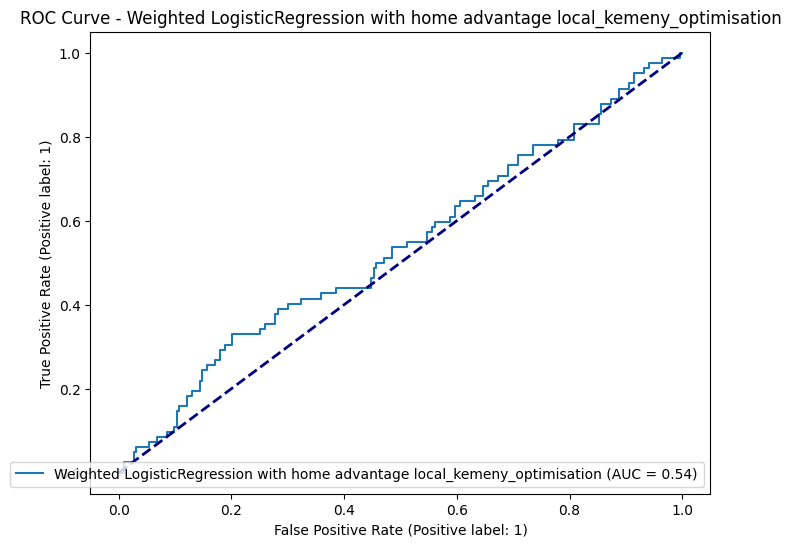

In [14]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'yes'
random_state = 47
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

fold_results_df_wlrh = fold_results_df
display(fold_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
fold_results_df_wlrh.to_excel("fold_results_wlrh.xlsx")

MLP Classifier Neural Network no_ranking
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.682
Fold 1 Accuracy: 0.984
Fold 1 Recall: 1.000
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.758
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.727
Fold 3 Accuracy: 0.902
Fold 3 Recall: 0.812
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.693
Fold 4 Accuracy: 1.000
Fold 4 Recall: 1.000
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.741
Fold 5 Accuracy: 0.967
Fold 5 Recall: 0.882
Average Accuracy: 0.856
Average Recall: 0.764
MLP Classifier Neural Network massey
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.727
Fold 1 Accuracy: 0.984
Fold 1 Recall: 1.000
Best parameters: {'classifi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.568
Fold 4 Accuracy: 0.918
Fold 4 Recall: 0.706
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.710
Fold 5 Accuracy: 0.721
Fold 5 Recall: 0.000
Average Accuracy: 0.869
Average Recall: 0.529
MLP Classifier Neural Network colley


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.667
Fold 1 Accuracy: 0.984
Fold 1 Recall: 1.000
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.621
Fold 2 Accuracy: 0.967
Fold 2 Recall: 0.875
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.576
Fold 3 Accuracy: 0.738
Fold 3 Recall: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.554
Fold 4 Accuracy: 0.967
Fold 4 Recall: 0.882
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.694
Fold 5 Accuracy: 0.721
Fold 5 Recall: 0.000
Average Accuracy: 0.875
Average Recall: 0.551
MLP Classifier Neural Network keener


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.682
Fold 1 Accuracy: 0.951
Fold 1 Recall: 0.938
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.621
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.606
Fold 3 Accuracy: 0.967
Fold 3 Recall: 0.875
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.652
Fold 1 Accuracy: 0.951
Fold 1 Recall: 0.875
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.652
Fold 2 Accuracy: 0.967
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.636
Fold 3 Accuracy: 0.934
Fold 3 Recall: 0.750
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_r

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.727
Fold 1 Accuracy: 0.984
Fold 1 Recall: 1.000
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.636
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 3 Accuracy: 0.951
Fold 3 Recall: 0.812
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learni

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.697
Fold 1 Accuracy: 0.984
Fold 1 Recall: 1.000
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.621
Fold 2 Accuracy: 0.934
Fold 2 Recall: 0.812
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 3 Accuracy: 0.951
Fold 3 Recall: 0.812
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learni

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   MLP Classifier Neural Network no_ranking  \
0                                     0.964   
1                                     0.035   
2                                     0.926   
3                                     0.072   
4                                     0.964   
5                                   218.000   
6                                     5.000   
7                                     6.000   
8                                    76.000   
9                                     0.973   
10                                    0.978   
11                                    0.975   
12                                    0.938   
13                                    0.927   
14                                    0.933   
15                                    0.956   
16                                    0.952   
17                                    0.954   
18                                    0.964   
19                                    0.964   
20                                    0.964   
21                                    0.974   

   MLP Classifier Neural Network round_3_position  \
0                                           0.856   
1                                           0.164   
2                                           0.764   
3                                           0.384   
4                                           0.856   
5                                         198.000   
6                                          25.000   
7                                          19.000   
8                                          63.000   
9                                           0.912   
10                                          0.888   
11                                          0.900   
12                                          0.716   
13                                          0.768   
14                                          0.741   
15                                          0.814   
16                                          0.828   
17                                          0.821   
18                                          0.860   
19                                          0.856   
20                                          0.857   
21                                          0.932   

   MLP Classifier Neural Network massey MLP Classifier Neural Network colley  \
0                                 0.869                                0.875   
1                                 0.116                                0.119   
2           

Model Name Ranking  Fold  \
0            MLP Classifier Neural Network no_ranking     1   
1            MLP Classifier Neural Network no_ranking     2   
2            MLP Classifier Neural Network no_ranking     3   
3            MLP Classifier Neural Network no_ranking     4   
4            MLP Classifier Neural Network no_ranking     5   
5      MLP Classifier Neural Network round_3_position     1   
6      MLP Classifier Neural Network round_3_position     2   
7      MLP Classifier Neural Network round_3_position     3   
8      MLP Classifier Neural Network round_3_position     4   
9      MLP Classifier Neural Network round_3_position     5   
10               MLP Classifier Neural Network massey     1   
11               MLP Classifier Neural Network massey     2   
12               MLP Classifier Neural Network massey     3   
13               MLP Classifier Neural Network massey     4   
14               MLP Classifier Neural Network massey     5   
15               MLP Classifier Neural Network colley     1   
16               MLP Classifier Neural Network colley     2   
17               MLP Classifier Neural Network colley     3   
18               MLP Classifier Neural Network colley     4   
19               MLP Classifier Neural Network colley     5   
20               MLP Classifier Neural Network keener     1   
21               MLP Classifier Neural Network keener     2   
22               MLP Classifier Neural Network keener     3   
23               MLP Classifier Neural Network keener     4   
24               MLP Classifier Neural Network keener     5   
25            MLP Classifier Neural Network trueskill     1   
26            MLP Classifier Neural Network trueskill     2   
27            MLP Classifier Neural Network trueskill     3   
28            MLP Classifier Neural Network trueskill     4   
29            MLP Classifier Neural Network trueskill     5   
30          MLP Classifier Neural Network borda_count     1   
31          MLP Classifier Neural Network borda_count     2   
32          MLP Classifier Neural Network borda_count     3   
33          MLP Classifier Neural Network borda_count     4   
34          MLP Classifier Neural Network borda_count     5   
35  MLP Classifier Neural Network local_kemeny_opt...     1   
36  MLP Classifier Neural Network local_kemeny_opt...     2   
37  MLP Classifier Neural Network local_kemeny_opt...     3   
38  MLP Classifier Neural Network local_kemeny_opt...     4   
39  MLP Classifier Neural Network local_kemeny_opt...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__activation': 'logistic', 'classi...   
1   {'classifier__activation': 'logistic', 'classi...   
2   {'classifier__activation': 'tanh', 'classifier...   
3   {'classifier__activation': 'tanh', 'classifier...   
4   {'classifier__activation': 'tanh', 'classifier...   
5   {'classifier__activation': 'relu', 'classifier...   
6   {'classifier__activation': 'relu', 'classifier...   
7   {'classifier__activation': 'tanh', 'classifier...   
8   {'classifier__activation': 'tanh', 'classifier...   
9   {'classifier__activation': 'tanh', 'classifier...   
10  {'classifier__activation': 'relu', 'classifier...   
11  {'classifier__activation': 'relu', 'classifier...   
12  {'classifier__activation': 'tanh', 'classifier...   
13  {'classifier__activation': 'relu', 'classifier...   
14  {'classifier__activation': 'tanh', 'classifier...   
15  {'classifier__activation': 'relu', 'classifier...   
16  {'classifier__activation': 'relu', 'classifier...   
17  {'classifier__activation': 'tanh', 'classifier...   
18  {'classifier__activation': 'tanh', 'classifier...   
19  {'classifier__activation': 'tanh', 'classifier...   
20  {'classifier__activation': 'relu', 'classifier...   
21  {'classifier__activation': 'logistic', 'classi...   
22  {'classifier__activation': 'logistic', 'classi...   
23  {'classifier__activation': 'tanh', 'classifier...   
24  {'classifier__activati

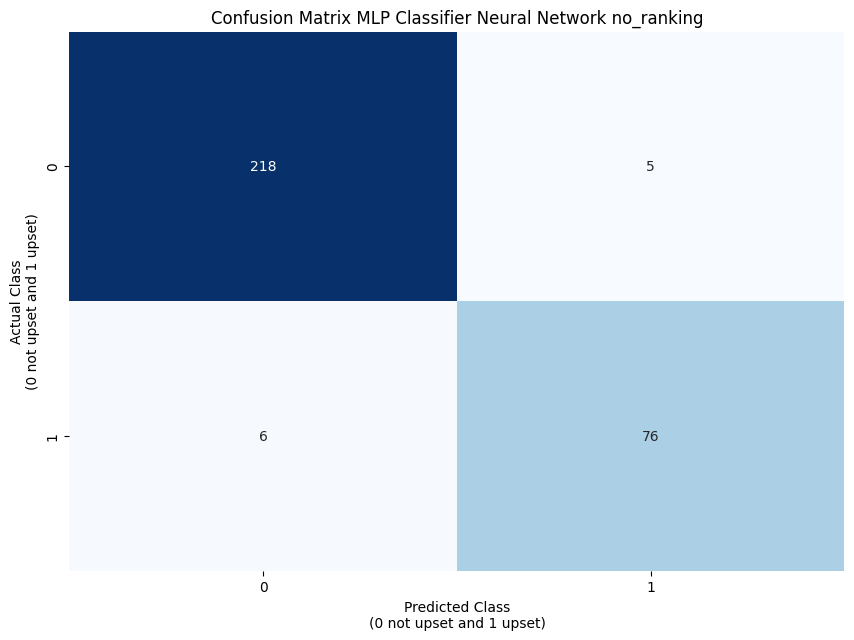

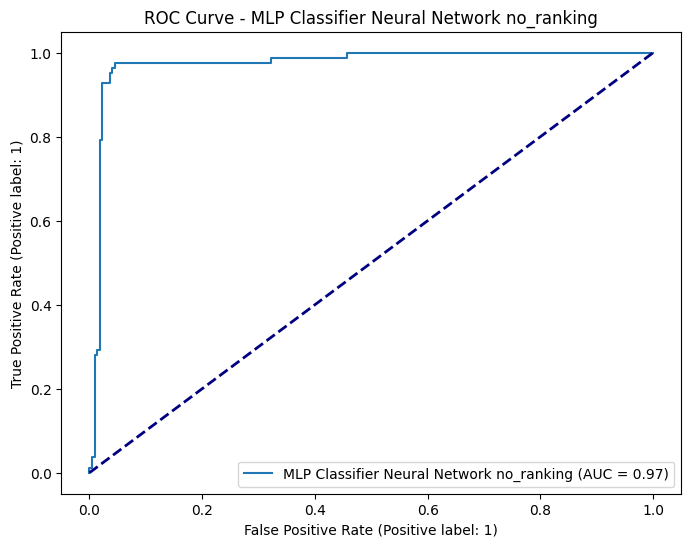

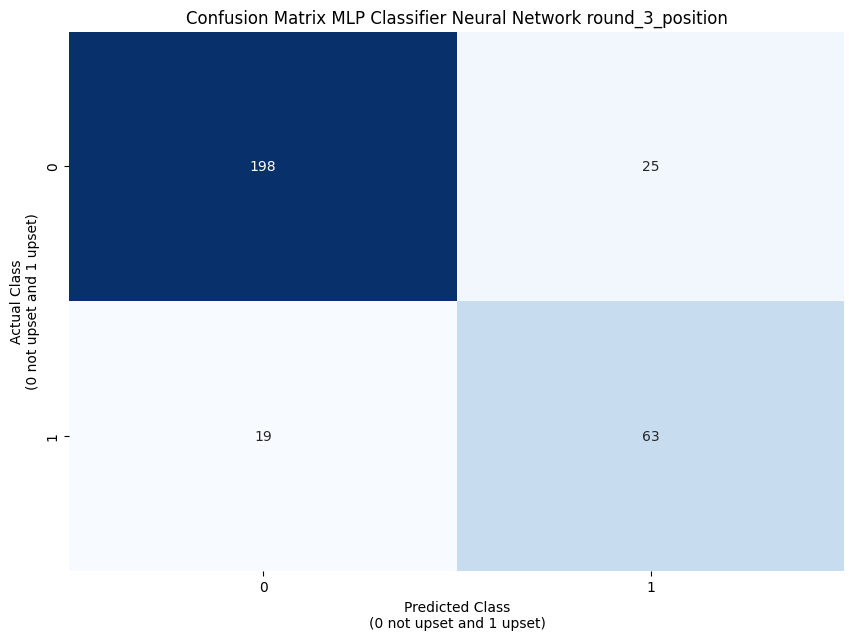

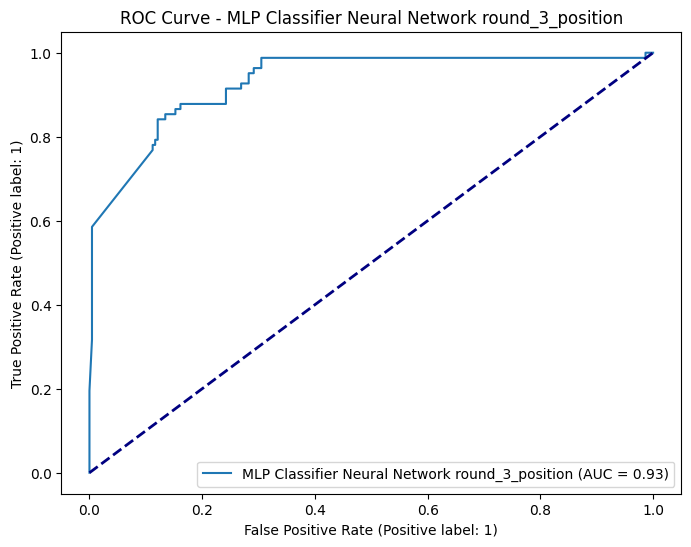

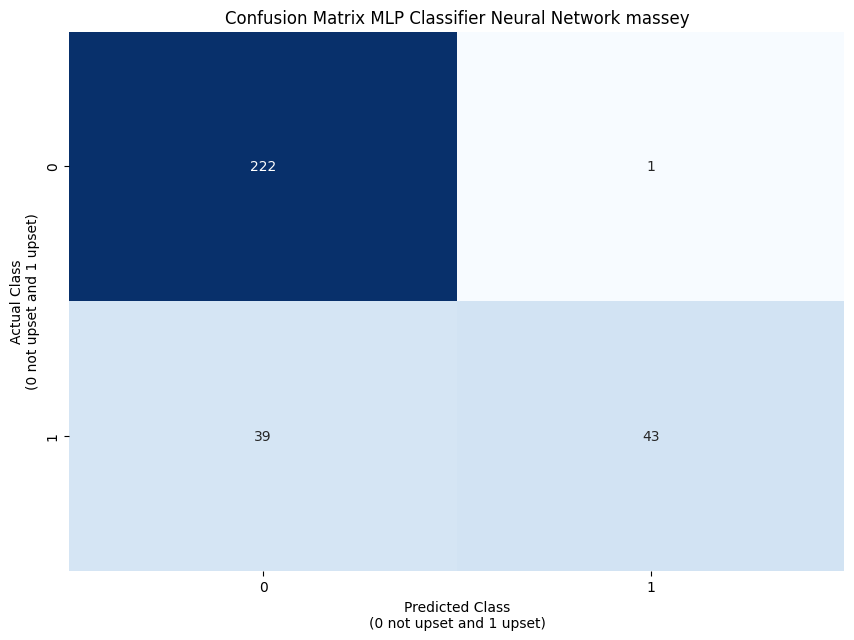

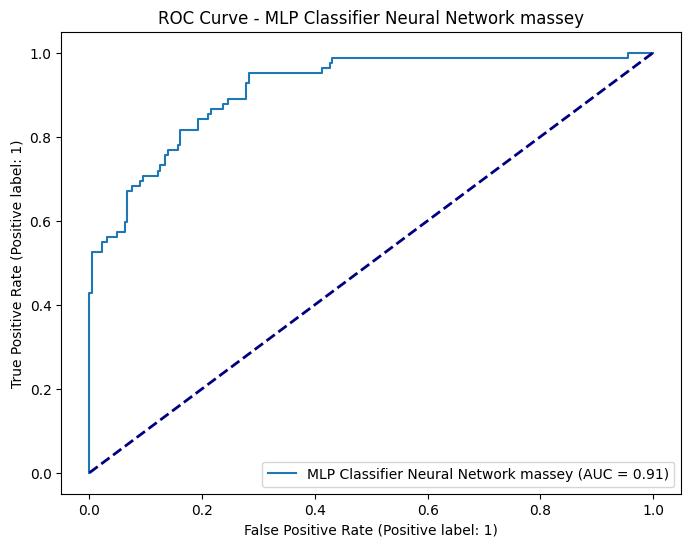

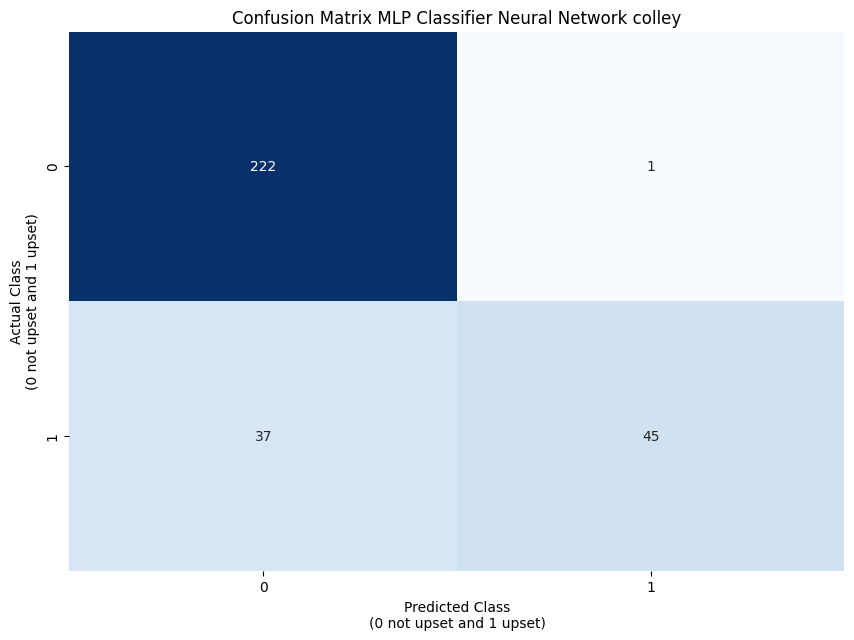

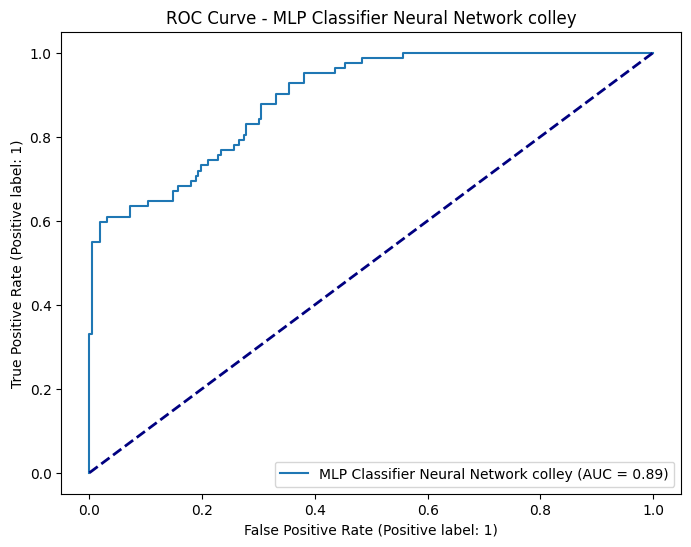

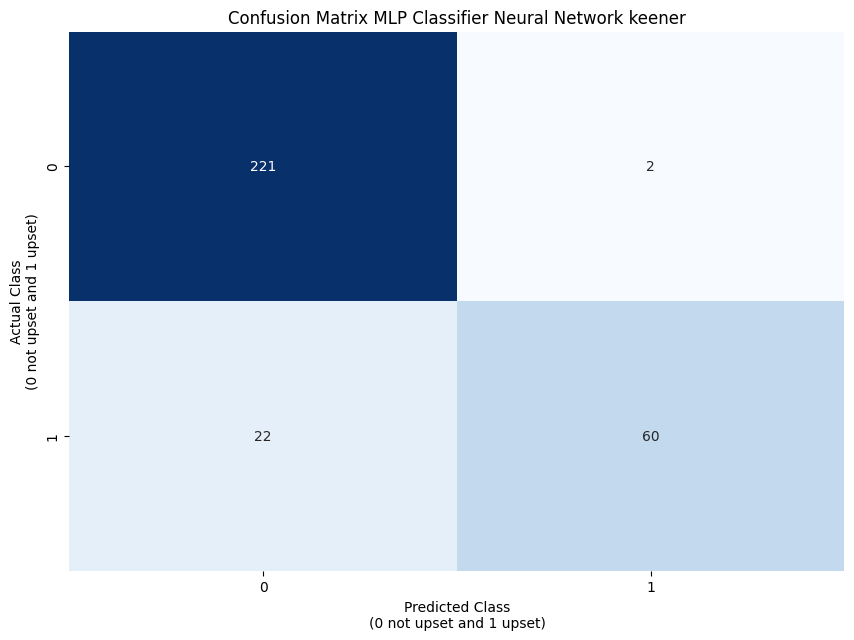

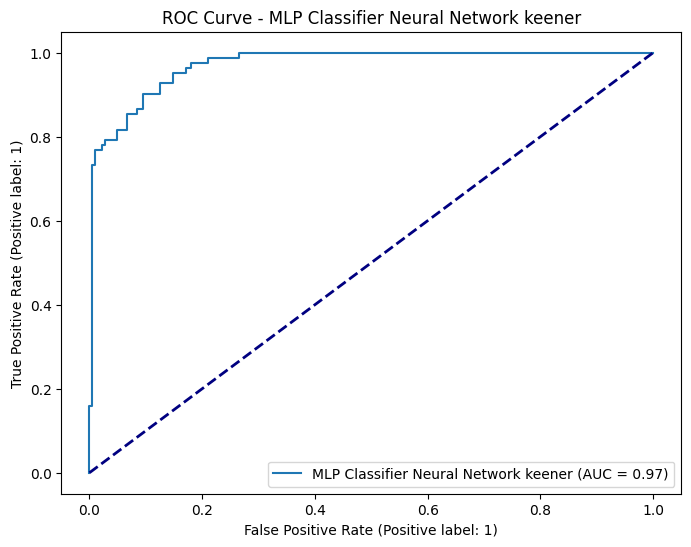

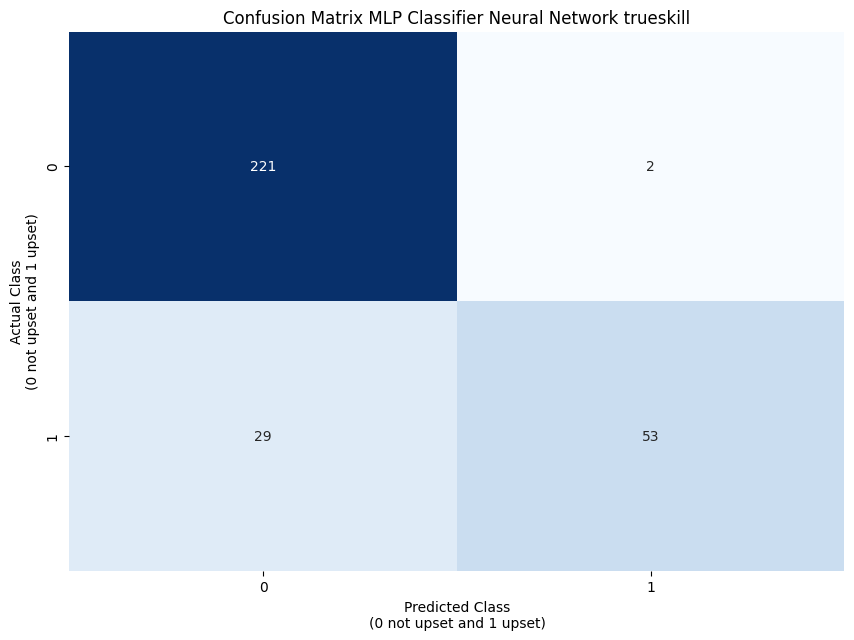

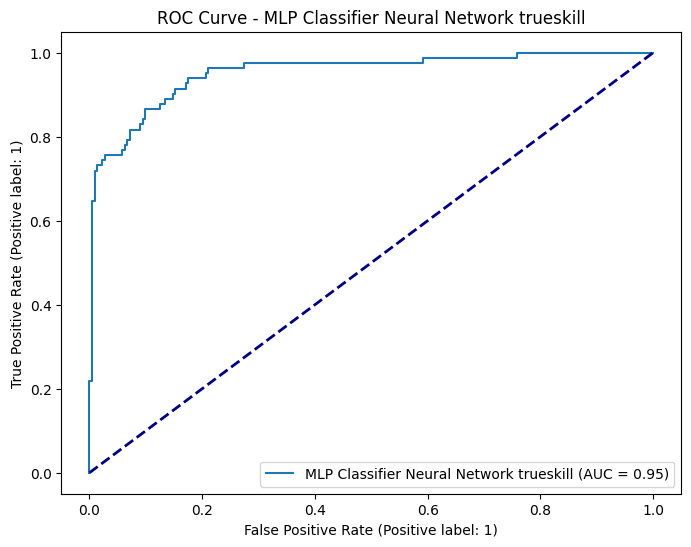

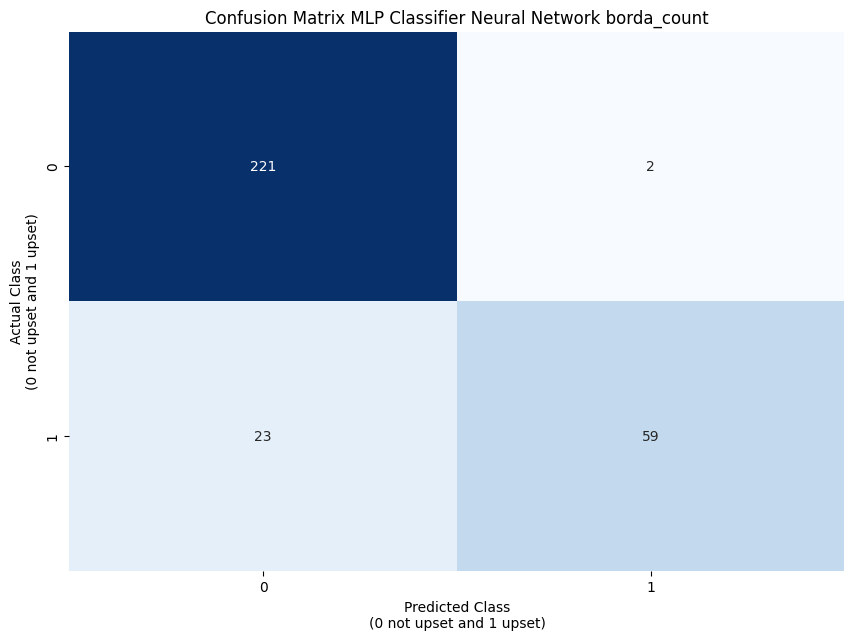

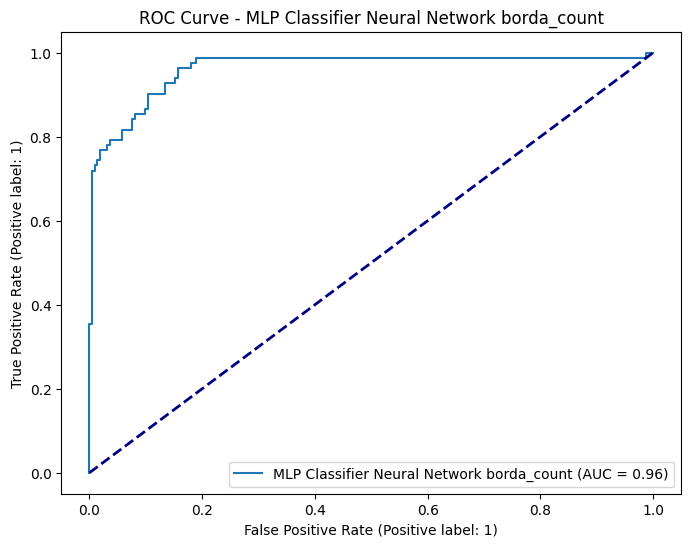

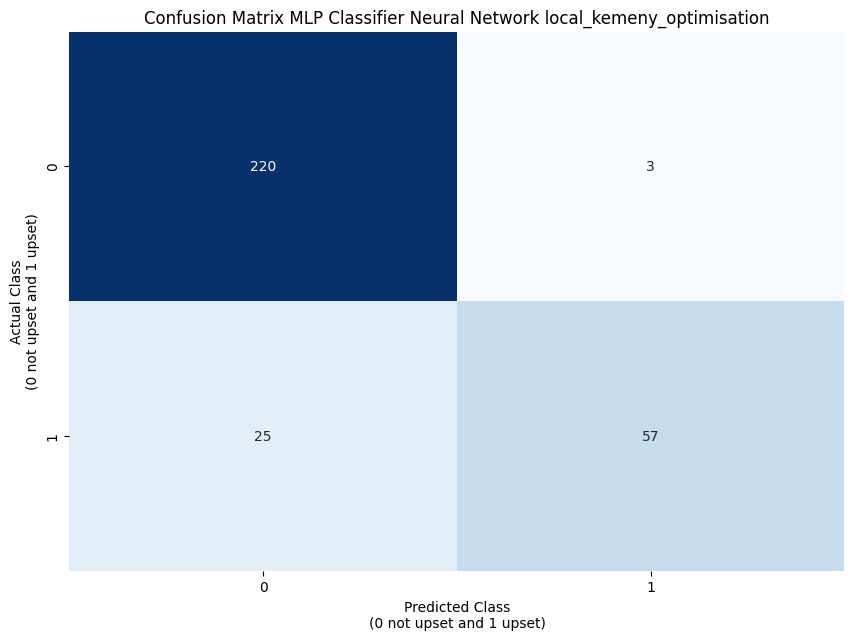

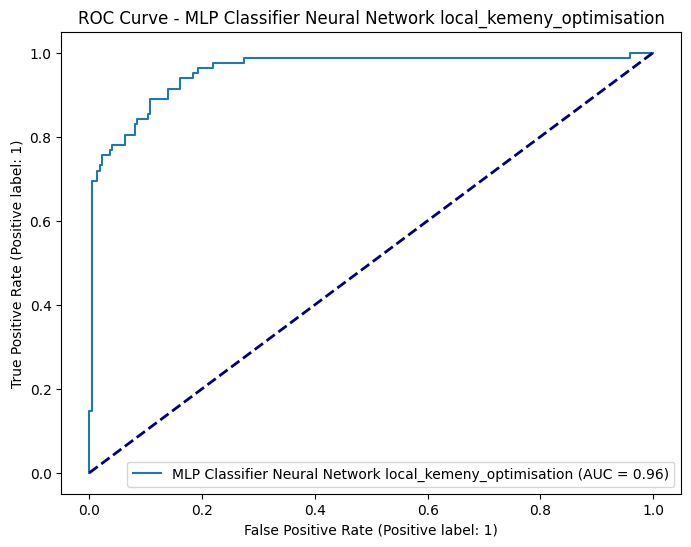

In [15]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
home_advt = 'no'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nn = all_results_df
display(all_results_df_nn)

fold_results_df_nn = fold_results_df
display(fold_results_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")
fold_results_df_nn.to_excel("fold_results_nn.xlsx")

MLP Classifier Neural Network with home advantage no_ranking
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.712
Fold 1 Accuracy: 0.967
Fold 1 Recall: 0.938
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.758
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.621
Fold 3 Accuracy: 0.918
Fold 3 Recall: 0.750
Best parameters: {'classifier__activation': 'logistic', 'c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.667
Fold 1 Accuracy: 0.738
Fold 1 Recall: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.712
Fold 2 Accuracy: 0.967
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.667
Fold 3 Accuracy: 0.869
Fold 3 Recall: 0.625
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.665
Fold 4 Accuracy: 0.951
Fold 4 Recall: 0.824
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learn

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 3 Accuracy: 0.803
Fold 3 Recall: 0.438
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.858
Fold 4 Accuracy: 0.721
Fold 4 Recall: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.709
Fold 5 Accuracy: 0.885
Fold 5 Recall: 0.706
Average Accuracy: 0.816
Average Recall: 0.391
MLP Classifier Neural Network with home advantage keener
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.667
Fold 1 Accuracy: 0.934
Fold 1 Recall: 0.750
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.652
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best p

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.697
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.621
Fold 3 Accuracy: 0.852
Fold 3 Recall: 0.500
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.649
Fold 4 Accuracy: 0.967
Fold 4 Recall: 0.882
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10,), 'classifier_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.664
Fold 5 Accuracy: 0.902
Fold 5 Recall: 0.765
Average Accuracy: 0.852
Average Recall: 0.528
MLP Classifier Neural Network with home advantage local_kemeny_optimisation
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.636
Fold 1 Accuracy: 0.918
Fold 1 Recall: 0.812
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.712
Fold 2 Accuracy: 0.984
Fold 2 Recall: 1.

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   MLP Classifier Neural Network with home advantage no_ranking  \
0                                               0.911             
1                                               0.098             
2                                               0.701             
3                                               0.357             
4                                               0.911             
5                                             221.000             
6                                               2.000             
7                                              25.000             
8                                              57.000             
9                                               0.898             
10                                              0.991             
11                                              0.942             
12                                              0.966             
13                                              0.695             
14                                              0.809             
15                                              0.932             
16                                              0.843             
17                                              0.875             
18                                              0.917             
19                                              0.911             
20                                              0.906             
21                                              0.938             

   MLP Classifier Neural Network with home advantage round_3_position  \
0                                               0.889                   
1                                               0.083                   
2                                               0.630                   
3                                               0.331                   
4                                               0.889                   
5                                             219.000                   
6                                               4.000                   
7                                              30.000                   
8                                              52.000                   
9                                               0.880                   
10                                              0.982                   
11                                              0.928                   
12                                              0.929          

Model Name Ranking  Fold  \
0   MLP Classifier Neural Network with home advant...     1   
1   MLP Classifier Neural Network with home advant...     2   
2   MLP Classifier Neural Network with home advant...     3   
3   MLP Classifier Neural Network with home advant...     4   
4   MLP Classifier Neural Network with home advant...     5   
5   MLP Classifier Neural Network with home advant...     1   
6   MLP Classifier Neural Network with home advant...     2   
7   MLP Classifier Neural Network with home advant...     3   
8   MLP Classifier Neural Network with home advant...     4   
9   MLP Classifier Neural Network with home advant...     5   
10  MLP Classifier Neural Network with home advant...     1   
11  MLP Classifier Neural Network with home advant...     2   
12  MLP Classifier Neural Network with home advant...     3   
13  MLP Classifier Neural Network with home advant...     4   
14  MLP Classifier Neural Network with home advant...     5   
15  MLP Classifier Neural Network with home advant...     1   
16  MLP Classifier Neural Network with home advant...     2   
17  MLP Classifier Neural Network with home advant...     3   
18  MLP Classifier Neural Network with home advant...     4   
19  MLP Classifier Neural Network with home advant...     5   
20  MLP Classifier Neural Network with home advant...     1   
21  MLP Classifier Neural Network with home advant...     2   
22  MLP Classifier Neural Network with home advant...     3   
23  MLP Classifier Neural Network with home advant...     4   
24  MLP Classifier Neural Network with home advant...     5   
25  MLP Classifier Neural Network with home advant...     1   
26  MLP Classifier Neural Network with home advant...     2   
27  MLP Classifier Neural Network with home advant...     3   
28  MLP Classifier Neural Network with home advant...     4   
29  MLP Classifier Neural Network with home advant...     5   
30  MLP Classifier Neural Network with home advant...     1   
31  MLP Classifier Neural Network with home advant...     2   
32  MLP Classifier Neural Network with home advant...     3   
33  MLP Classifier Neural Network with home advant...     4   
34  MLP Classifier Neural Network with home advant...     5   
35  MLP Classifier Neural Network with home advant...     1   
36  MLP Classifier Neural Network with home advant...     2   
37  MLP Classifier Neural Network with home advant...     3   
38  MLP Classifier Neural Network with home advant...     4   
39  MLP Classifier Neural Network with home advant...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__activation': 'logistic', 'classi...   
1   {'classifier__activation': 'relu', 'classifier...   
2   {'classifier__activation': 'logistic', 'classi...   
3   {'classifier__activation': 'logistic', 'classi...   
4   {'classifier__activation': 'logistic', 'classi...   
5   {'classifier__activation': 'logistic', 'classi...   
6   {'classifier__activation': 'tanh', 'classifier...   
7   {'classifier__activation': 'relu', 'classifier...   
8   {'classifier__activation': 'relu', 'classifier...   
9   {'classifier__activation': 'tanh', 'classifier...   
10  {'classifier__activation': 'relu', 'classifier...   
11  {'classifier__activation': 'logistic', 'classi...   
12  {'classifier__activation': 'tanh', 'classifier...   
13  {'classifier__activation': 'tanh', 'classifier...   
14  {'classifier__activation': 'relu', 'classifier...   
15  {'classifier__activation': 'relu', 'classifier...   
16  {'classifier__activation': 'logistic', 'classi...   
17  {'classifier__activation': 'tanh', 'classifier...   
18  {'classifier__activation': 'relu', 'classifier...   
19  {'classifier__activation': 'relu', 'classifier...   
20  {'classifier__activation': 'logistic', 'classi...   
21  {'classifier__activation': 'tanh', 'classifier...   
22  {'classifier__activation': 'relu', 'classifier...   
23  {'classifier__activation': 'relu', 'classifier...   
24  {'classifier__activati

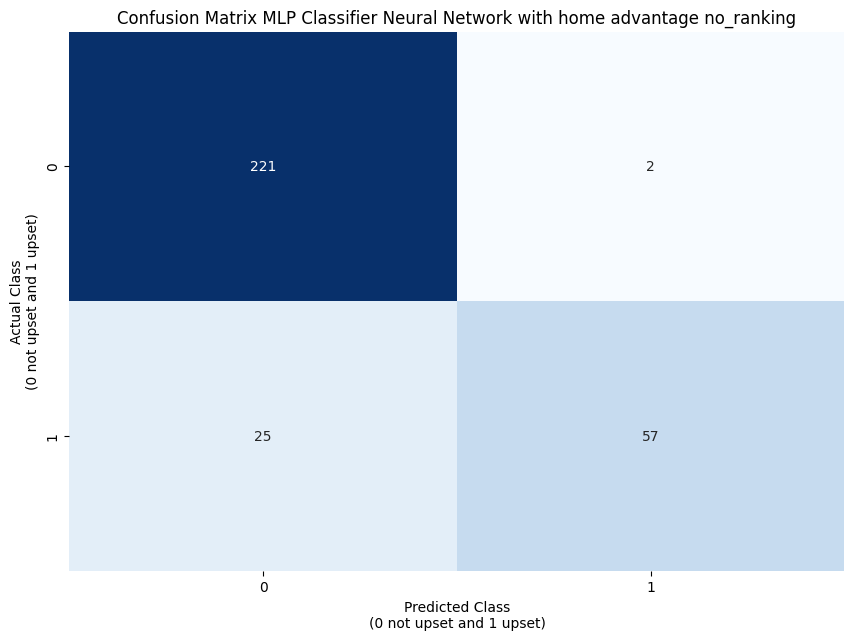

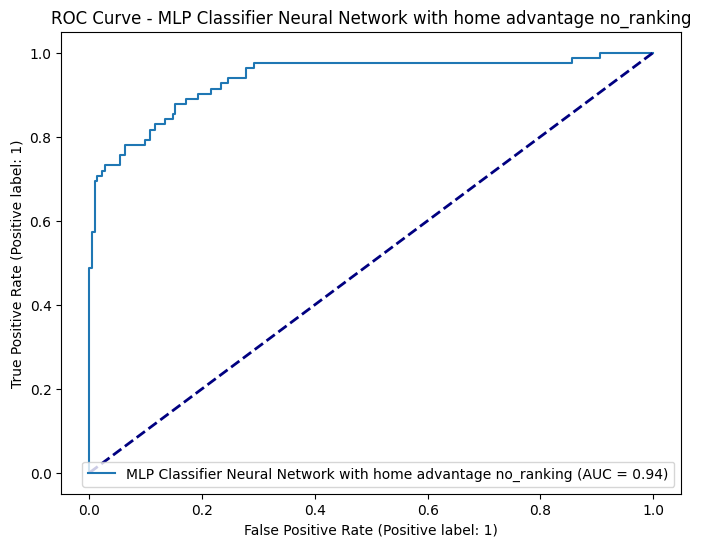

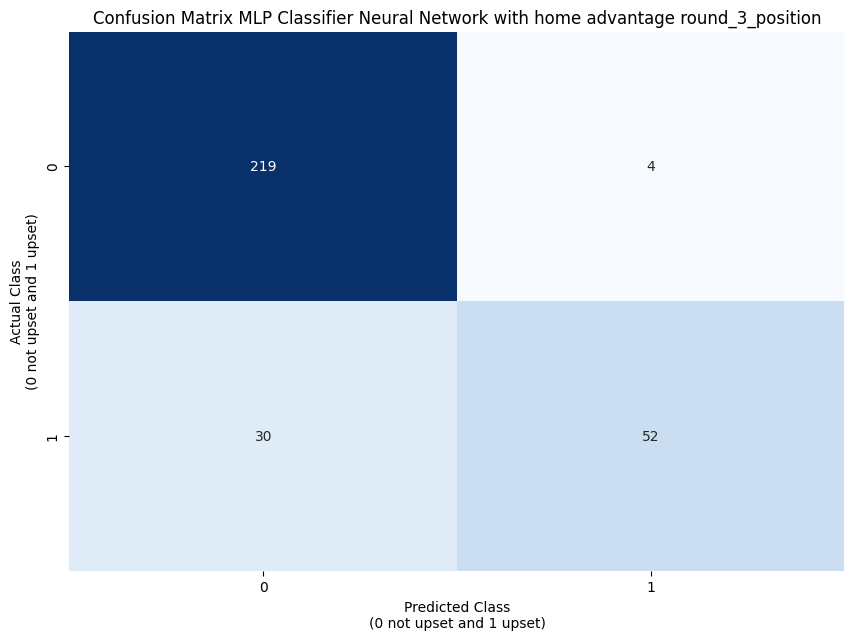

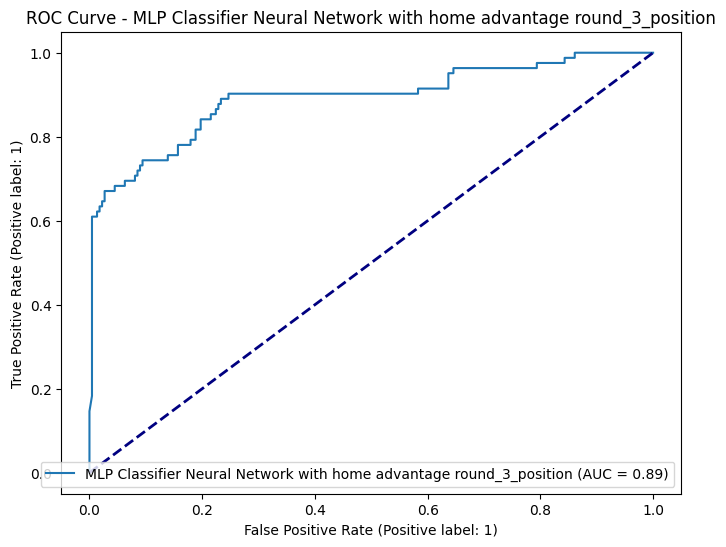

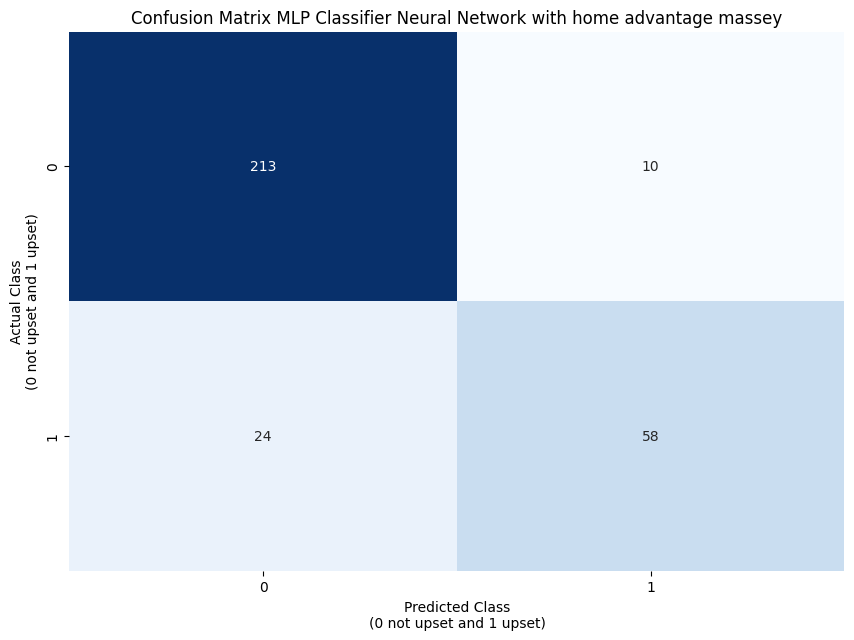

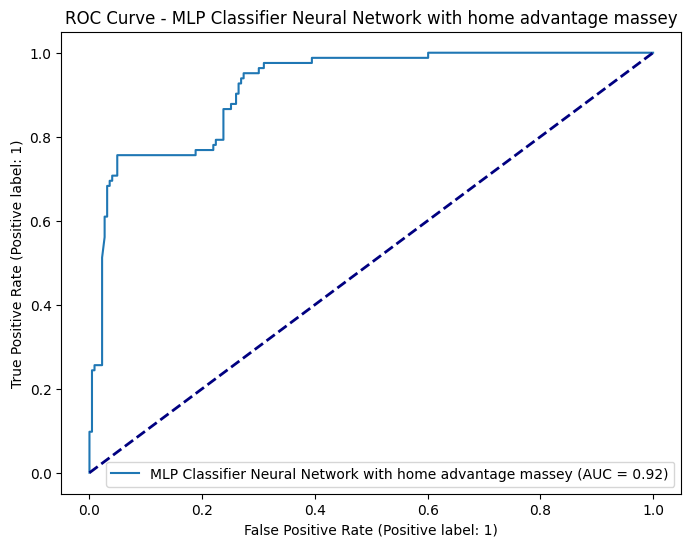

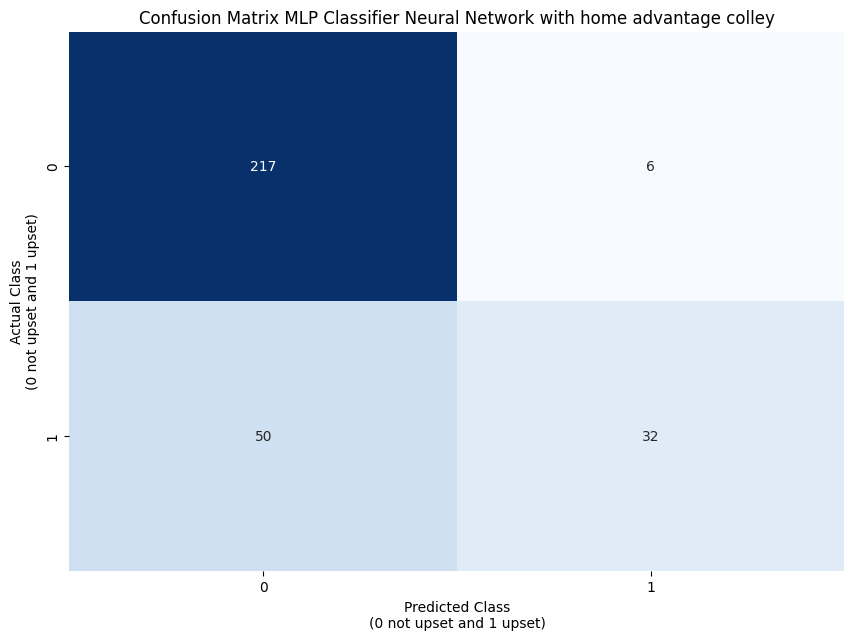

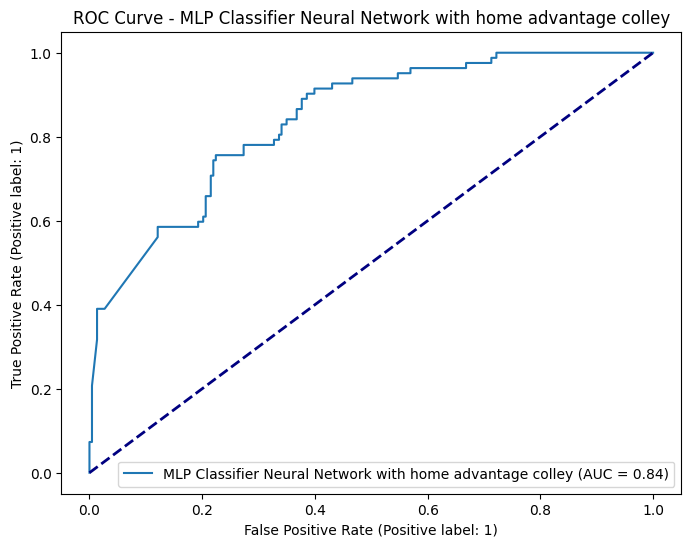

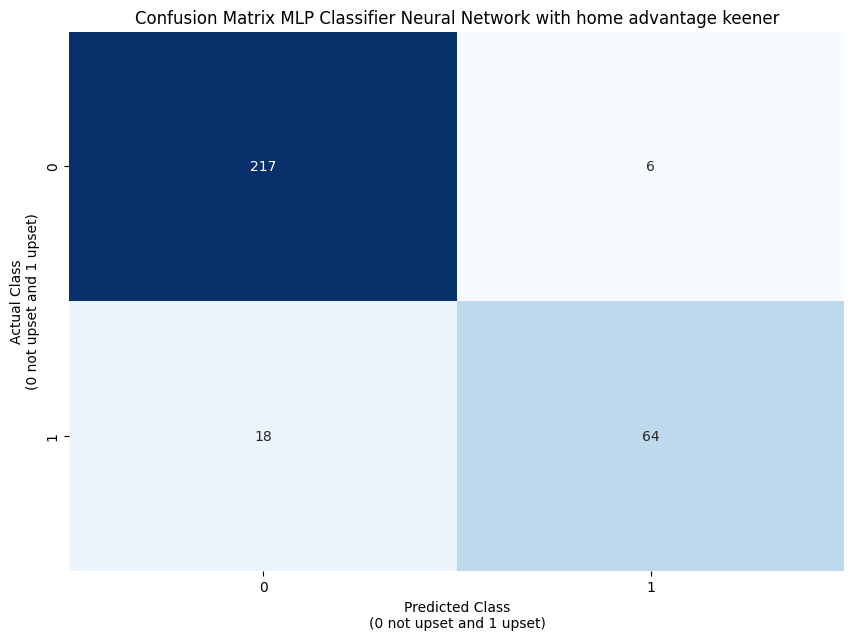

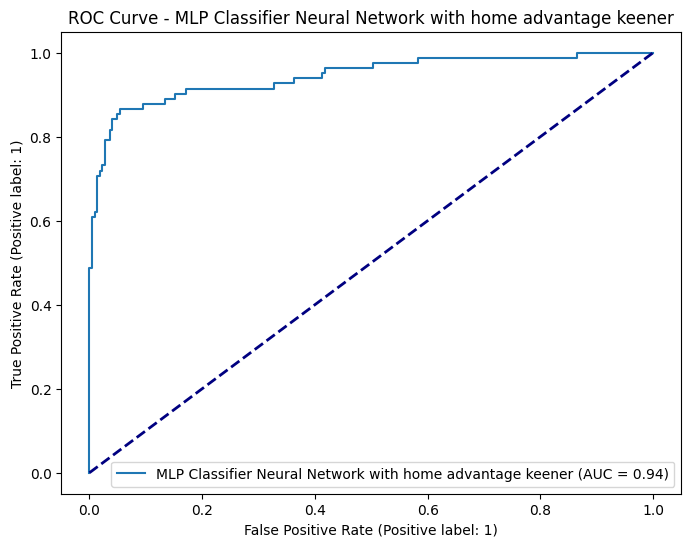

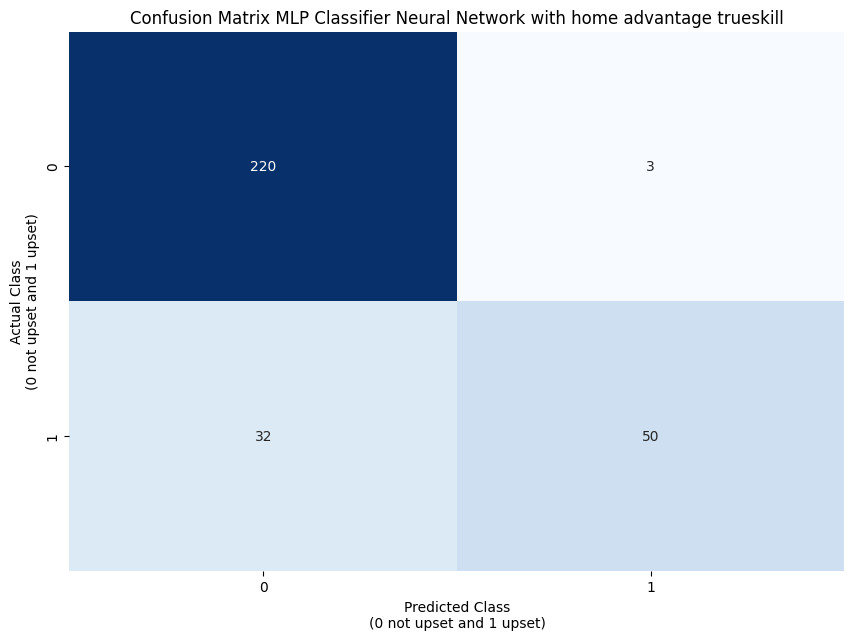

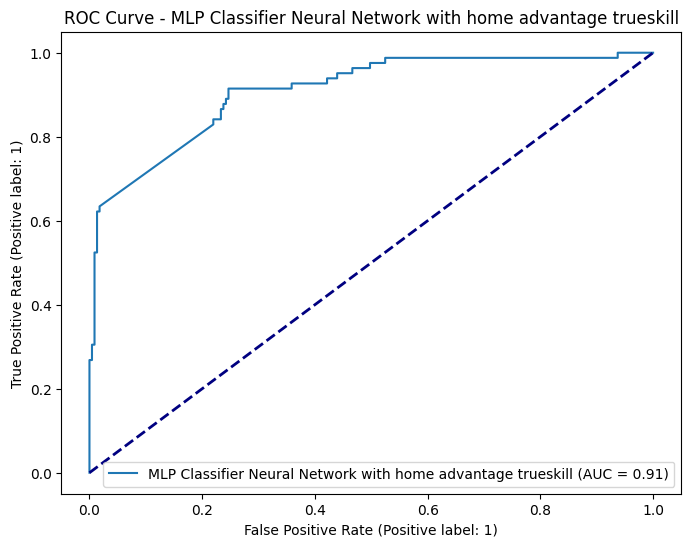

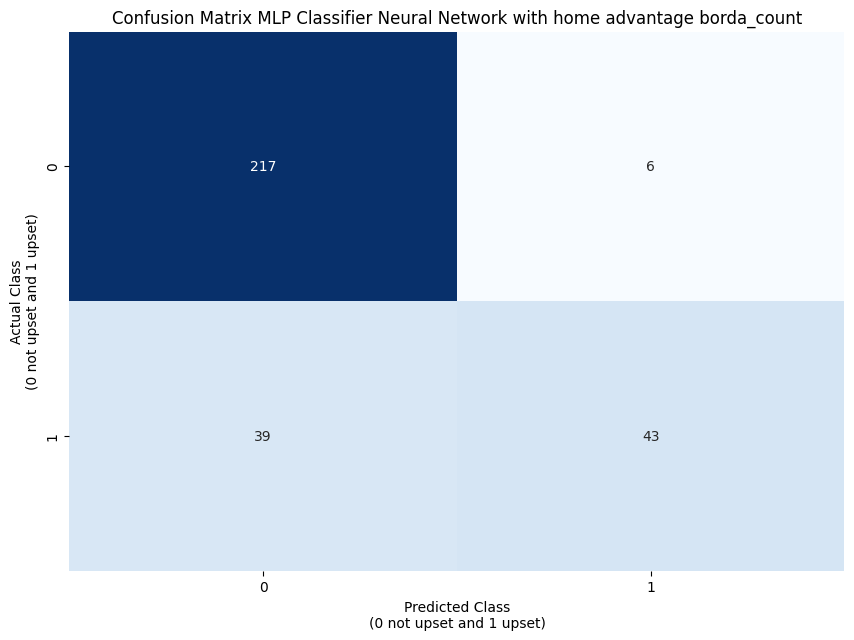

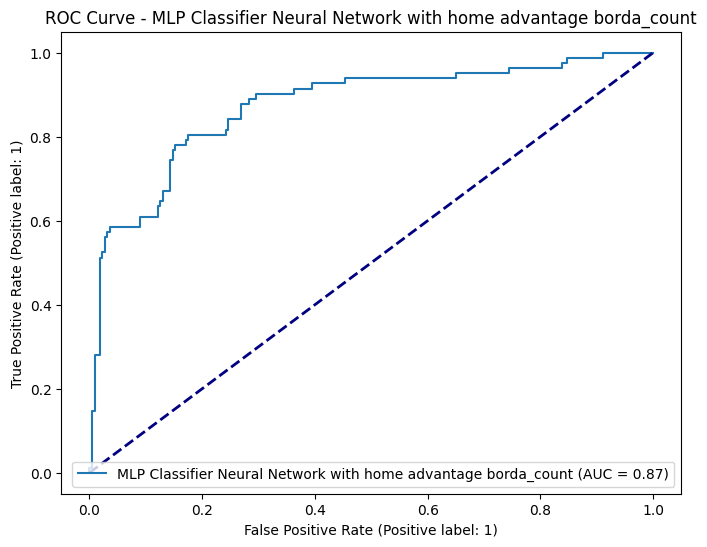

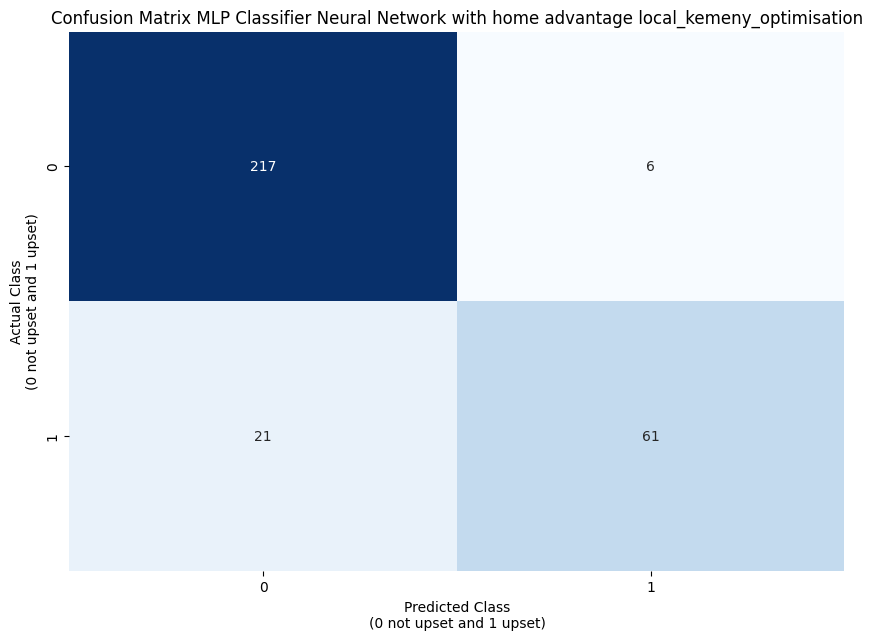

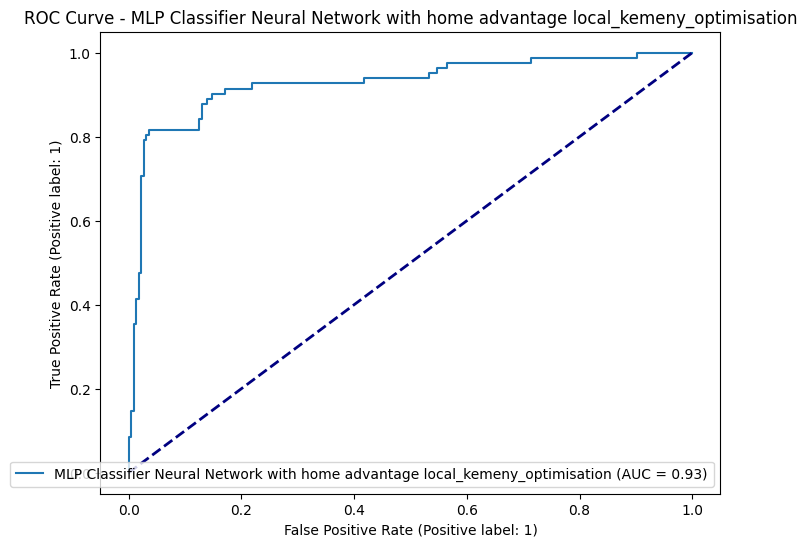

In [16]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nnh = all_results_df
display(all_results_df_nnh)

fold_results_df_nnh = fold_results_df
display(fold_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")
fold_results_df_nnh.to_excel("fold_results_nnh.xlsx")

Random Forest Classifier no_ranking
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.652
Fold 1 Accuracy: 0.803
Fold 1 Recall: 0.375
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.545
Fold 2 Accuracy: 0.951
Fold 2 Recall: 0.812
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 3 Accuracy: 0.836
Fold 3 Recall: 0.438
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.523
Fold 4 Accuracy: 0.984

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Random Forest Classifier no_ranking  \
0                                0.885   
1                                0.070   
2                                0.607   
3                                0.226   
4                                0.885   
5                              220.000   
6                                3.000   
7                               32.000   
8                               50.000   
9                                0.873   
10                               0.987   
11                               0.926   
12                               0.943   
13                               0.610   
14                               0.741   
15                               0.908   
16                               0.798   
17                               0.834   
18                               0.892   
19                               0.885   
20                               0.876   
21                               0.970   

   Random Forest Classifier round_3_position Random Forest Classifier massey  \
0                                      0.908                           0.879   
1                                      0.058                           0.034   
2                                      0.694                           0.586   
3                                      0.190                           0.145   
4                                      0.908                           0.879   
5                                    220.000                         220.000   
6                                      3.000                           3.000   
7                                     25.000                          34.000   
8                                     57.000                          48.000   
9                                      0.898                           0.866   
10                                     0.987                           0.987   
11                                     0.940                           0.922   
12                                     0.950                           0.941   
13                                     0.695                           0.585   
14                                     0.803                           0.722   
15                                     0.924                           0.904   
16                                     0.841                           0.786   
17                                     0.871                           0.822   
18                                     0.912                       

Model Name Ranking  Fold  \
0                 Random Forest Classifier no_ranking     1   
1                 Random Forest Classifier no_ranking     2   
2                 Random Forest Classifier no_ranking     3   
3                 Random Forest Classifier no_ranking     4   
4                 Random Forest Classifier no_ranking     5   
5           Random Forest Classifier round_3_position     1   
6           Random Forest Classifier round_3_position     2   
7           Random Forest Classifier round_3_position     3   
8           Random Forest Classifier round_3_position     4   
9           Random Forest Classifier round_3_position     5   
10                    Random Forest Classifier massey     1   
11                    Random Forest Classifier massey     2   
12                    Random Forest Classifier massey     3   
13                    Random Forest Classifier massey     4   
14                    Random Forest Classifier massey     5   
15                    Random Forest Classifier colley     1   
16                    Random Forest Classifier colley     2   
17                    Random Forest Classifier colley     3   
18                    Random Forest Classifier colley     4   
19                    Random Forest Classifier colley     5   
20                    Random Forest Classifier keener     1   
21                    Random Forest Classifier keener     2   
22                    Random Forest Classifier keener     3   
23                    Random Forest Classifier keener     4   
24                    Random Forest Classifier keener     5   
25                 Random Forest Classifier trueskill     1   
26                 Random Forest Classifier trueskill     2   
27                 Random Forest Classifier trueskill     3   
28                 Random Forest Classifier trueskill     4   
29                 Random Forest Classifier trueskill     5   
30               Random Forest Classifier borda_count     1   
31               Random Forest Classifier borda_count     2   
32               Random Forest Classifier borda_count     3   
33               Random Forest Classifier borda_count     4   
34               Random Forest Classifier borda_count     5   
35  Random Forest Classifier local_kemeny_optimisa...     1   
36  Random Forest Classifier local_kemeny_optimisa...     2   
37  Random Forest Classifier local_kemeny_optimisa...     3   
38  Random Forest Classifier local_kemeny_optimisa...     4   
39  Random Forest Classifier local_kemeny_optimisa...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__max_features': None, 'classifier...   
1   {'classifier__max_features': None, 'classifier...   
2   {'classifier__max_features': None, 'classifier...   
3   {'classifier__max_features': None, 'classifier...   
4   {'classifier__max_features': None, 'classifier...   
5   {'classifier__max_features': None, 'classifier...   
6   {'classifier__max_features': None, 'classifier...   
7   {'classifier__max_features': None, 'classifier...   
8   {'classifier__max_features': None, 'classifier...   
9   {'classifier__max_features': None, 'classifier...   
10  {'classifier__max_features': None, 'classifier...   
11  {'classifier__max_features': None, 'classifier...   
12  {'classifier__max_features': None, 'classifier...   
13  {'classifier__max_features': None, 'classifier...   
14  {'classifier__max_features': None, 'classifier...   
15  {'classifier__max_features': None, 'classifier...   
16  {'classifier__max_features': None, 'classifier...   
17  {'classifier__max_features': None, 'classifier...   
18  {'classifier__max_features': None, 'classifier...   
19  {'classifier__max_features': None, 'classifier...   
20  {'classifier__max_features': None, 'classifier...   
21  {'classifier__max_features': None, 'classifier...   
22  {'classifier__max_features': None, 'classifier...   
23  {'classifier__max_features': None, 'classifier...   
24  {'classifier__max_feat

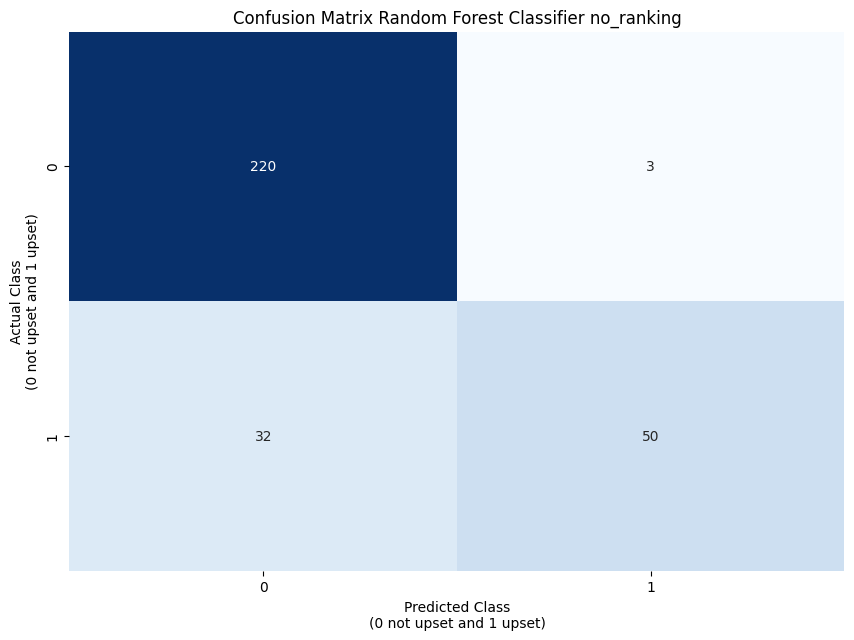

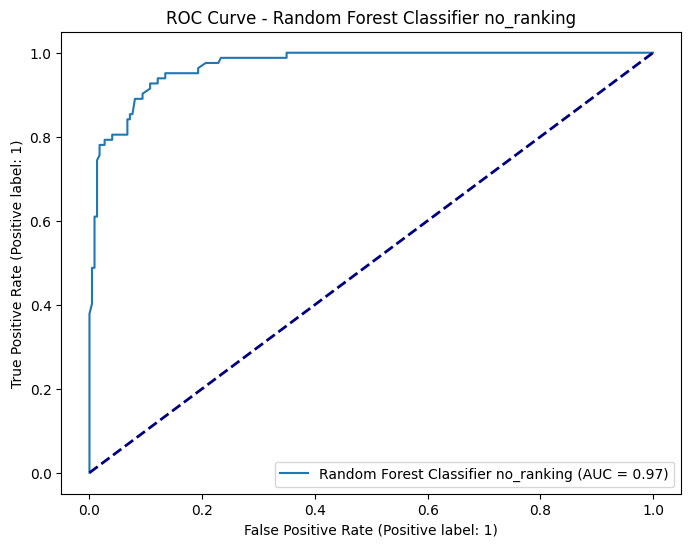

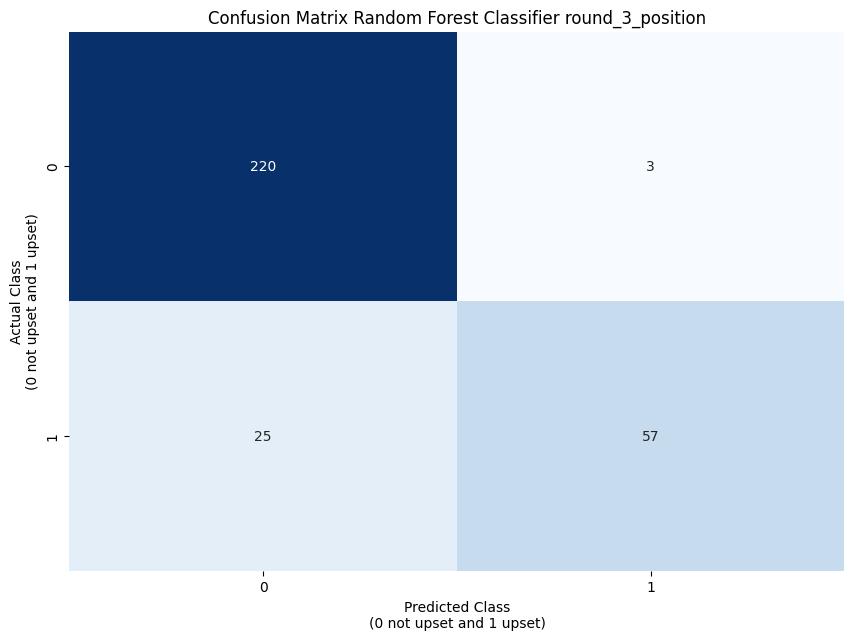

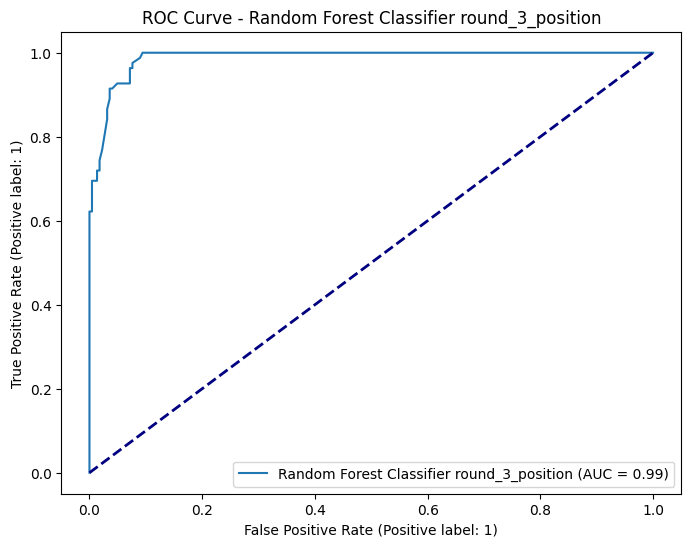

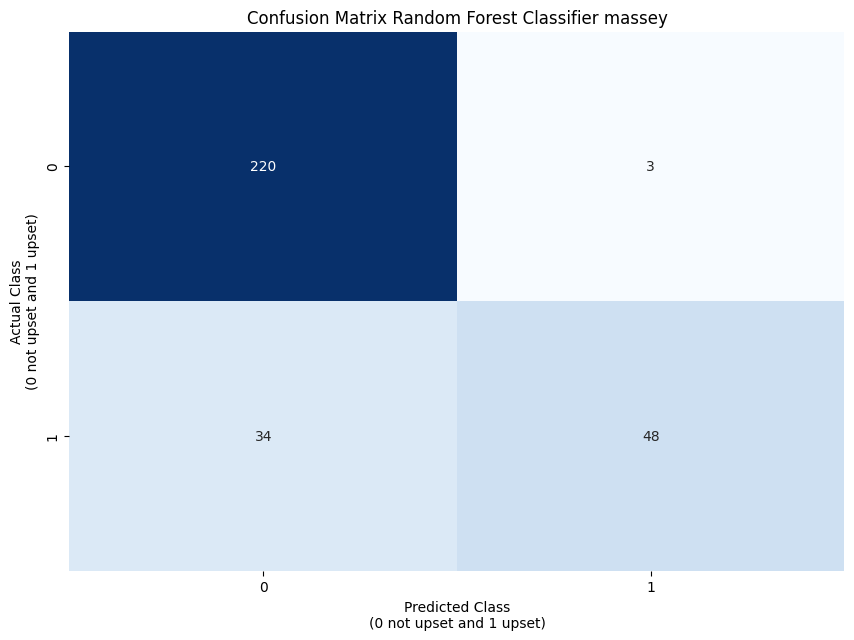

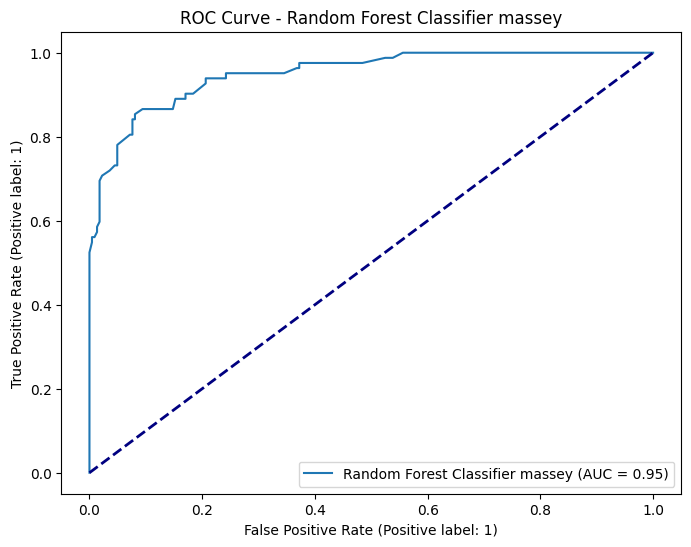

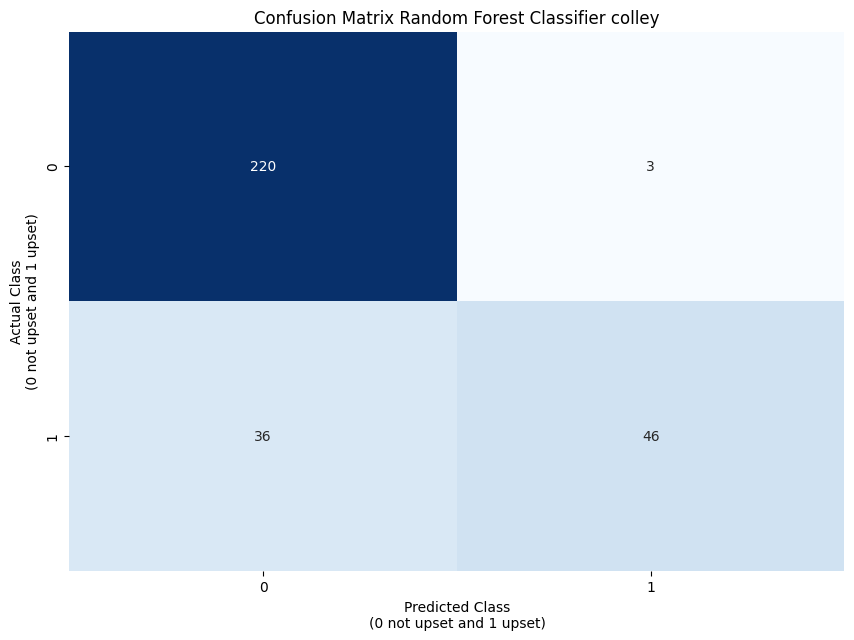

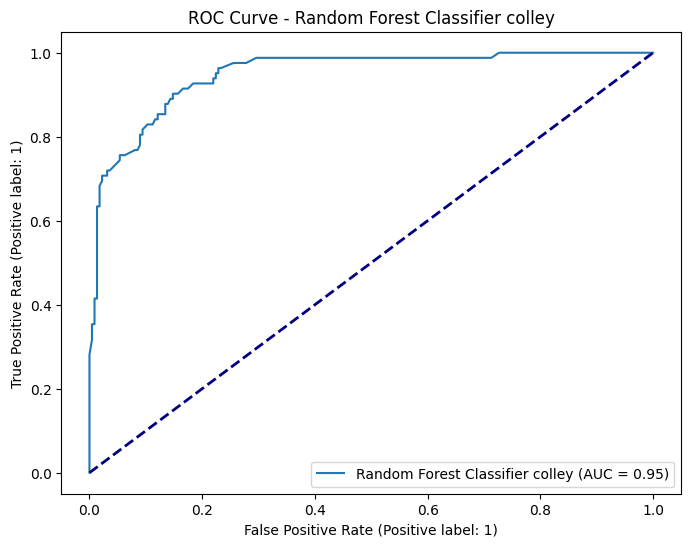

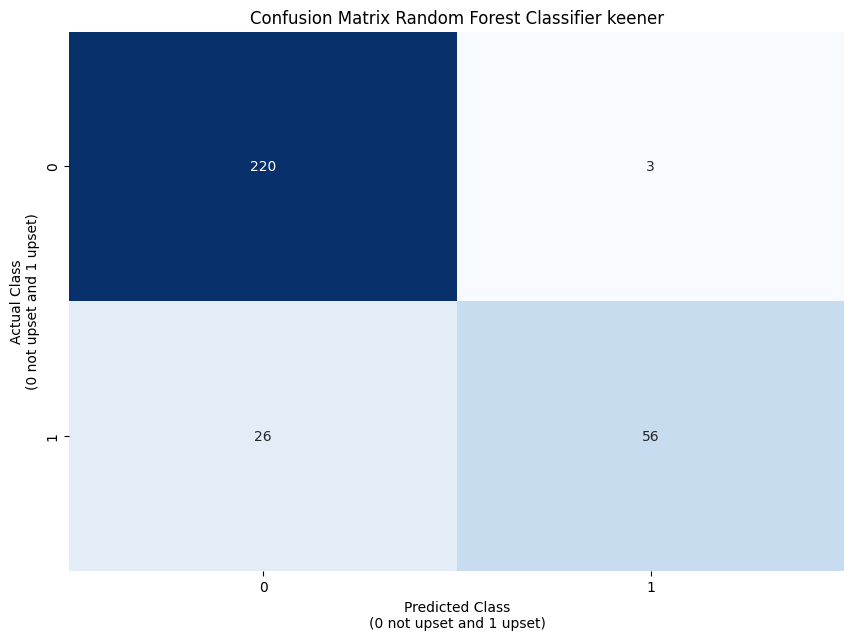

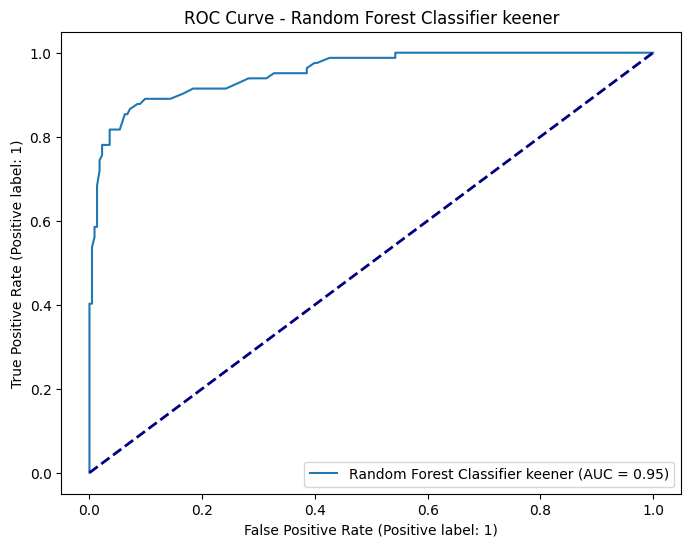

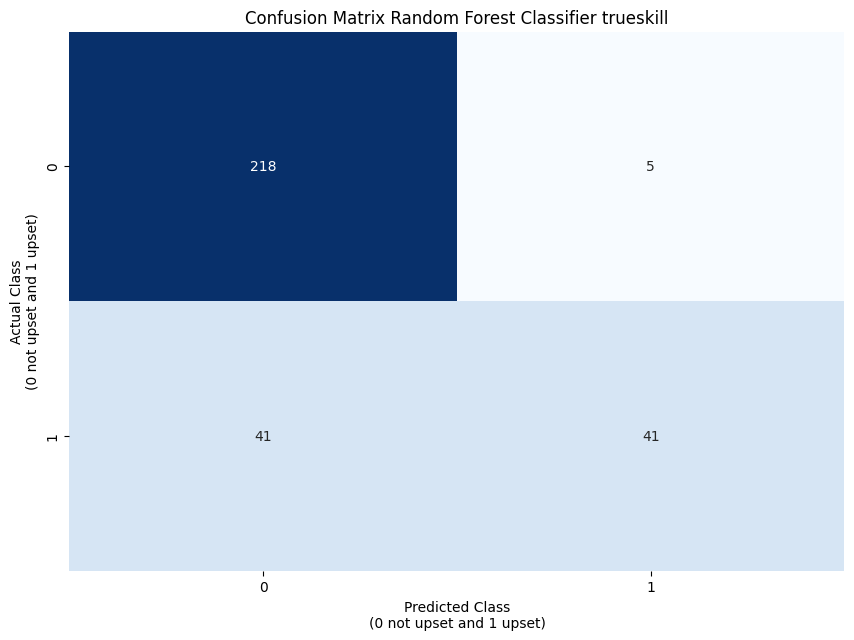

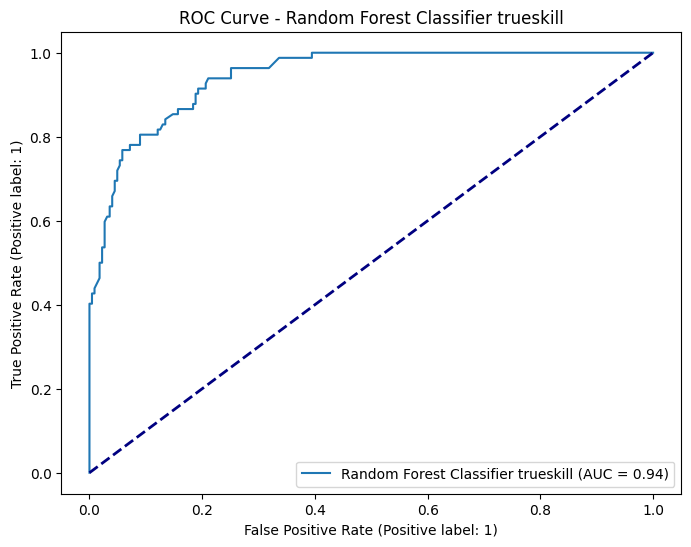

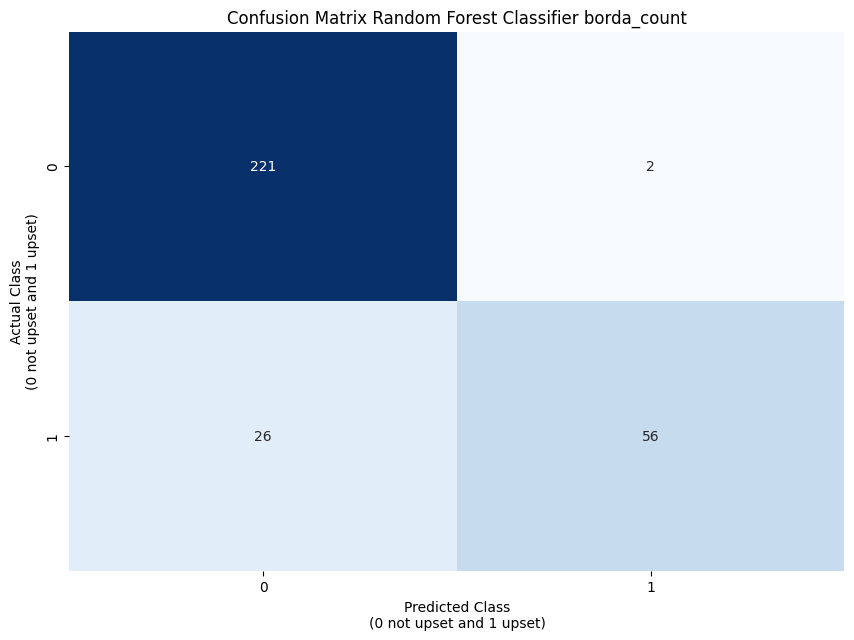

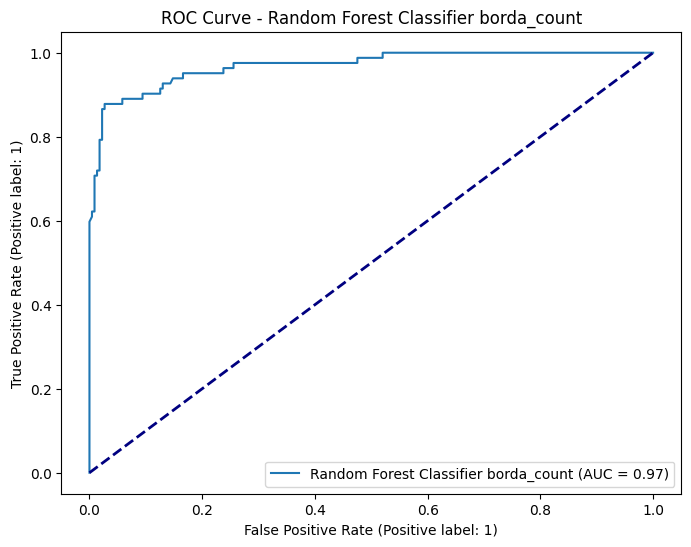

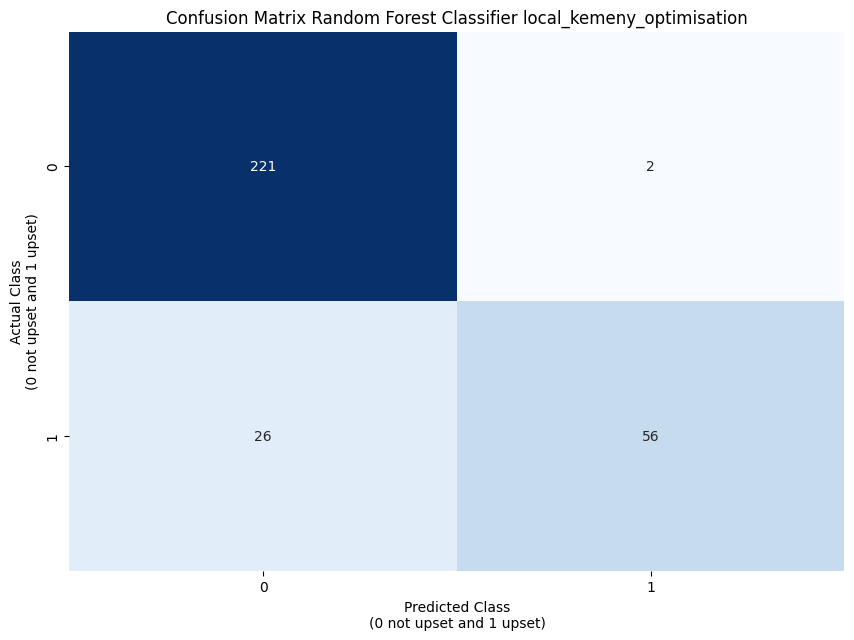

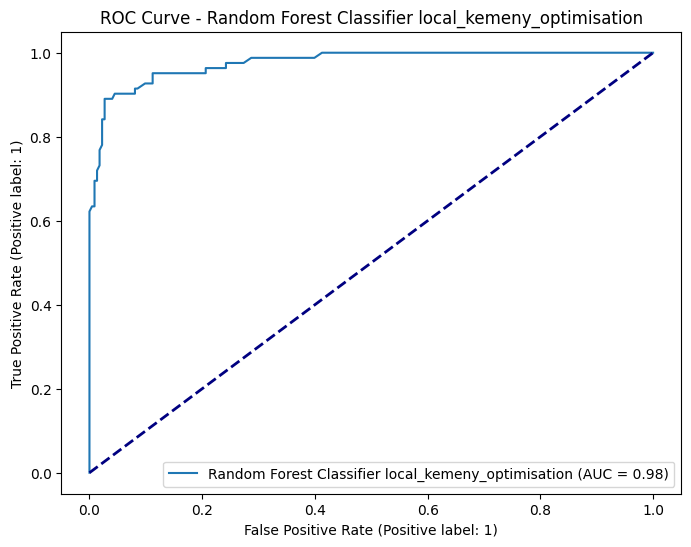

In [17]:
# Random Forest Classifier
model_name = "Random Forest Classifier"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")


Random Forest Classifier with home advantage no_ranking
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.758
Fold 1 Accuracy: 0.852
Fold 1 Recall: 0.500
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.667
Fold 2 Accuracy: 0.770
Fold 2 Recall: 0.812
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.636
Fold 3 Accuracy: 0.869
Fold 3 Recall: 0.500
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.540


metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Random Forest Classifier with home advantage no_ranking  \
0                                               0.833        
1                                               0.035        
2                                               0.610        
3                                               0.127        
4                                               0.833        
5                                             204.000        
6                                              19.000        
7                                              32.000        
8                                              50.000        
9                                               0.864        
10                                              0.915        
11                                              0.889        
12                                              0.725        
13                                              0.610        
14                                              0.662        
15                                              0.795        
16                                              0.762        
17                                              0.776        
18                                              0.827        
19                                              0.833        
20                                              0.828        
21                                              0.896        

   Random Forest Classifier with home advantage round_3_position  \
0                                               0.833              
1                                               0.026              
2                                               0.597              
3                                               0.140              
4                                               0.833              
5                                             205.000              
6                                              18.000              
7                                              33.000              
8                                              49.000              
9                                               0.861              
10                                              0.919              
11                                              0.889              
12                                              0.731              
13                                              0.598              
14                                              0.658              
15                                     

Model Name Ranking  Fold  \
0   Random Forest Classifier with home advantage n...     1   
1   Random Forest Classifier with home advantage n...     2   
2   Random Forest Classifier with home advantage n...     3   
3   Random Forest Classifier with home advantage n...     4   
4   Random Forest Classifier with home advantage n...     5   
5   Random Forest Classifier with home advantage r...     1   
6   Random Forest Classifier with home advantage r...     2   
7   Random Forest Classifier with home advantage r...     3   
8   Random Forest Classifier with home advantage r...     4   
9   Random Forest Classifier with home advantage r...     5   
10  Random Forest Classifier with home advantage m...     1   
11  Random Forest Classifier with home advantage m...     2   
12  Random Forest Classifier with home advantage m...     3   
13  Random Forest Classifier with home advantage m...     4   
14  Random Forest Classifier with home advantage m...     5   
15  Random Forest Classifier with home advantage c...     1   
16  Random Forest Classifier with home advantage c...     2   
17  Random Forest Classifier with home advantage c...     3   
18  Random Forest Classifier with home advantage c...     4   
19  Random Forest Classifier with home advantage c...     5   
20  Random Forest Classifier with home advantage k...     1   
21  Random Forest Classifier with home advantage k...     2   
22  Random Forest Classifier with home advantage k...     3   
23  Random Forest Classifier with home advantage k...     4   
24  Random Forest Classifier with home advantage k...     5   
25  Random Forest Classifier with home advantage t...     1   
26  Random Forest Classifier with home advantage t...     2   
27  Random Forest Classifier with home advantage t...     3   
28  Random Forest Classifier with home advantage t...     4   
29  Random Forest Classifier with home advantage t...     5   
30  Random Forest Classifier with home advantage b...     1   
31  Random Forest Classifier with home advantage b...     2   
32  Random Forest Classifier with home advantage b...     3   
33  Random Forest Classifier with home advantage b...     4   
34  Random Forest Classifier with home advantage b...     5   
35  Random Forest Classifier with home advantage l...     1   
36  Random Forest Classifier with home advantage l...     2   
37  Random Forest Classifier with home advantage l...     3   
38  Random Forest Classifier with home advantage l...     4   
39  Random Forest Classifier with home advantage l...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__max_features': None, 'classifier...   
1   {'classifier__max_features': None, 'classifier...   
2   {'classifier__max_features': None, 'classifier...   
3   {'classifier__max_features': None, 'classifier...   
4   {'classifier__max_features': None, 'classifier...   
5   {'classifier__max_features': None, 'classifier...   
6   {'classifier__max_features': None, 'classifier...   
7   {'classifier__max_features': None, 'classifier...   
8   {'classifier__max_features': None, 'classifier...   
9   {'classifier__max_features': None, 'classifier...   
10  {'classifier__max_features': None, 'classifier...   
11  {'classifier__max_features': None, 'classifier...   
12  {'classifier__max_features': None, 'classifier...   
13  {'classifier__max_features': None, 'classifier...   
14  {'classifier__max_features': None, 'classifier...   
15  {'classifier__max_features': None, 'classifier...   
16  {'classifier__max_features': None, 'classifier...   
17  {'classifier__max_features': None, 'classifier...   
18  {'classifier__max_features': None, 'classifier...   
19  {'classifier__max_features': None, 'classifier...   
20  {'classifier__max_features': None, 'classifier...   
21  {'classifier__max_features': None, 'classifier...   
22  {'classifier__max_features': None, 'classifier...   
23  {'classifier__max_features': 'sqrt', 'classifi...   
24  {'classifier__max_feat

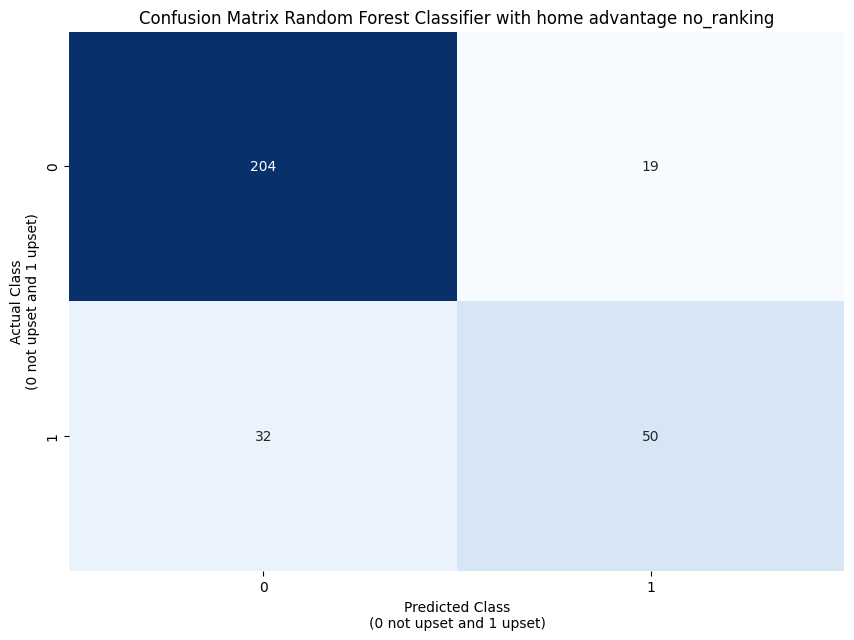

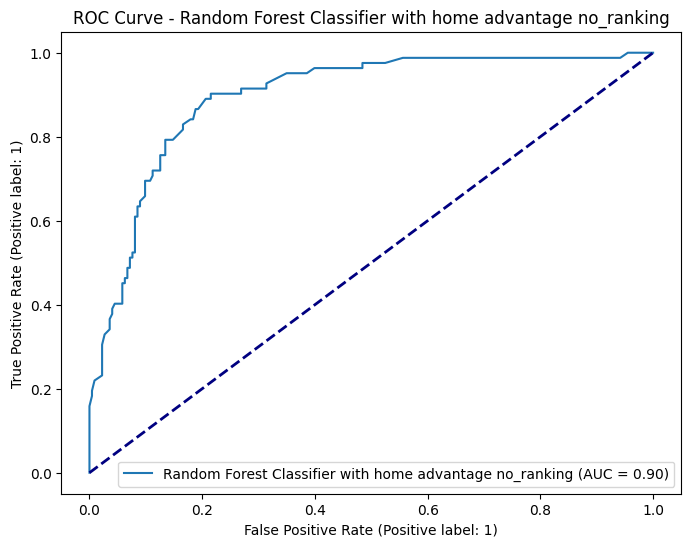

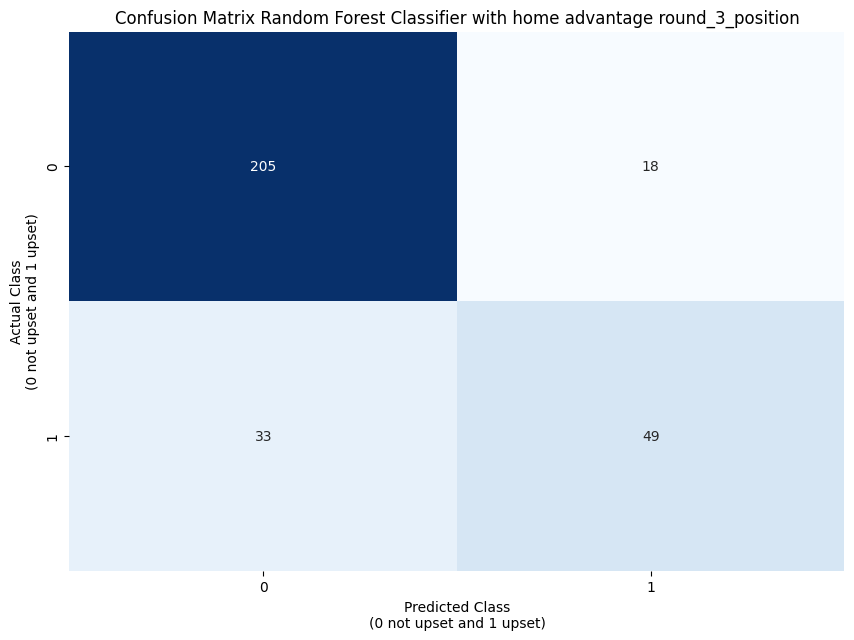

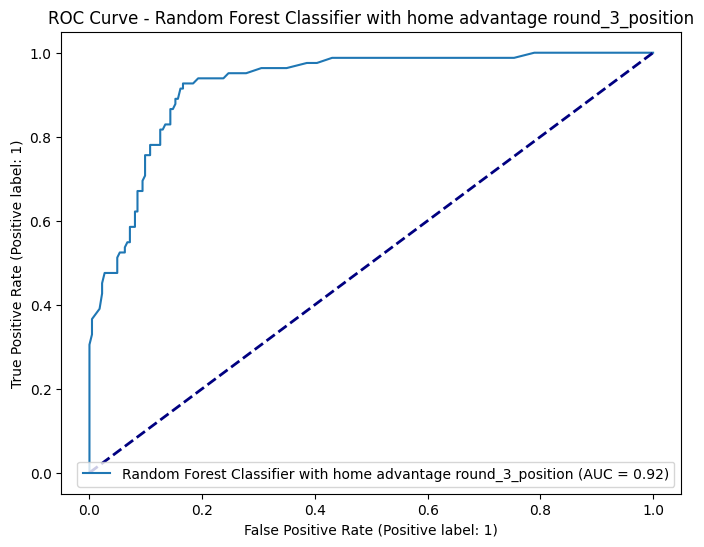

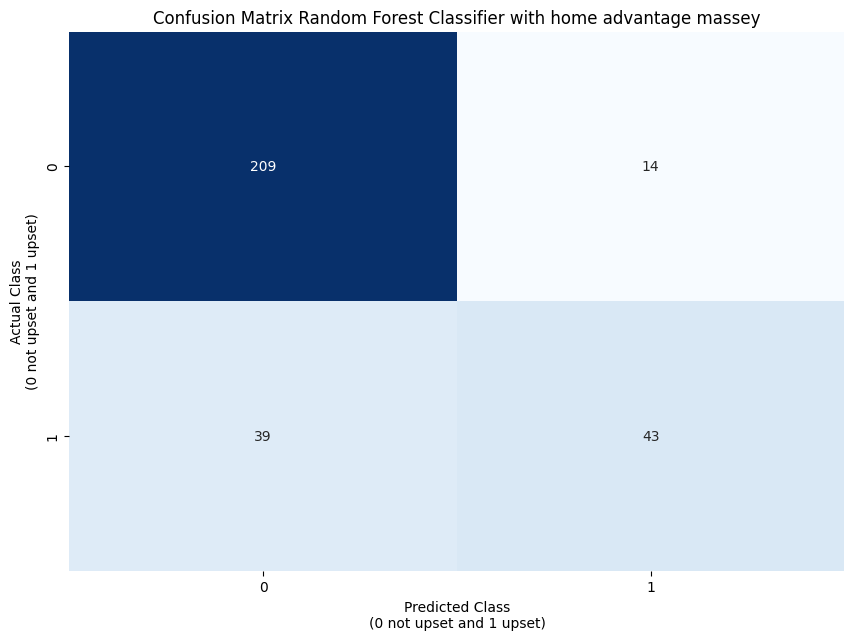

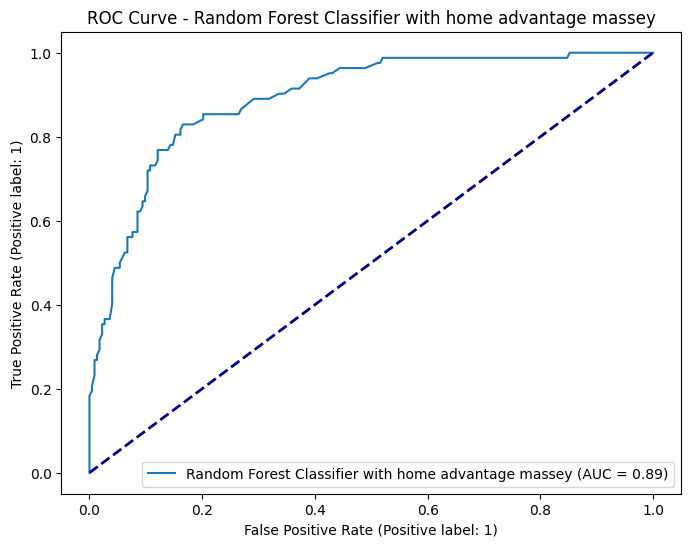

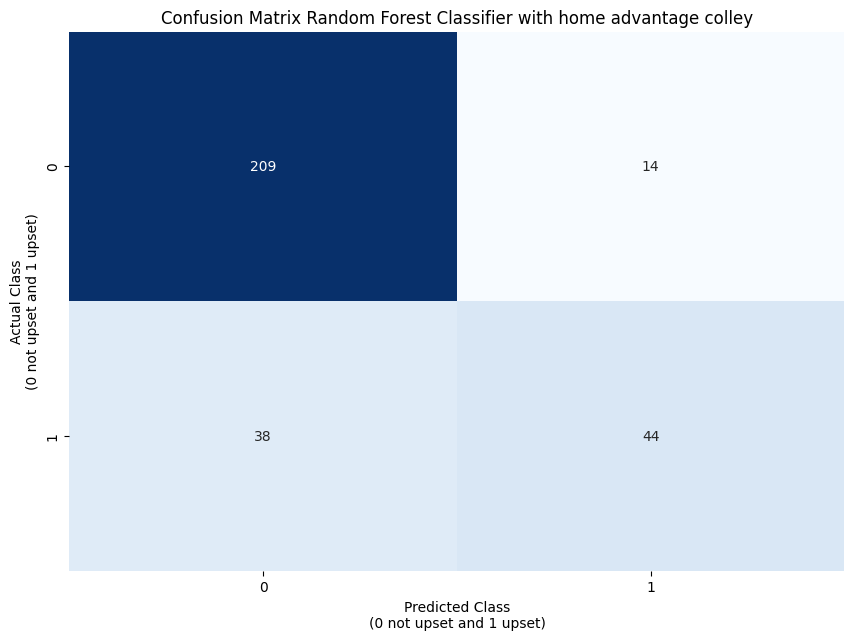

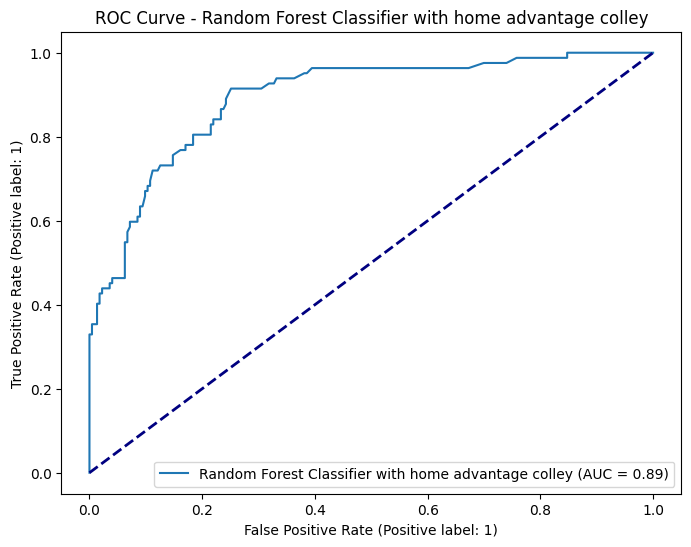

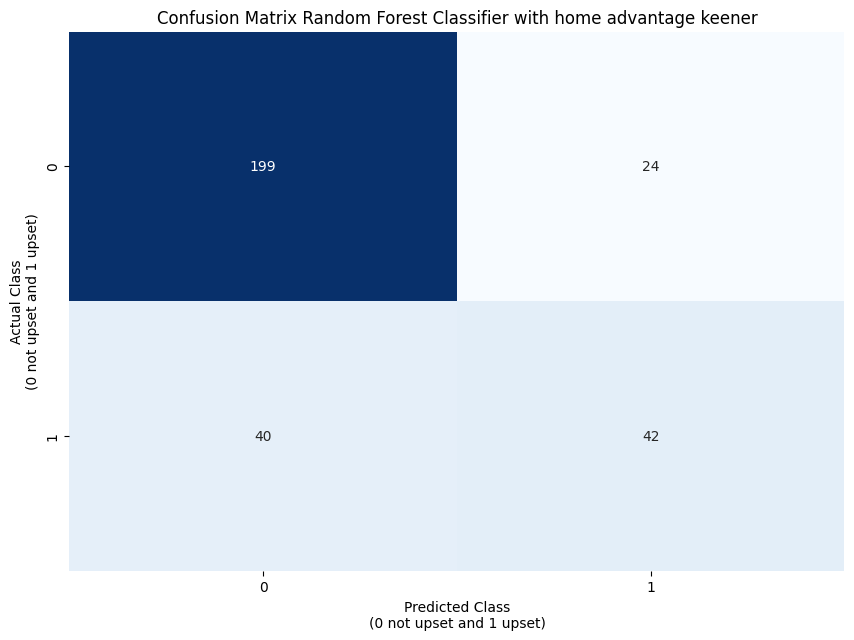

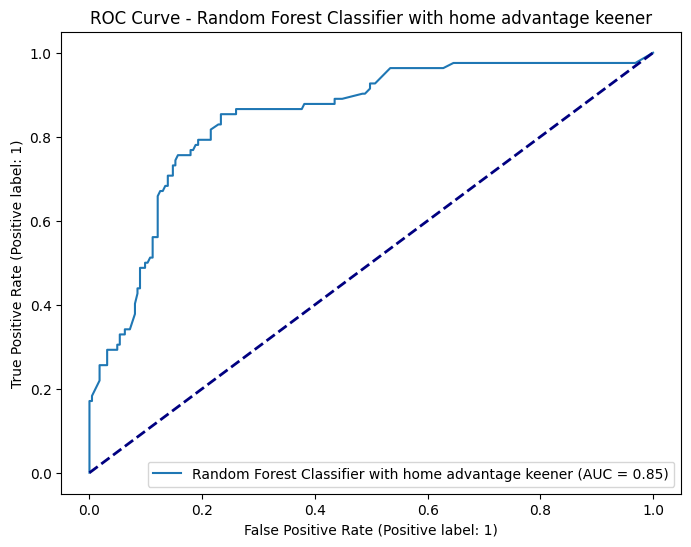

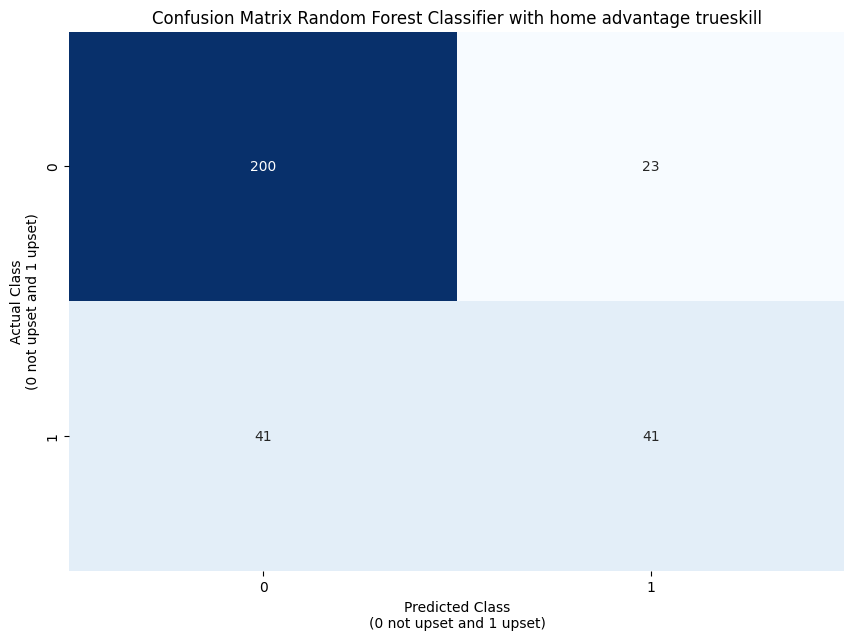

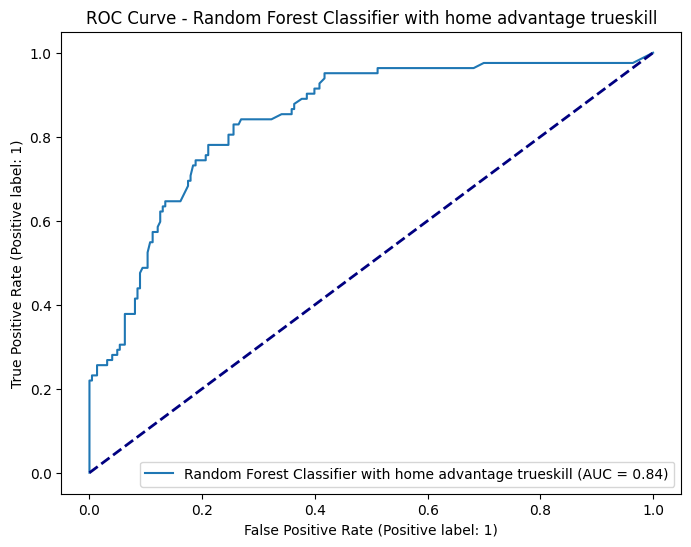

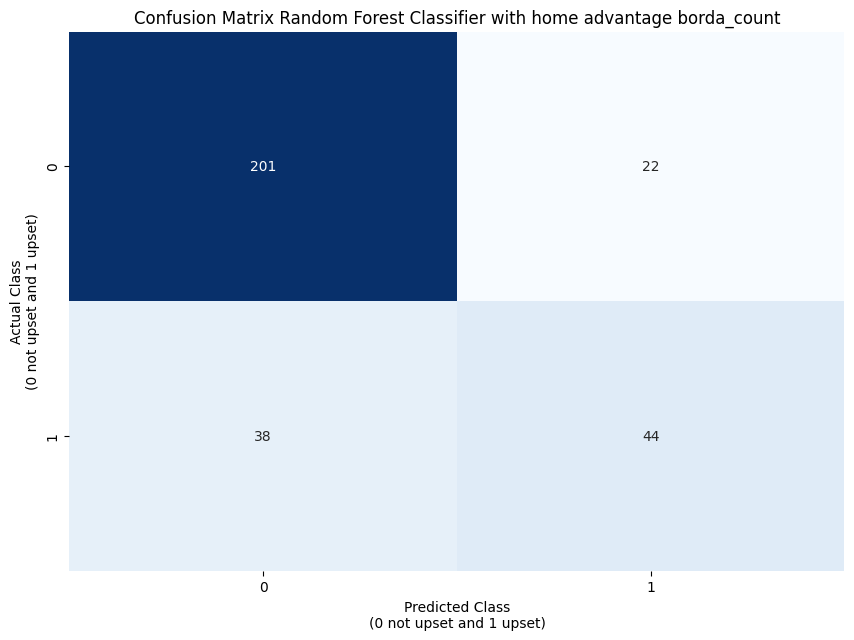

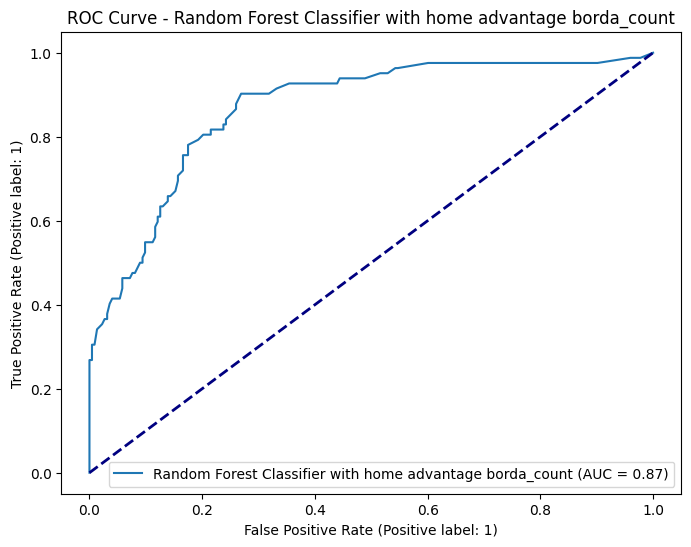

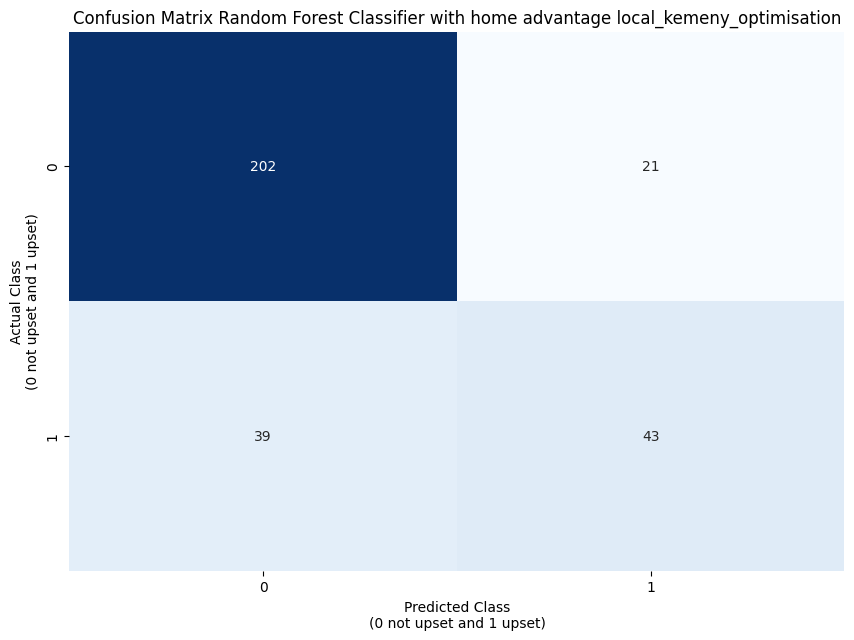

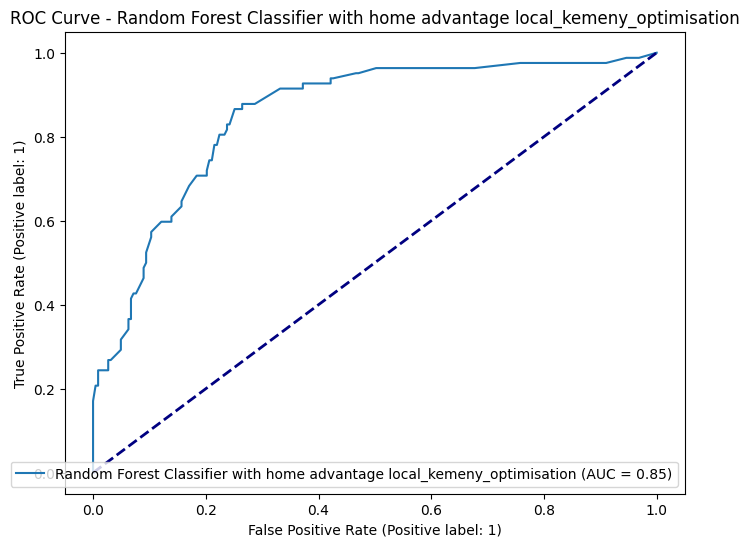

In [18]:
# Random Forest Classifier with home advantage
model_name = "Random Forest Classifier with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rfh = all_results_df
display(all_results_df_rfh)

fold_results_df_rfh = fold_results_df
display(fold_results_df_rfh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rfh.to_excel("all_rfh_results.xlsx")
fold_results_df_rfh.to_excel("fold_results_rfh.xlsx")

XG Boost no_ranking
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.818
Fold 1 Accuracy: 0.803
Fold 1 Recall: 0.250
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.697
Fold 2 Accuracy: 0.967
Fold 2 Recall: 1.000
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.773
Fold 3 Accuracy: 0.918
Fold 3 Recall: 0.688
Best parameters: {'classifier__colsample_bytree': 1

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   XG Boost no_ranking XG Boost round_3_position XG Boost massey  \
0                0.895                     0.918           0.846   
1                0.078                     0.060           0.020   
2                0.646                     0.744           0.485   
3                0.302                     0.198           0.110   
4                0.895                     0.918           0.846   
5              220.000                   219.000         218.000   
6                3.000                     4.000           5.000   
7               29.000                    21.000          42.000   
8               53.000                    61.000          40.000   
9                0.884                     0.912           0.838   
10               0.987                     0.982           0.978   
11               0.932                     0.946           0.903   
12               0.946                     0.938           0.889   
13               0.646                     0.744           0.488   
14               0.768                     0.830           0.630   
15               0.915                     0.925           0.864   
16               0.816                     0.863           0.733   
17               0.850                     0.888           0.766   
18               0.900                     0.919           0.852   
19               0.895                     0.918           0.846   
20               0.888                     0.915           0.829   
21               0.936                     0.983           0.915   

   XG Boost colley XG Boost keener XG Boost trueskill XG Boost borda_count  \
0            0.839           0.856              0.846                0.856   
1            0.058           0.041              0.038                0.060   
2            0.512           0.546              0.512                0.496   
3            0.173           0.190              0.158                0.261   
4            0.839           0.856              0.846                0.856   
5          214.000         216.000            216.000              220.000   
6            9.000           7.000              7.000                3.000   
7           40.000          37.000             40.000               41.000   
8           42.000          45.000             42.000               41.000   
9            0.843           0.854              0.844                0.843   
10           0.960           0.969              0.969                0.987   
11           0.897           0.908              0.902

Model Name Ranking  Fold  \
0                  XG Boost no_ranking     1   
1                  XG Boost no_ranking     2   
2                  XG Boost no_ranking     3   
3                  XG Boost no_ranking     4   
4                  XG Boost no_ranking     5   
5            XG Boost round_3_position     1   
6            XG Boost round_3_position     2   
7            XG Boost round_3_position     3   
8            XG Boost round_3_position     4   
9            XG Boost round_3_position     5   
10                     XG Boost massey     1   
11                     XG Boost massey     2   
12                     XG Boost massey     3   
13                     XG Boost massey     4   
14                     XG Boost massey     5   
15                     XG Boost colley     1   
16                     XG Boost colley     2   
17                     XG Boost colley     3   
18                     XG Boost colley     4   
19                     XG Boost colley     5   
20                     XG Boost keener     1   
21                     XG Boost keener     2   
22                     XG Boost keener     3   
23                     XG Boost keener     4   
24                     XG Boost keener     5   
25                  XG Boost trueskill     1   
26                  XG Boost trueskill     2   
27                  XG Boost trueskill     3   
28                  XG Boost trueskill     4   
29                  XG Boost trueskill     5   
30                XG Boost borda_count     1   
31                XG Boost borda_count     2   
32                XG Boost borda_count     3   
33                XG Boost borda_count     4   
34                XG Boost borda_count     5   
35  XG Boost local_kemeny_optimisation     1   
36  XG Boost local_kemeny_optimisation     2   
37  XG Boost local_kemeny_optimisation     3   
38  XG Boost local_kemeny_optimisation     4   
39  XG Boost local_kemeny_optimisation     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__colsample_bytree': 1.0, 'classif...   
1   {'classifier__colsample_bytree': 1.0, 'classif...   
2   {'classifier__colsample_bytree': 1.0, 'classif...   
3   {'classifier__colsample_bytree': 1.0, 'classif...   
4   {'classifier__colsample_bytree': 1.0, 'classif...   
5   {'classifier__colsample_bytree': 0.6, 'classif...   
6   {'classifier__colsample_bytree': 1.0, 'classif...   
7   {'classifier__colsample_bytree': 1.0, 'classif...   
8   {'classifier__colsample_bytree': 1.0, 'classif...   
9   {'classifier__colsample_bytree': 1.0, 'classif...   
10  {'classifier__colsample_bytree': 0.6, 'classif...   
11  {'classifier__colsample_bytree': 1.0, 'classif...   
12  {'classifier__colsample_bytree': 1.0, 'classif...   
13  {'classifier__colsample_bytree': 1.0, 'classif...   
14  {'classifier__colsample_bytree': 1.0, 'classif...   
15  {'classifier__colsample_bytree': 1.0, 'classif...   
16  {'classifier__colsample_bytree': 1.0, 'classif...   
17  {'classifier__colsample_bytree': 1.0, 'classif...   
18  {'classifier__colsample_bytree': 0.6, 'classif...   
19  {'classifier__colsample_bytree': 1.0, 'classif...   
20  {'classifier__colsample_bytree': 1.0, 'classif...   
21  {'classifier__colsample_bytree': 0.6, 'classif...   
22  {'classifier__colsample_bytree': 1.0, 'classif...   
23  {'classifier__colsample_bytree': 1.0, 'classif...   
24  {'classifier__colsample_bytree': 1.0, 'classif...   
25  {'classifier__colsample_bytree': 1.0, 'classif...   
26  {'classifier__colsample_bytree': 1.0, 'classif...   
27  {'classifier__colsample_bytree': 1.0, 'classif...   
28  {'classifier__colsample_bytree': 1.0, 'classif...   
29  {'classifier__colsample_bytree': 1.0, 'classif...   
30  {'classifier__colsample_bytree': 1.0, 'classif...   
31  {'classifier__colsample_bytree': 1.0, 'classif...   
32  {'classifier__colsample_bytree': 1.0, 'classif...   
33  {'classifier__colsample_bytree': 1.0, 'classif...   
34  {'classifier__colsample_bytree': 1.0, 'classif...   

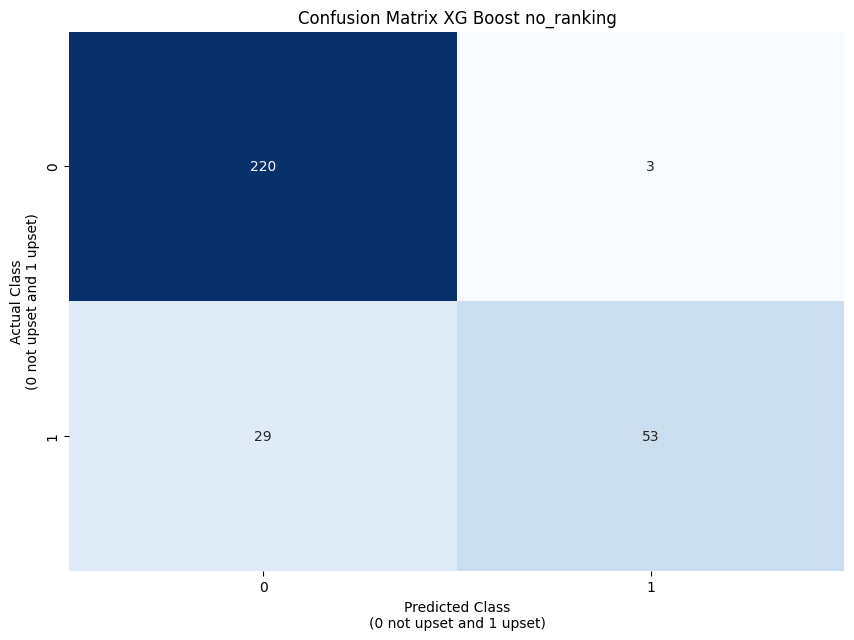

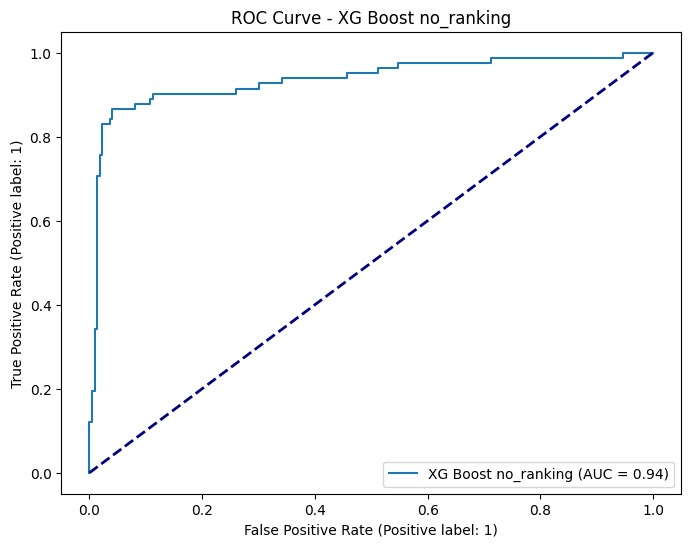

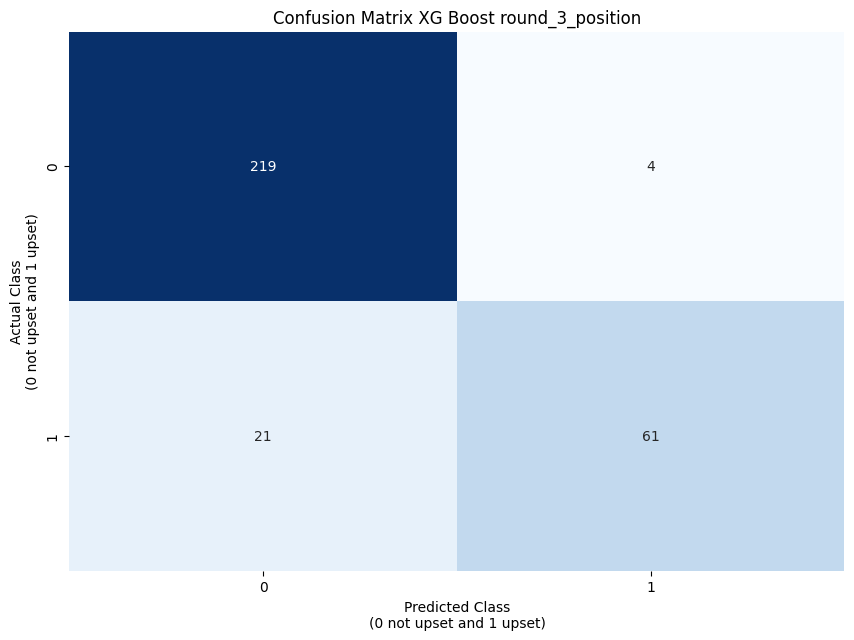

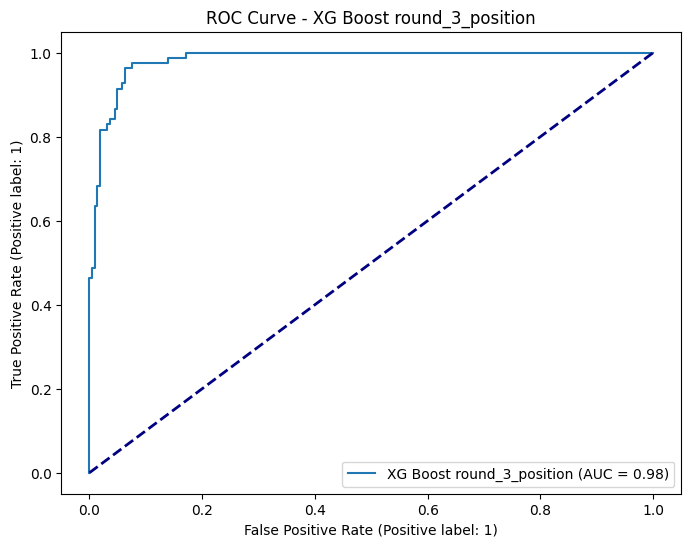

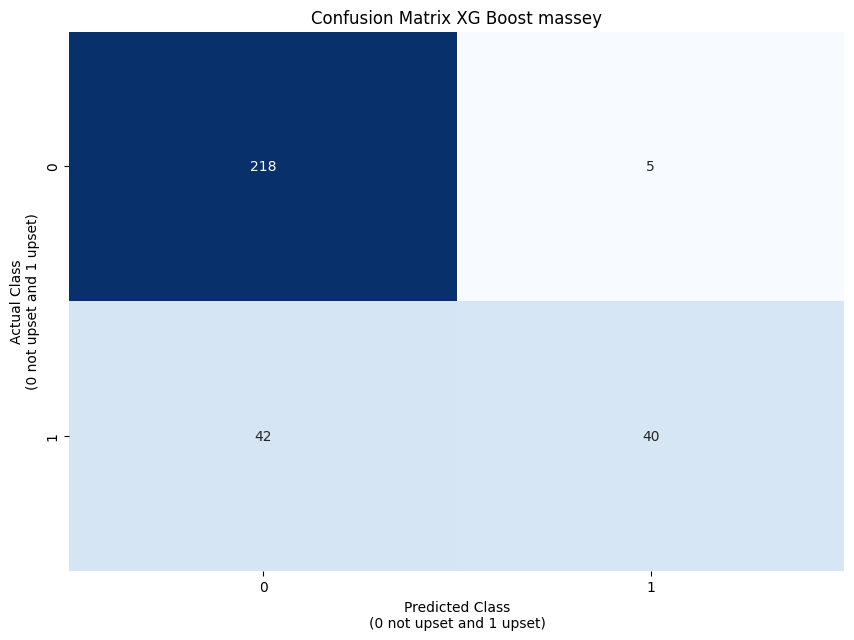

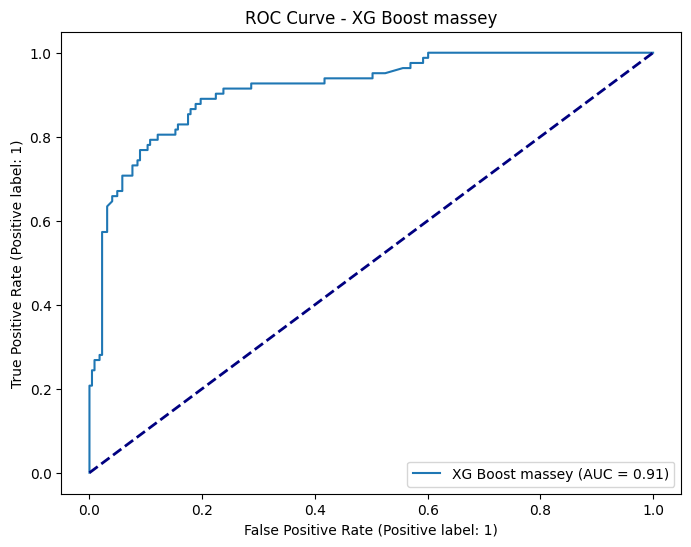

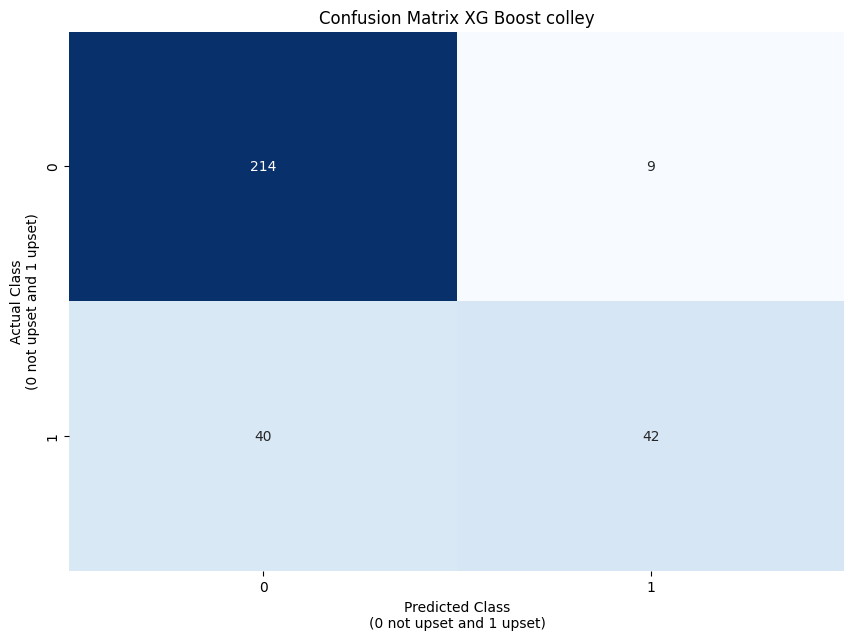

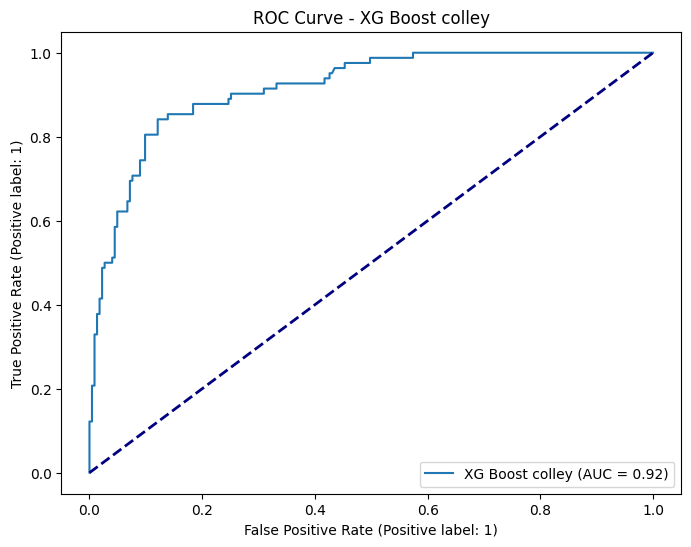

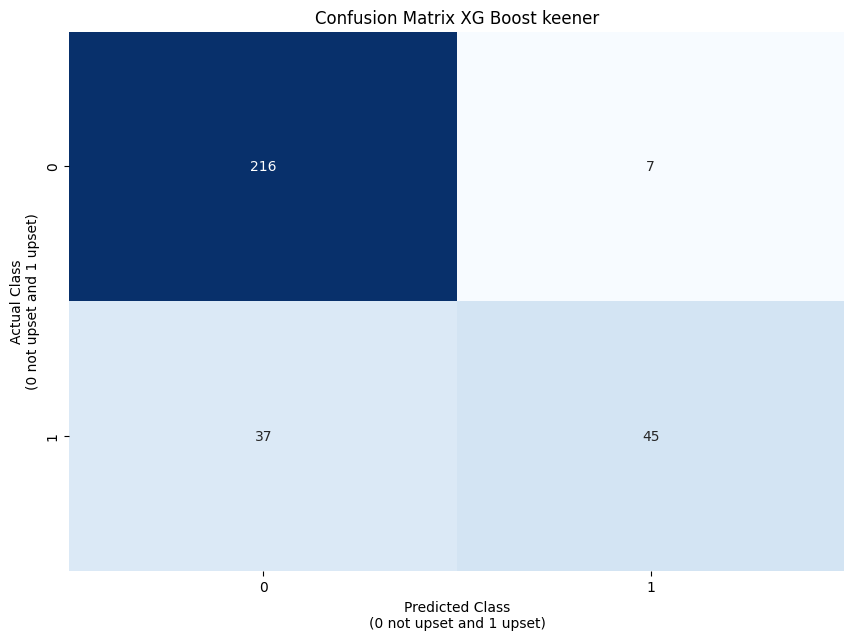

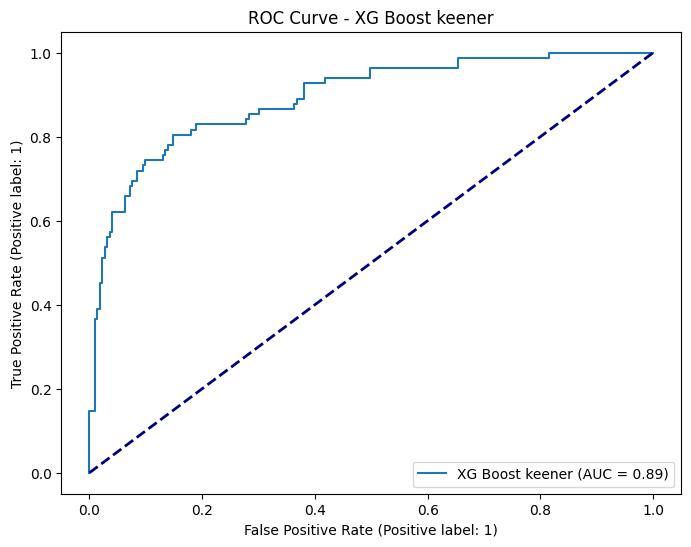

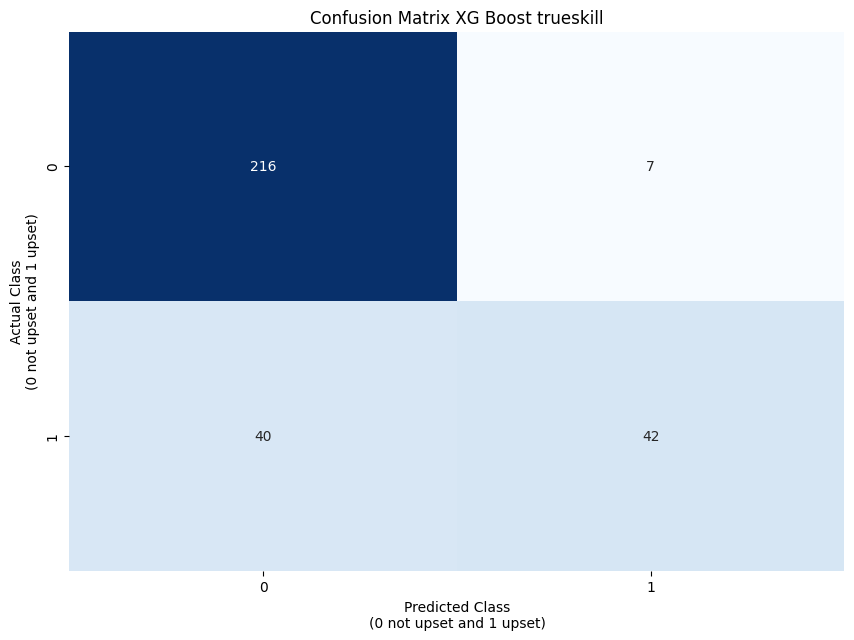

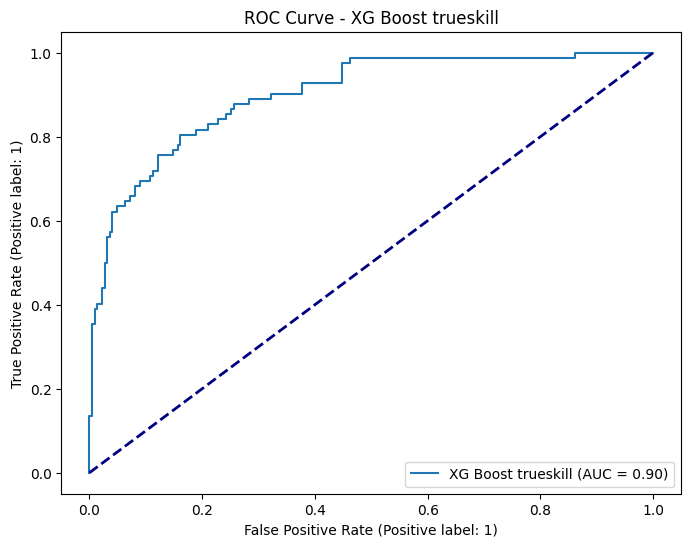

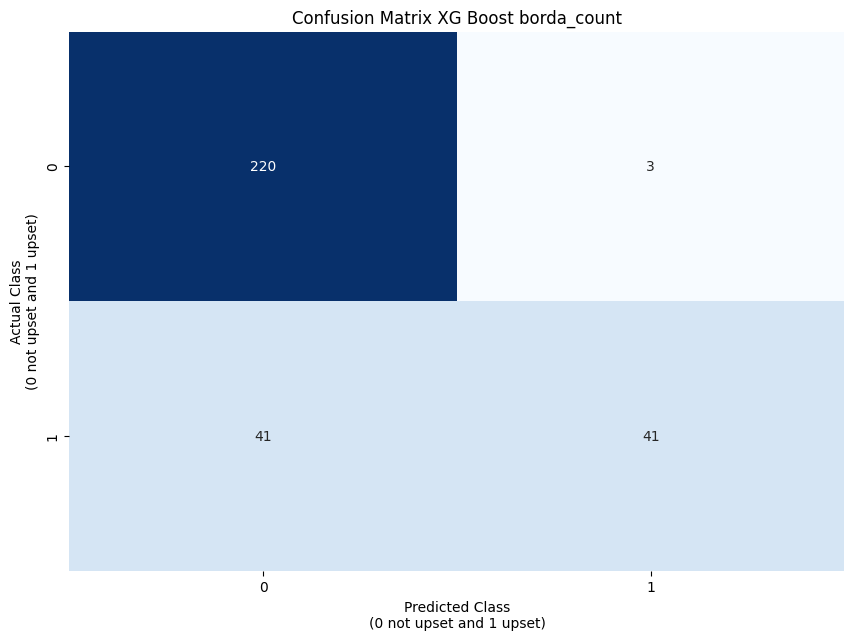

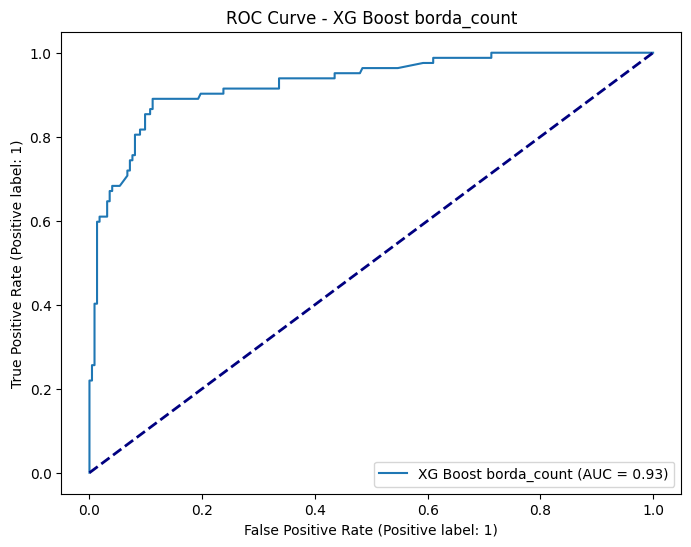

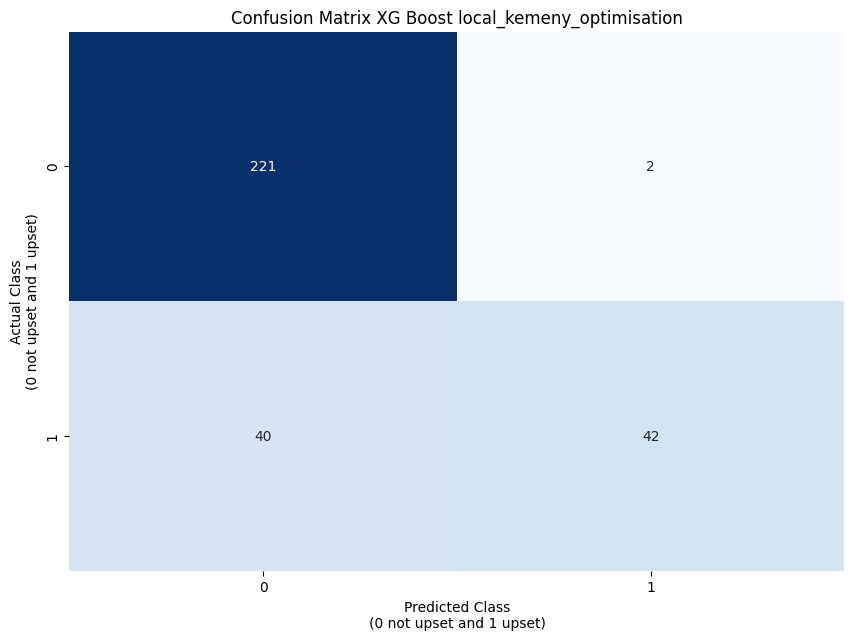

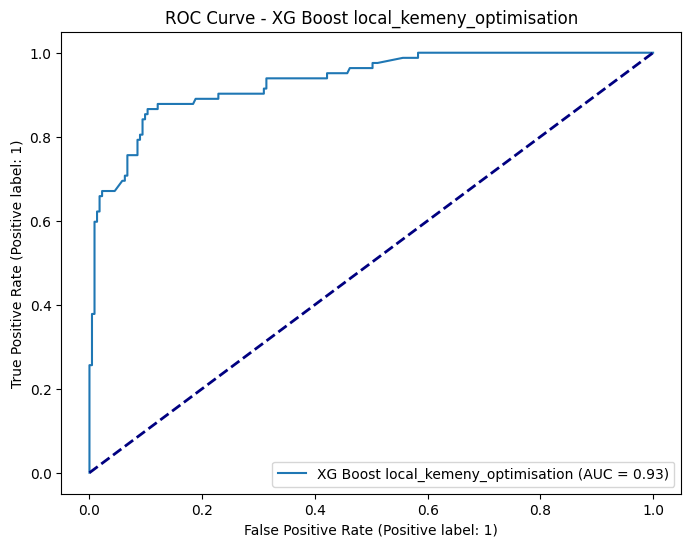

In [19]:
# XG Boost
model_name = "XG Boost"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xg = all_results_df
display(all_results_df_xg)

fold_results_df_xg = fold_results_df
display(fold_results_df_xg)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xg.to_excel("all_xg_results.xlsx")
fold_results_df_xg.to_excel("fold_results_xg.xlsx")

XG Boost with home advantage no_ranking
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 0.8}
Best Estimator's Recall (from GridSearchCV): 0.742
Fold 1 Accuracy: 0.869
Fold 1 Recall: 0.500
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.727
Fold 2 Accuracy: 0.770
Fold 2 Recall: 0.812
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.803
Fold 3 Accuracy: 0.836
Fold 3 Recall: 0.438
Best parameters: {'classifier__c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.617
Fold 4 Accuracy: 0.852
Fold 4 Recall: 0.529
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.801
Fold 5 Accuracy: 0.836
Fold 5 Recall: 0.529
Average Accuracy: 0.820
Average Recall: 0.499
XG Boost with home advantage local_kemeny_optimisation
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.742
Fold 1 Accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.602
Fold 4 Accuracy: 0.836
Fold 4 Recall: 0.647
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.816
Fold 5 Accuracy: 0.770
Fold 5 Recall: 0.353
Average Accuracy: 0.807
Average Recall: 0.500


metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   XG Boost with home advantage no_ranking  \
0                                    0.816   
1                                    0.039   
2                                    0.538   
3                                    0.178   
4                                    0.816   
5                                  205.000   
6                                   18.000   
7                                   38.000   
8                                   44.000   
9                                    0.844   
10                                   0.919   
11                                   0.880   
12                                   0.710   
13                                   0.537   
14                                   0.611   
15                                   0.777   
16                                   0.728   
17                                   0.745   
18                                   0.808   
19                                   0.816   
20                                   0.808   
21                                   0.842   

   XG Boost with home advantage round_3_position  \
0                                          0.816   
1                                          0.048   
2                                          0.574   
3                                          0.164   
4                                          0.816   
5                                        202.000   
6                                         21.000   
7                                         35.000   
8                                         47.000   
9                                          0.852   
10                                         0.906   
11                                         0.878   
12                                         0.691   
13                                         0.573   
14                                         0.627   
15                                         0.772   
16                                         0.740   
17                                         0.752   
18                                         0.809   
19                                         0.816   
20                                         0.811   
21                                         0.864   

   XG Boost with home advantage massey XG Boost with home advantage colley  \
0                                0.810                               0.784   
1                                0.027                               0.028   
2                                0.499                          

Model Name Ranking  Fold  \
0             XG Boost with home advantage no_ranking     1   
1             XG Boost with home advantage no_ranking     2   
2             XG Boost with home advantage no_ranking     3   
3             XG Boost with home advantage no_ranking     4   
4             XG Boost with home advantage no_ranking     5   
5       XG Boost with home advantage round_3_position     1   
6       XG Boost with home advantage round_3_position     2   
7       XG Boost with home advantage round_3_position     3   
8       XG Boost with home advantage round_3_position     4   
9       XG Boost with home advantage round_3_position     5   
10                XG Boost with home advantage massey     1   
11                XG Boost with home advantage massey     2   
12                XG Boost with home advantage massey     3   
13                XG Boost with home advantage massey     4   
14                XG Boost with home advantage massey     5   
15                XG Boost with home advantage colley     1   
16                XG Boost with home advantage colley     2   
17                XG Boost with home advantage colley     3   
18                XG Boost with home advantage colley     4   
19                XG Boost with home advantage colley     5   
20                XG Boost with home advantage keener     1   
21                XG Boost with home advantage keener     2   
22                XG Boost with home advantage keener     3   
23                XG Boost with home advantage keener     4   
24                XG Boost with home advantage keener     5   
25             XG Boost with home advantage trueskill     1   
26             XG Boost with home advantage trueskill     2   
27             XG Boost with home advantage trueskill     3   
28             XG Boost with home advantage trueskill     4   
29             XG Boost with home advantage trueskill     5   
30           XG Boost with home advantage borda_count     1   
31           XG Boost with home advantage borda_count     2   
32           XG Boost with home advantage borda_count     3   
33           XG Boost with home advantage borda_count     4   
34           XG Boost with home advantage borda_count     5   
35  XG Boost with home advantage local_kemeny_opti...     1   
36  XG Boost with home advantage local_kemeny_opti...     2   
37  XG Boost with home advantage local_kemeny_opti...     3   
38  XG Boost with home advantage local_kemeny_opti...     4   
39  XG Boost with home advantage local_kemeny_opti...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__colsample_bytree': 1.0, 'classif...   
1   {'classifier__colsample_bytree': 1.0, 'classif...   
2   {'classifier__colsample_bytree': 1.0, 'classif...   
3   {'classifier__colsample_bytree': 0.6, 'classif...   
4   {'classifier__colsample_bytree': 0.6, 'classif...   
5   {'classifier__colsample_bytree': 0.6, 'classif...   
6   {'classifier__colsample_bytree': 0.6, 'classif...   
7   {'classifier__colsample_bytree': 0.6, 'classif...   
8   {'classifier__colsample_bytree': 1.0, 'classif...   
9   {'classifier__colsample_bytree': 0.6, 'classif...   
10  {'classifier__colsample_bytree': 0.6, 'classif...   
11  {'classifier__colsample_bytree': 1.0, 'classif...   
12  {'classifier__colsample_bytree': 1.0, 'classif...   
13  {'classifier__colsample_bytree': 1.0, 'classif...   
14  {'classifier__colsample_bytree': 0.6, 'classif...   
15  {'classifier__colsample_bytree': 0.6, 'classif...   
16  {'classifier__colsample_bytree': 1.0, 'classif...   
17  {'classifier__colsample_bytree': 1.0, 'classif...   
18  {'classifier__colsample_bytree': 0.6, 'classif...   
19  {'classifier__colsample_bytree': 0.6, 'classif...   
20  {'classifier__colsample_bytree': 0.6, 'classif...   
21  {'classifier__colsample_bytree': 1.0, 'classif...   
22  {'classifier__colsample_bytree': 1.0, 'classif...   
23  {'classifier__colsample_bytree': 0.6, 'classif...   
24  {'classifier__colsampl

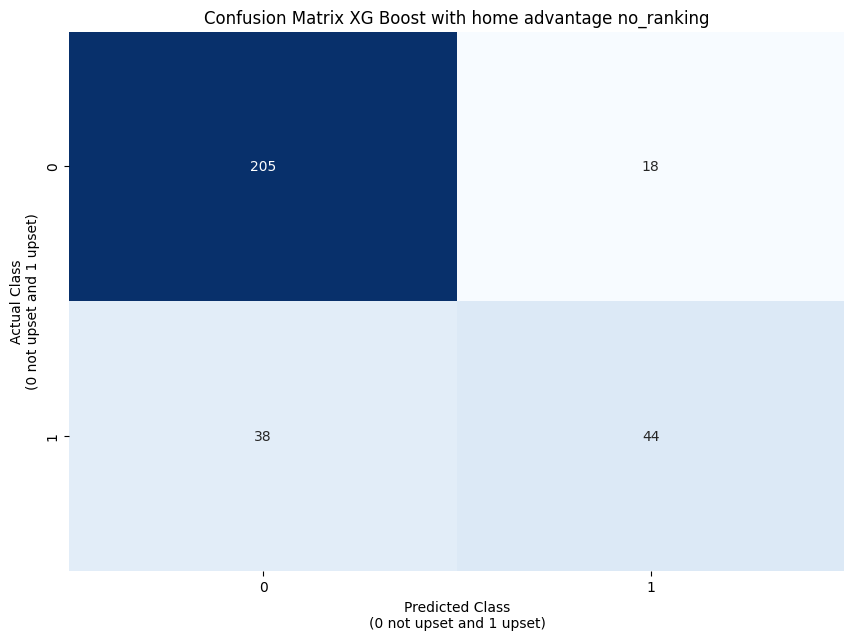

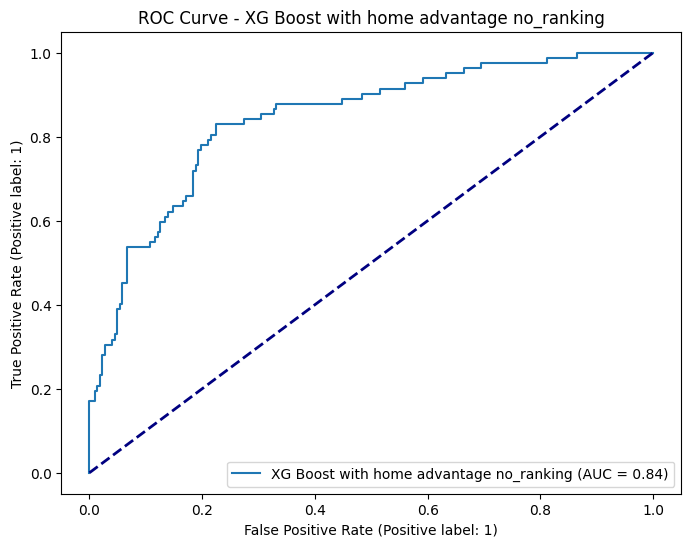

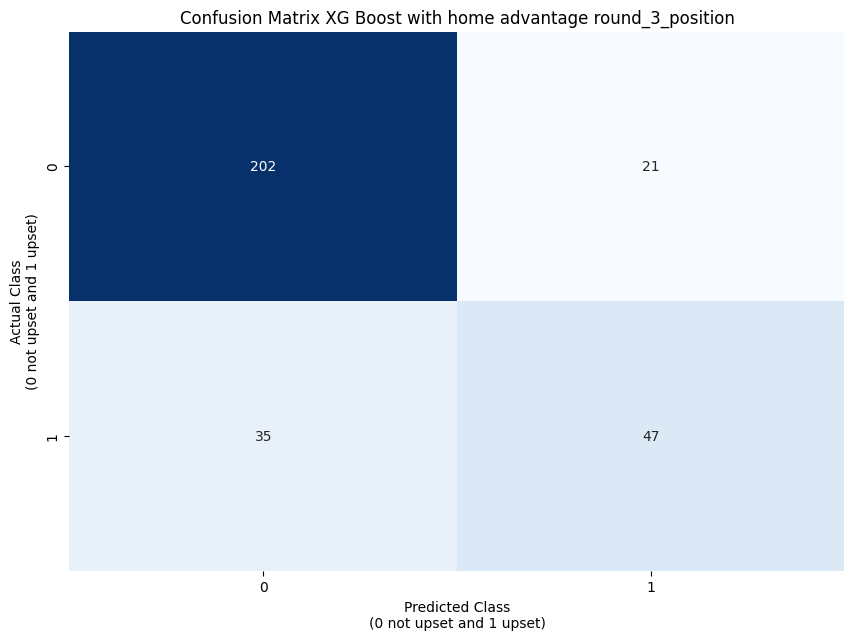

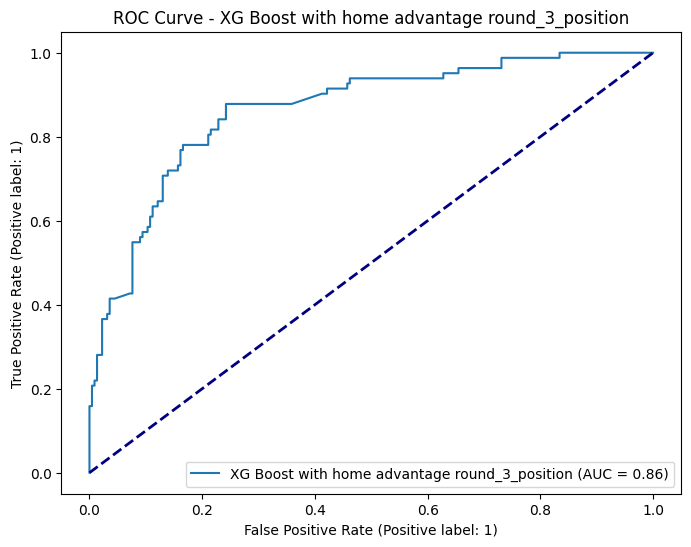

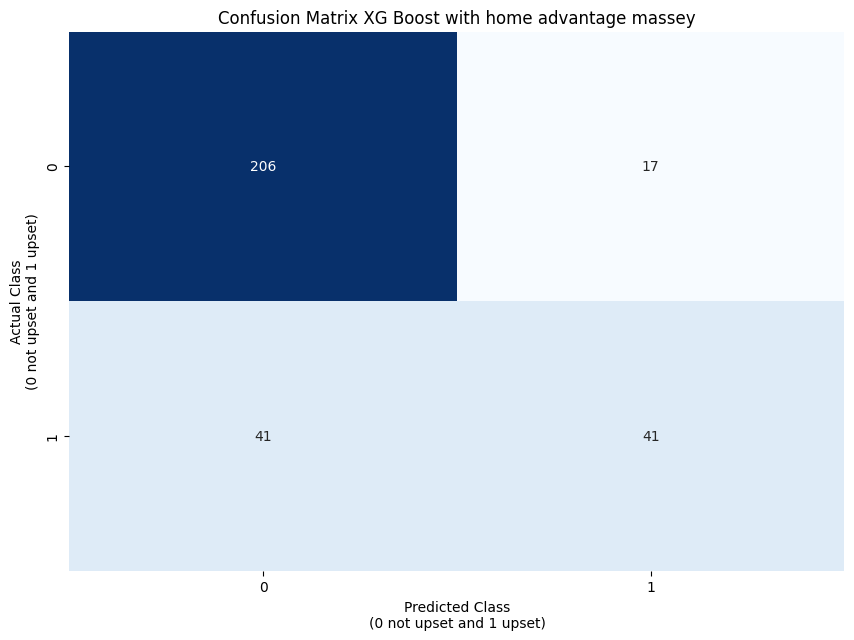

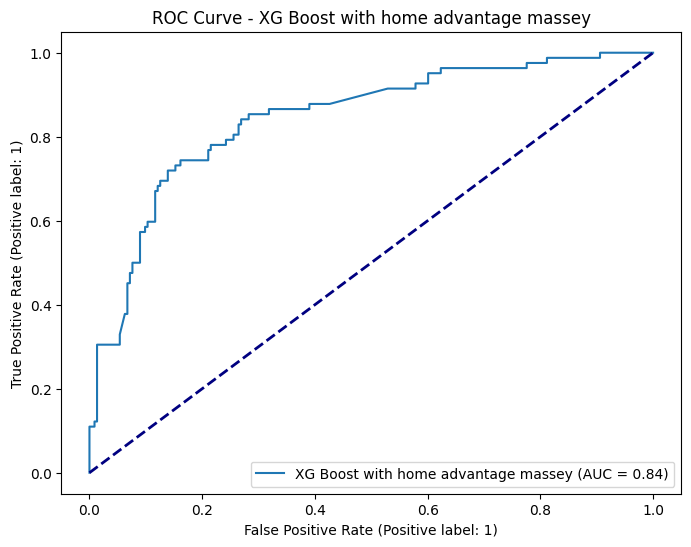

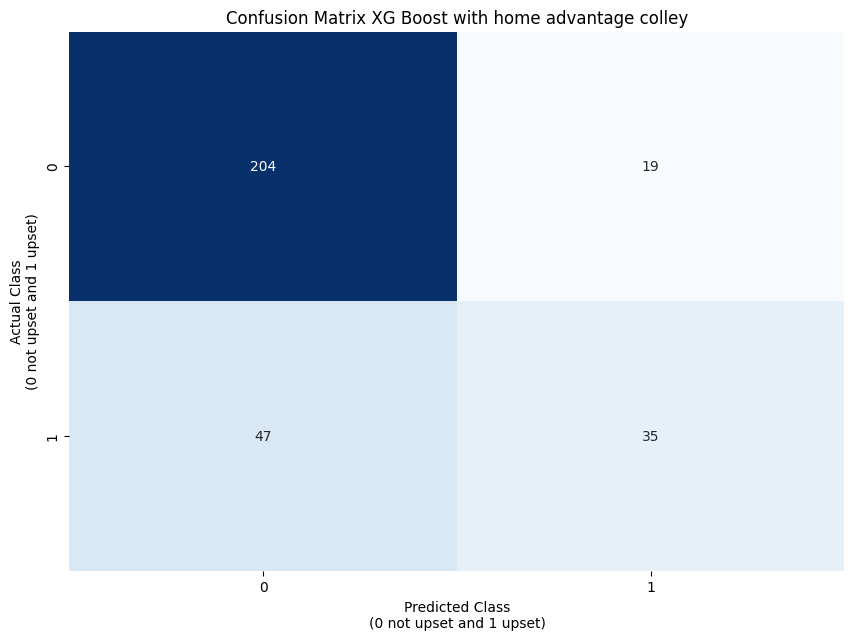

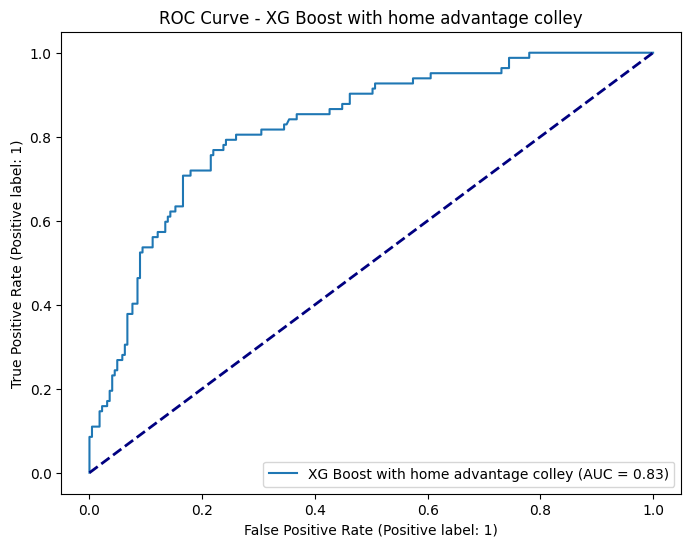

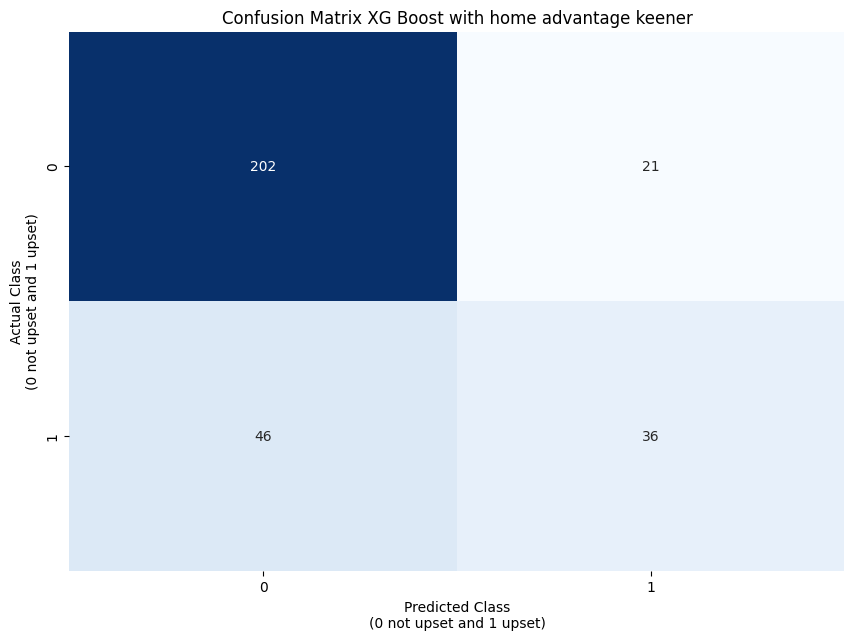

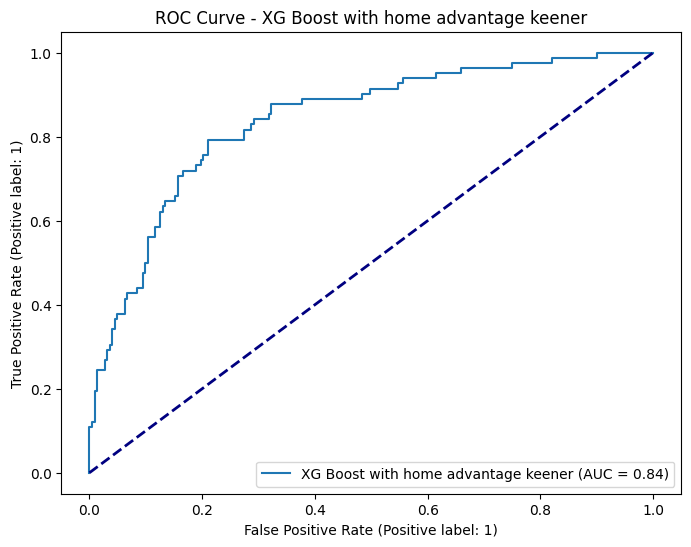

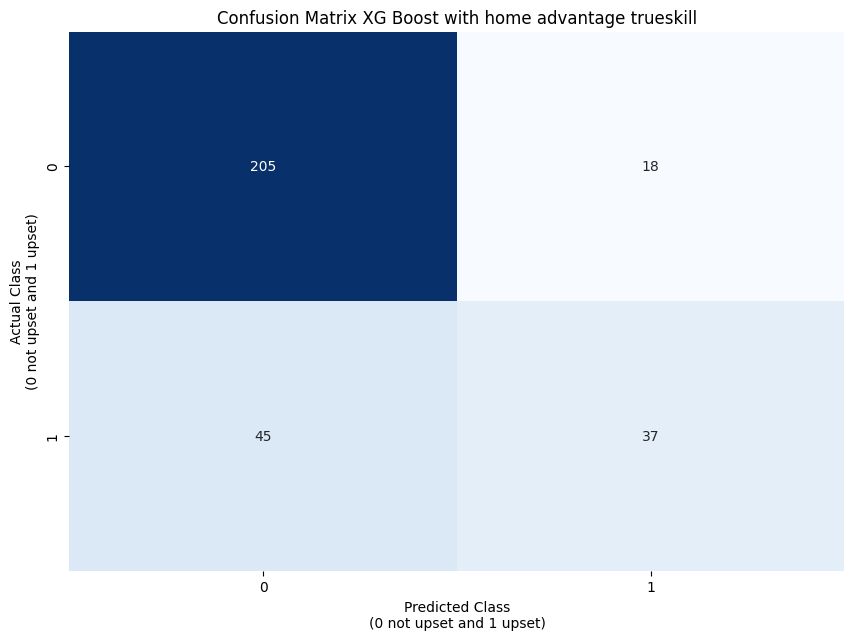

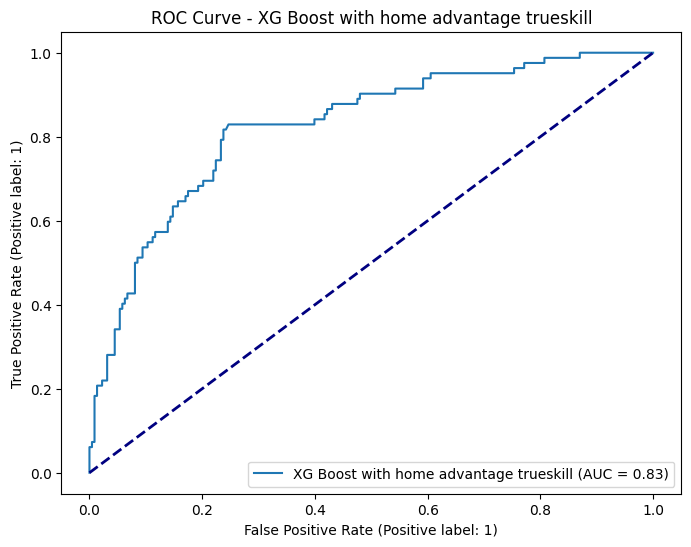

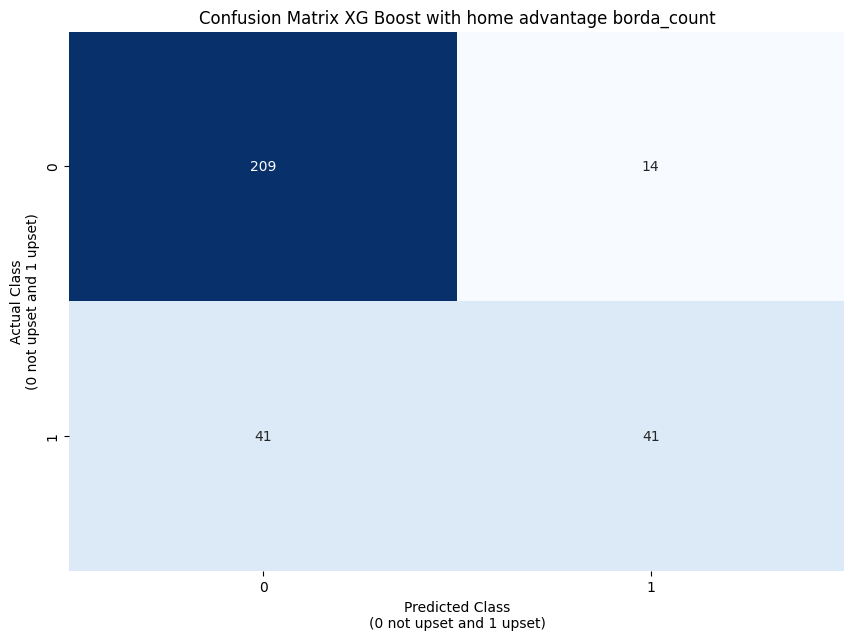

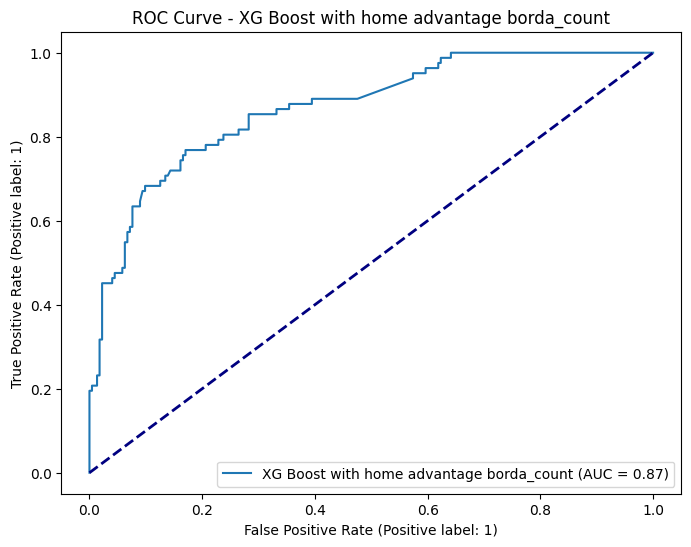

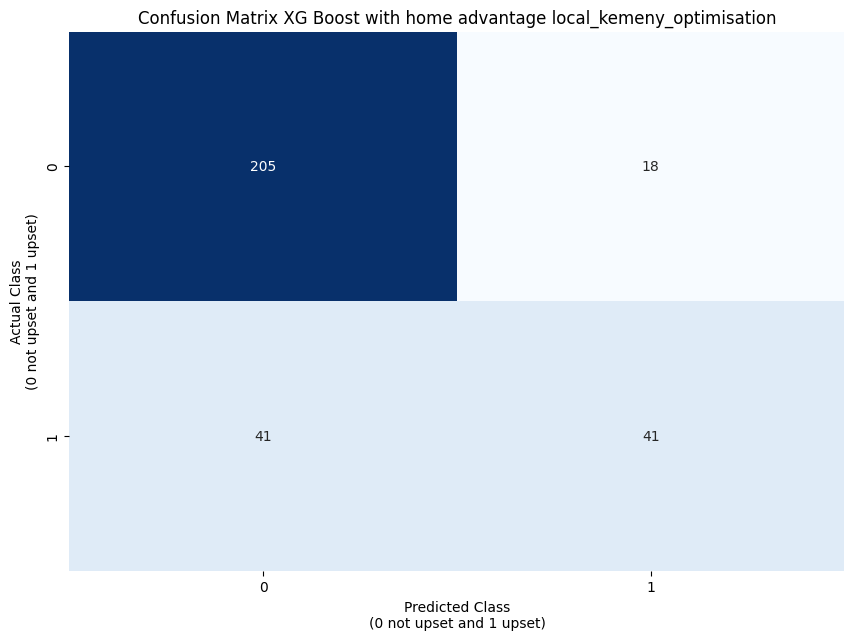

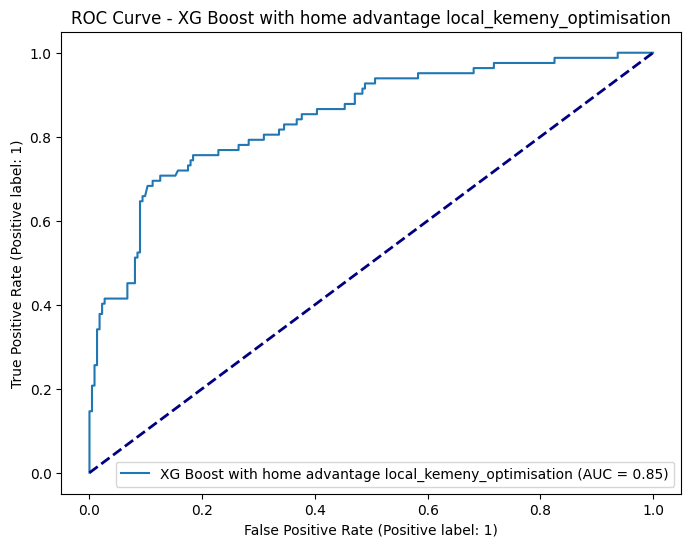

In [20]:
# XG Boost with home advantage
model_name = "XG Boost with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xgh = all_results_df
display(all_results_df_xgh)

fold_results_df_xgh = fold_results_df
display(fold_results_df_xgh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xgh.to_excel("all_xgh_results.xlsx")
fold_results_df_xgh.to_excel("fold_results_xgh.xlsx")

In [27]:
all_results_df = all_results_df_slrh.merge(all_results_df_slr, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nn.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rf.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rfh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_xg.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_xgh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)
all_results_df.to_excel("all_results_.xlsx")

# Load data from Excel to Google BigQuery
all_results_from_excel = pd.read_excel("all_results_.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_fold_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(all_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   XG Boost with home advantage no_ranking  \
0                                    0.816   
1                                    0.039   
2                                    0.538   
3                                    0.178   
4                                    0.816   
5                                  205.000   
6                                   18.000   
7                                   38.000   
8                                   44.000   
9                                    0.844   
10                                   0.919   
11                                   0.880   
12                                   0.710   
13                                   0.537   
14                                   0.611   
15                                   0.777   
16                                   0.728   
17                                   0.745   
18                                   0.808   
19                                   0.816   
20                                   0.808   
21                                   0.842   

   XG Boost with home advantage round_3_position  \
0                                          0.816   
1                                          0.048   
2                                          0.574   
3                                          0.164   
4                                          0.816   
5                                        202.000   
6                                         21.000   
7                                         35.000   
8                                         47.000   
9                                          0.852   
10                                         0.906   
11                                         0.878   
12                                         0.691   
13                                         0.573   
14                                         0.627   
15                                         0.772   
16                                         0.740   
17                                         0.752   
18                                         0.809   
19                                         0.816   
20                                         0.811   
21                                         0.864   

   XG Boost with home advantage massey XG Boost with home advantage colley  \
0                                0.810                               0.784   
1                                0.027                               0.028   
2                                0.499                          

100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_fold_results


In [28]:
# Load updated Fold results to Google Big Query

# Merge fold results from each model
fold_results_df = pd.concat([fold_results_df_slr, fold_results_df_slrh, fold_results_df_wlrh, fold_results_df_nn, fold_results_df_nnh, fold_results_df_rf, fold_results_df_rfh, fold_results_df_xg, fold_results_df_xgh])
fold_results_df = fold_results_df.rename(columns=lambda x: x.replace('(', '_').replace(')', ''))
display(fold_results_df)

# Write to Excel
fold_results_df.to_excel("fold_results_.xlsx")

# Load fold results data from Excel to Google BigQuery
fold_results_from_excel = pd.read_excel("all_results_.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_fold_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(fold_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


Model Name Ranking  Fold  \
0              Standard LogisticRegression no_ranking     1   
1              Standard LogisticRegression no_ranking     2   
2              Standard LogisticRegression no_ranking     3   
3              Standard LogisticRegression no_ranking     4   
4              Standard LogisticRegression no_ranking     5   
..                                                ...   ...   
35  XG Boost with home advantage local_kemeny_opti...     1   
36  XG Boost with home advantage local_kemeny_opti...     2   
37  XG Boost with home advantage local_kemeny_opti...     3   
38  XG Boost with home advantage local_kemeny_opti...     4   
39  XG Boost with home advantage local_kemeny_opti...     5   

                        Best Parameters _GridSearchCV  \
0   {'classifier__C': 10.0, 'classifier__penalty':...   
1   {'classifier__C': 1000.0, 'classifier__penalty...   
2   {'classifier__C': 100.0, 'classifier__penalty'...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 1000.0, 'classifier__penalty...   
..                                                ...   
35  {'classifier__colsample_bytree': 1.0, 'classif...   
36  {'classifier__colsample_bytree': 1.0, 'classif...   
37  {'classifier__colsample_bytree': 1.0, 'classif...   
38  {'classifier__colsample_bytree': 1.0, 'classif...   
39  {'classifier__colsample_bytree': 0.6, 'classif...   

    Best Recall _GridSearchCV  Validation Accuracy  Validation Recall  
0                    0.348485             0.704918           0.187500  
1                    0.393939             0.639344           0.250000  
2                    0.348485             0.639344           0.187500  
3                    0.411255             0.688525           0.117647  
4                    0.383117             0.721311           0.176471  
..                        ...                  ...                ...  
35                   0.742424             0.918033           0.687500  
36                   0.621212             0.770492           0.812500  
37                   0.803030             0.737705           0.000000  
38                   0.601732             0.836066           0.647059  
39                   0.816017             0.770492           0.352941  

[360 rows x 6 columns]

100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_fold_results
